📚🩺 Insurance 회귀 분석 캡스톤

| 아이티윌 데이터분석 부트캠프 52기 이광호 강사 (leekh4232@gmail.com
)

“왜 어떤 사람의 의료보험 청구 비용은 높고, 어떤 사람의 비용은 낮을까?”

의료 비용은 개인의 건강 상태를 반영하기도 하지만, 나이, 성별, 거주 지역, 생활습관에 따라 체계적으로 달라집니다.
특히 흡연 여부는 의료비를 얼마나 크게 변화시킬까? 젊은 사람도 흡연자라면 높은 비용을 지불할까?

이번 캡스톤 과제에서는 Insurance 데이터셋을 활용하여 개인의 인구학적·건강 특성이 의료보험 청구 비용을 어떤 구조로 설명하는지 회귀모형을 통해 단계적으로 탐구합니다.

이 과제의 목표는 예측 정확도를 높이는 것이 아니라, **“의료 비용 불평등은 어떤 논리로 형성되는가”**를 수치와 언어로 설명하는 것입니다.

※ 본 과제는 팀 / 개인 단위 모두 수행 가능합니다.

### 라이브러리 참조

In [ ]:
# 라이브러리 기본 참조
from hossam import load_data
from pandas import DataFrame
from matplotlib import pyplot as plt
from matplotlib import font_manager as fm
import seaborn as sb
import numpy as np
from pandas.api.types import CategoricalDtype
import pandas as pd
from scipy.stats import t, normaltest, bartlett, levene, ttest_ind
import pingouin as pg
from pandas import DataFrame, get_dummies
# 선형회귀를 위한 참조
import statsmodels.api as sm
from statsmodels.formula.api import ols

# 결과 검정을 위한 참조
from statsmodels.stats.diagnostic import linear_reset
from scipy.stats import zscore, probplot, shapiro, anderson
from statsmodels.stats.api import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson

# VIF값을 계산하기 위한 참조
from statsmodels.stats.outliers_influence import variance_inflation_factor

from statannotations.Annotator import Annotator

# 로지스틱을 위한 참조
import statsmodels.api as sm

from hossam import load_data
from pandas import melt, DataFrame
from matplotlib import pyplot as plt
from matplotlib import font_manager as fm
import seaborn as sb
from math import sqrt

from sklearn.preprocessing import RobustScaler

# 로지스틱 결과 판별을 위한 참조
# → 머신러닝 라이브러리를 미리 사용
from sklearn.metrics import (
    confusion_matrix,
    roc_curve,
    roc_auc_score,
    accuracy_score,
    recall_score,
    precision_score,
    f1_score
)

# 가정 확인을 위한 라이브러리
from scipy.stats import t, normaltest, bartlett, levene

# 분산분석을 위한 라이브러리
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from pingouin import anova
from pingouin import welch_anova

# 사후검정을 위한 라이브러리
from pingouin import pairwise_tukey, pairwise_tests, pairwise_gameshowell

import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.diagnostic import linear_reset
from scipy.stats import zscore, pearsonr, spearmanr

In [ ]:
# 그래프 초기화하기
my_dpi = 120


### 데이터 불러오기

In [ ]:
origin = load_data('insurance')

print("\n==== 데이터 크기 확인 ====")
print(f"데이터셋 크기: {origin.shape}")
print(f"열 개수: {origin.shape[1]}")
print(f"행 개수: {origin.shape[0]}")

print("\n==== 타입확인 ====")
print(origin.info())


[data] https://data.hossam.kr/data/kaggle/insurance.xlsx
[desc] 개인의 나이·성별·BMI·흡연 여부·거주 지역 등 기본 건강·인구학적 정보를 바탕으로 의료보험 청구 비용(charges)을 예측하도록 구성된, 선형회귀와 머신러닝 실습에 널리 사용되는 대표적인 보험 비용 데이터셋 (출처: https://www.kaggle.com/datasets/mirichoi0218/insurance)

[!] Cannot read metadata

==== 데이터 크기 확인 ====
데이터셋 크기: (1338, 7)
열 개수: 7
행 개수: 1338

==== 타입확인 ====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB
None


In [ ]:
origin.head(100)


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
95,28,female,37.620,1,no,southeast,3766.88380
96,54,female,30.800,3,no,southwest,12105.32000
97,55,male,38.280,0,no,southeast,10226.28420
98,56,male,19.950,0,yes,northeast,22412.64850


## 미션 1. 데이터의 전반적인 구조 파악
### 연속형 변수
- 결측·이상치·편향을 점검하고, 처리 기준을 제시한다.
  - 모든 변수에서 결측치 0건 (0%) . 데이터 손실, 보간, 삭제 불필요
  
- charges가 음수이거나 극단값인지, age/bmi 등의 범위가 현실적인지 확인한다.
  - charges 변수에서 음수 값은 관찰되지 않았으며, 의료비 데이터로서 논리적으로 타당한 범위를 유지하고 있다.
  - charges는 오른쪽으로 치우친 분포를 보이며, 고액 의료비 사례는 이상치라기보다 보험 청구 특성상 자연스러운 현상으로 해석된다.
따라서 제거보다는 로그 변환 또는 robust 모델링이 바람직하다.
  - age는 18~64세 범위로 분포하며, 보험 가입 대상 연령으로 타당하다.
  - bmi의 상위 극단값은 존재하나, 현실적 범위 내에 있으며 단순 이상치 제거보다는 분포 왜도를 고려한 변환이 적절하다.
  
- 범주형 변수(sex, smoker, region)가 몇 개의 범주로 구성되어 있고, 특정 범주에 데이터가 지나치게 몰려 있지는 않은지 확인한다.
  
 | 변수     | 범주 수 | 분포 특성         | 편향 여부 |
| ------ | ---- | ------------- | ----- |
| sex    | 2    | 각 성별 거의 50%로 균등         | 없음    |
| smoker | 2    | non-smoker 가 약 80%로 우세 | 불균형 존재    |
| region | 4    | 각 지역마다 24-27%로 균등            | 균등한편    |


- 전처리 전·후가 어떻게 달라졌는지 한눈에 비교하는 표나 요약을 만든다.
  - 해당 단계에서 별도의 전처리 진행하지 않음
  - bmi > 50은 통계적으로는 극단값이지만 도메인 관점에서는 의미 있는 관측치이므로 제거하지 않음

- 단위·해석 주의: charges는 USD입니다. 현실적인 의료비 수준인지 평가하세요.
  - 미국 의료비는 단일 치료 또는 연간 보험 청구 기준으로 수천~수만 달러의 비용이 발생하는 것이 일반적이다. 특히 입원, 수술, 만성 질환, 흡연 등 고위험 요인이 존재할 경우 연간 의료비가 수만 달러에 이르는 사례도 충분히 현실적이다.

📌 출제 의도
“이 값이 말이 되나?”를 먼저 묻고, 어떻게 처리했는지를 기록해 나중 해석에 근거를 남기는 연습입니다.

In [ ]:
df_nullcheck=origin.copy()

1. 결측·이상치·편향을 점검하고, 처리 기준을 제시한다.
- 모든 변수에서 결측치 0건 (0%) . 데이터 손실, 보간, 삭제 불필요

In [ ]:
df_nullcheck.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

몇 퍼센트 누락인지 확인

In [ ]:
df_nullcheck.isna().mean() * 100

age         0.0
sex         0.0
bmi         0.0
children    0.0
smoker      0.0
region      0.0
charges     0.0
dtype: float64

In [ ]:
df_nullcheck.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [ ]:
df_nullcheck.describe(include = 'O')

,sex,smoker,region
count,1338,1338,1338
unique,2,2,4
top,male,no,southeast
freq,676,1064,364


- charges 음수 여부
확인 결과 : charges 변수에서 음수 값은 관찰되지 않았으며, 의료비 데이터로서 논리적으로 타당한 범위를 유지하고 있다.

In [ ]:
df_plot=origin.copy()

- 연속형 데이터(age,bmi,charges) 와 범주형 데이터 (sex , children, smoker, region) 를 분리하여 시각화 해보자

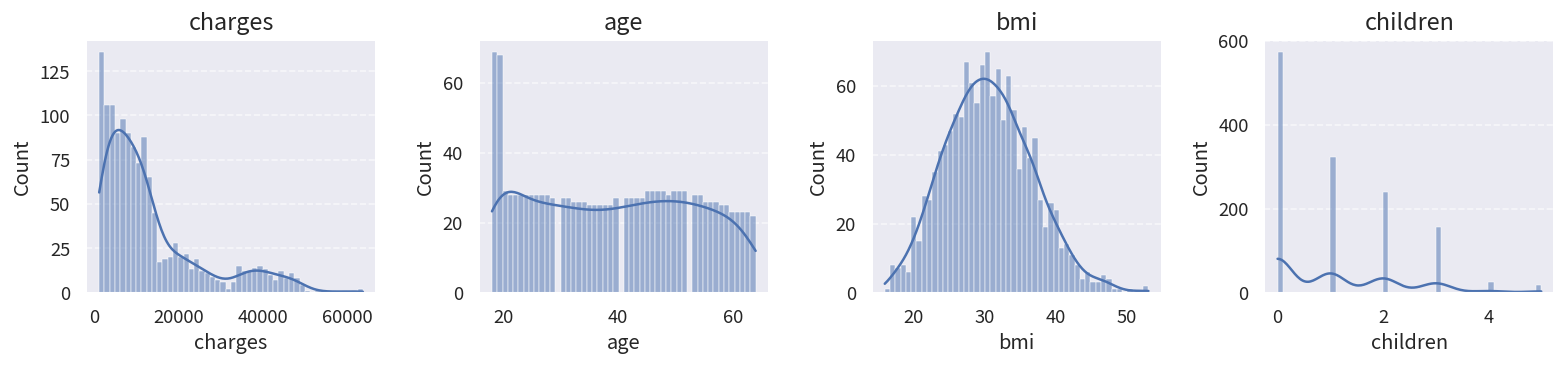

In [ ]:
# 1) 그래프 초기화
width_px = 1600
height_px = 400
rows, cols = 1, 4
figsize = (width_px / my_dpi, height_px / my_dpi)

fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

cols_list = ['charges', 'age', 'bmi', 'children']

# 2) 히스토그램 + KDE
for i, col in enumerate(cols_list):
    sb.histplot(
        data=df_plot,
        x=col,
        bins=50,
        kde=True,
        ax=ax[i]
    )
    ax[i].set_title(col, fontsize=14, fontweight='bold')
    ax[i].grid(axis='y', linestyle='--', alpha=0.6)

# 3) 출력
plt.tight_layout()
plt.show()
plt.close()


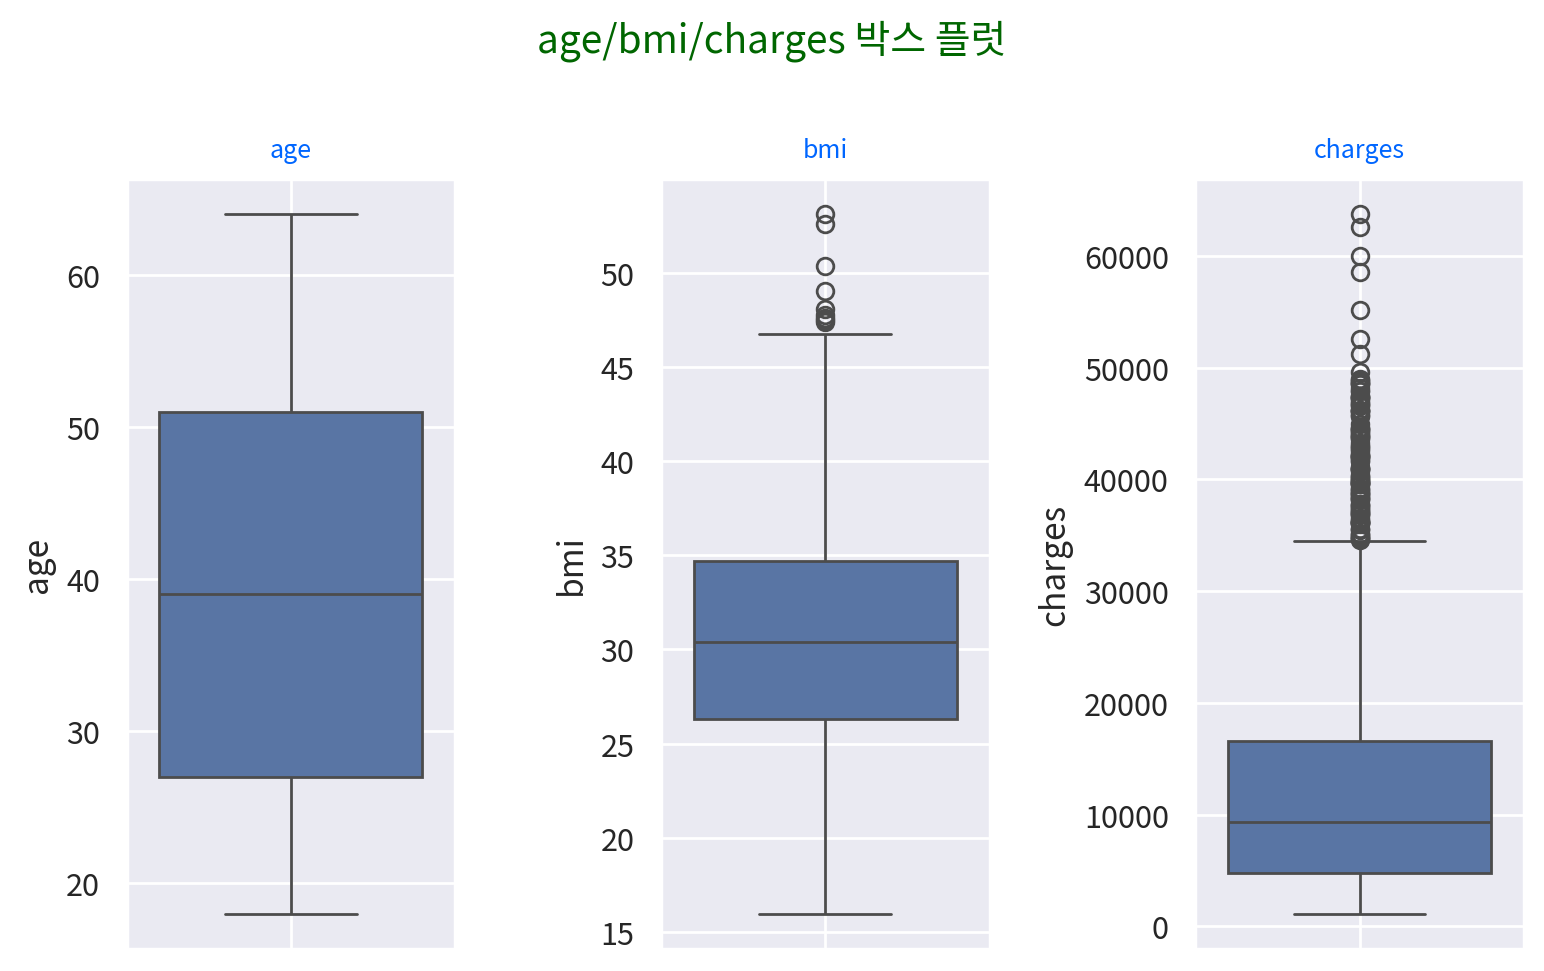

In [ ]:
# 1) 그래프 초기화 (캔버스(fig)와 도화지(ax) 준비하기)
width_px = 1600              # 가로 크기 늘림
height_px = 1000              # 세로 크기 줄임 (1행)
rows = 1
cols = 3
figsize = (width_px / 200, height_px / 200)

fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=200)

# 2) boxplot 그리기
sb.boxplot(data=df_plot, y='age', ax=ax[0])
sb.boxplot(data=df_plot, y='bmi', ax=ax[1])   # ✅ carat 추가
sb.boxplot(data=df_plot, y='charges', ax=ax[2])


# 3) 그래프 꾸미기
fig.suptitle('age/bmi/charges 박스 플럿', fontsize=14, color='#006600')

fig.subplots_adjust(wspace=0.3)

titles = ['age', 'bmi', 'charges']

for i in range(3):
    ax[i].set_title(titles[i], color="#0066ff", fontsize=9, pad=8)
    ax[i].grid()

# 4) 출력
plt.tight_layout()
plt.show()
plt.close()


### 범주형 변수
범주형 데이터 (sex , children, smoker, region)

여기서는 children을 범주형 취급하여 countplot을 그려줬음. 

In [ ]:
def make_category_summary(df, col):
    """
    범주형 변수(col)에 대해
    count / ratio / percent 요약 데이터프레임 생성
    """
    value_list = df[col].unique()
    counts = []

    for v in value_list:
        counts.append(len(df.query(f"{col} == @v")))

    summary_df = pd.DataFrame({
        col: value_list,
        'count': counts
    })

    total = summary_df['count'].sum()
    summary_df['ratio'] = summary_df['count'] / total
    summary_df['percent'] = (summary_df['ratio'] * 100).round(2)

    return summary_df

In [ ]:
sex_df      = make_category_summary(df_plot, 'sex')
children_df = make_category_summary(df_plot, 'children')
smoker_df   = make_category_summary(df_plot, 'smoker')
region_df   = make_category_summary(df_plot, 'region')

In [ ]:
sex_df

,sex,count,ratio,percent
0,female,662,0.494768,49.48
1,male,676,0.505232,50.52


In [ ]:
children_df

,children,count,ratio,percent
0,0,574,0.428999,42.90
1,1,324,0.242152,24.22
2,3,157,0.117339,11.73
3,2,240,0.179372,17.94
4,5,18,0.013453,1.35
5,4,25,0.018685,1.87


In [ ]:
smoker_df

,smoker,count,ratio,percent
0,yes,274,0.204783,20.48
1,no,1064,0.795217,79.52


In [ ]:
region_df

,region,count,ratio,percent
0,southwest,325,0.242900,24.29
1,southeast,364,0.272048,27.20
2,northwest,325,0.242900,24.29
3,northeast,324,0.242152,24.22


C:\Users\itwill\AppData\Local\Temp\ipykernel_21064\1357263062.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.countplot(data=categorical, x=v, ax=ax[i], palette='pastel')   # palette 적용 O? X?
C:\Users\itwill\AppData\Local\Temp\ipykernel_21064\1357263062.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.countplot(data=categorical, x=v, ax=ax[i], palette='pastel')   # palette 적용 O? X?
C:\Users\itwill\AppData\Local\Temp\ipykernel_21064\1357263062.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[num].set_xticklabels(labels=categorical[v].unique(), rotation=20)
C:\Users\itwill\AppData\Local\Temp\ipykernel_21064\135

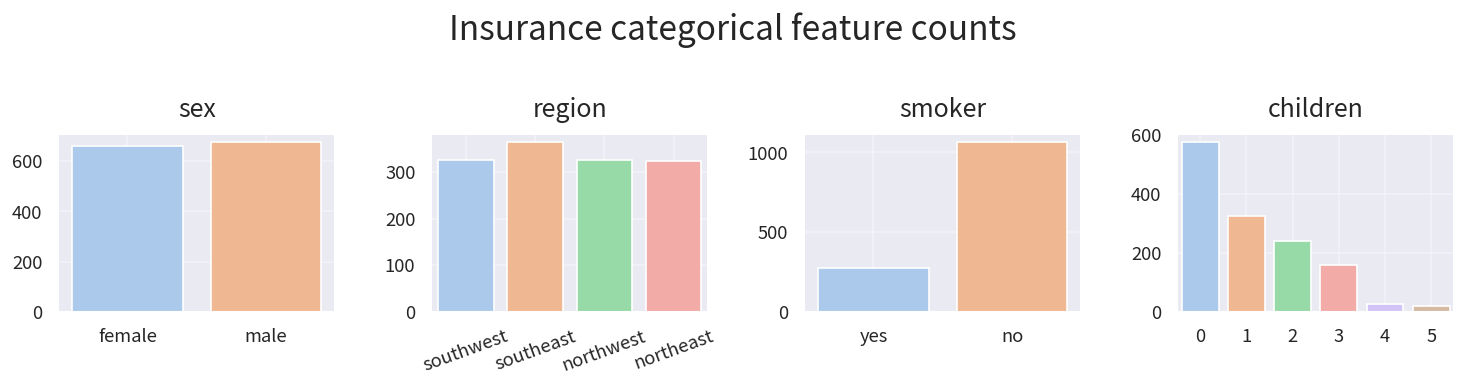

In [ ]:
# 4개의 명목형(?) 변수 카운트 플롯 그리기
categorical = origin.filter(['sex', 'region', 'smoker', 'children'])

# 1. 그래프 초기화
width_px = 1500
height_px = 400
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(1, 4, figsize=figsize, dpi=my_dpi)

# 2. 그래프 그리기
for i, v in enumerate(categorical.columns):
    sb.countplot(data=categorical, x=v, ax=ax[i], palette='pastel')   # palette 적용 O? X?
    ax[i].grid(True, alpha=0.4)
    ax[i].set_ylabel('')
    ax[i].set_xlabel('')
    ax[i].set_title(v, fontsize=15, pad=10)

    if len(categorical[v].unique()) == 4:
        num = i
        ax[num].set_xticklabels(labels=categorical[v].unique(), rotation=20)
    else:
        continue

# 전체 제목
fig.suptitle(
    'Insurance categorical feature counts',
    fontsize=20,
    fontweight='bold'
)

# 3. 그래프 출력
plt.tight_layout()
plt.show()
plt.close()

## 미션 2. 전처리
- charges, age, bmi, children 분포를 히스토그램/KDE로 확인하고 알 수 있는 객관적 사실을 서술한다. (그래프 하단에 서술)

- 왜도/이상치가 회귀에 줄 수 있는 영향과 변환 필요가 있는지 서술하시오.
  - 강한 왜도와 극단값을 가진 charges는 회귀 계수 추정을 왜곡하고 잔차의 비정규성 및 이분산성을 유발할 수 있다. 따라서 로그 변환을 통해 분포를 완화하는 것이 바람직하다. 반면 age와 bmi는 비교적 안정적인 분포를 보여 변환 필요성이 낮다.
  
- 분포 비교는 동일 스케일로 제시하고, 평균/중앙값/꼬리의 차이를 문장으로 요약하세요.
  - 분포 비교를 위해 연속형 변수(charges, age, bmi)에 Robust Scaling을 적용하여 동일한 스케일에서 확인하였다.그 결과, 스케일링 전후의 분포 형태는 동일하게 유지되었으며,ㅡ이는 Robust Scaling이 분포의 모양을 변화시키기보다는 중앙값과 IQR 기준으로 스케일만 조정하는 변환이기 때문이다. 따라서 charges는 평균이 중앙값보다 크고 오른쪽 꼬리가 긴 분포 특성을 유지한 반면, age와 bmi는 평균과 중앙값이 유사한 비교적 안정적인 분포를 보였다.

- 의료비의 long-tail 분포(극단적 고액 청구)가 해석에 미치는 영향도 짧게 언급하세요.
   - 의료비(charges)의 long-tail 분포로 인해 소수의 고액 청구 사례가 평균을 크게 끌어올리므로, 평균값만으로 의료비 수준을 해석할 경우 일반적인 가입자의 비용을 과대평가할 위험이 있다.
   - 의료비의 long-tail 분포는 평균 중심 해석을 왜곡하므로 중앙값 중심 해석이 필요하다.
- 
📌 출제 의도
목표변수·핵심 변수의 생김새를 먼저 읽고 변환 필요성을 스스로 판단하게 합니다. 숫자보다 해석 문장이 중요합니다.

1️⃣ charges
- 분포가 오른쪽으로 강하게 치우쳐 있다.
- 낮은 의료비 구간에 관측치가 밀집되어 있고, 고액 의료비는 소수만 존재한다.
- 분포의 오른쪽 꼬리가 길게 늘어져 있다.

2️⃣ age
- 전체 범위(약 18~64세)에 걸쳐 관측치가 고르게 분포한다.
- 특정 연령대에 데이터가 급격히 집중되거나 비어 있는 구간은 보이지 않는다.
- 분포 형태는 비교적 평탄하며 극단적인 왜도는 관찰되지 않는다.

3️⃣ bmi
- 단봉형 분포를 보이며, 중심은 약 30 전후에 위치한다.
- 오른쪽으로 약간 치우친 형태를 가진다.
- 매우 낮거나 매우 높은 bmi 값은 소수만 존재한다.

4️⃣ children
- 이산적인 값(0, 1, 2, …)에서만 관측치가 나타난다.
- 0명의 자녀를 가진 경우가 가장 많다.
- 자녀 수가 증가할수록 관측 빈도가 감소한다.

In [ ]:
scaler = RobustScaler()

for col in ['charges', 'age', 'bmi']:
    df_plot[f'{col}_robust'] = scaler.fit_transform(df_plot[[col]])


In [ ]:
df_plot[['charges', 'charges_robust',
         'age', 'age_robust',
         'bmi', 'bmi_robust']].describe()


,charges,charges_robust,age,age_robust,bmi,bmi_robust
count,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000
mean,13270.422265,0.326766,39.207025,0.008626,30.663397,0.031366
std,12110.011237,1.017680,14.049960,0.585415,6.098187,0.726191
min,1121.873900,-0.694153,18.000000,-0.875000,15.960000,-1.719559
25%,4740.287150,-0.390075,27.000000,-0.500000,26.296250,-0.488687
50%,9382.033000,0.000000,39.000000,0.000000,30.400000,0.000000
75%,16639.912515,0.609925,51.000000,0.500000,34.693750,0.511313
max,63770.428010,4.570597,64.000000,1.041667,53.130000,2.706758


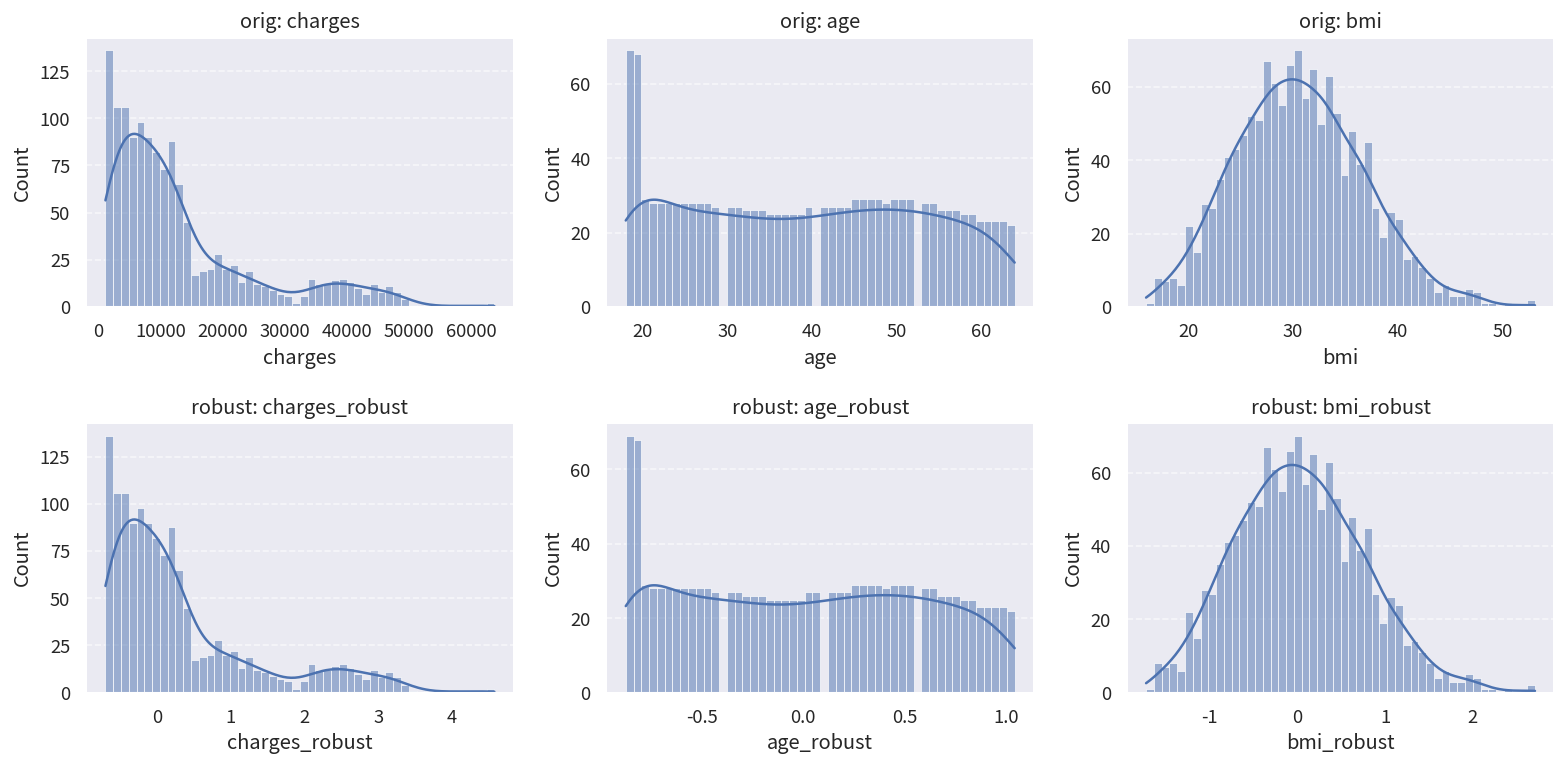

In [ ]:
from sklearn.preprocessing import RobustScaler

# Robust Scaling (원본 유지 + 새 컬럼)
scaler = RobustScaler()
for col in ['charges', 'age', 'bmi']:
    df_plot[f'{col}_robust'] = scaler.fit_transform(df_plot[[col]])

# 그래프 초기화: 2행 4열 (위=원본, 아래=robust)
width_px = 1600
height_px = 800
figsize = (width_px / my_dpi, height_px / my_dpi)

fig, ax = plt.subplots(2, 3, figsize=figsize, dpi=my_dpi)

orig_cols = ['charges', 'age', 'bmi']
scaled_cols = ['charges_robust', 'age_robust', 'bmi_robust']

# 원본(1행)
for i, col in enumerate(orig_cols):
    sb.histplot(data=df_plot, x=col, bins=50, kde=True, ax=ax[0, i])
    ax[0, i].set_title(f'orig: {col}', fontsize=12, fontweight='bold')
    ax[0, i].grid(axis='y', linestyle='--', alpha=0.6)

# 스케일링 후(2행)
for i, col in enumerate(scaled_cols):
    sb.histplot(data=df_plot, x=col, bins=50, kde=True, ax=ax[1, i])
    ax[1, i].set_title(f'robust: {col}', fontsize=12, fontweight='bold')
    ax[1, i].grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()
plt.close()


> “로그/비선형 변환
- charges 혹은 주요 변수(age, bmi, children)에 로그/제곱근 등 변환을 적용해 전·후 분포를 나란히 비교한다.
  - 결과적으로 charges 에만 log 변환을 적용해주었다.
  
- 변환이 해석과 모델 적합에 주는 장단점, 개선이 어떻게 달라지는지 예상한다.
  - 강한 오른쪽 왜도를 완화하여 분포를 보다 대칭적으로 만듦
  - 극단적 고액 의료비의 영향 감소
  - 잔차의 정규성·등분산성 개선 → 회귀 적합 안정화
  
- “이 변환 없으면 어떤 함정에 빠질까?”를 한 줄로 정리한다.
  - 로그 변환 없이 회귀를 수행하면 소수의 고액 의료비가 모델을 지배해 일반적인 의료비 수준을 왜곡해 예측할 위험이 있다.

- 선택 기준을 명시하세요. 왜 log(charges)인지, 왜 특정 변수에 변환을 적용했는지 데이터 분포 근거로 설명합니다.
  <charges 에 로그 변환을적용한 이유>
  - 히스토그램과 KDE에서 강한 오른쪽 왜도와 long-tail 분포 확인
  - 평균이 중앙값보다 현저히 큼
  - Robust scaling 후에도 꼬리 구조가 유지됨
  - age: 비교적 균등하고 안정적인 분포
  - bmi: 단봉형이며 약한 왜도만 존재 
  
- ※ 로그 변환은 의무가 아니며, 적용하지 않은 경우에도 그 선택의 이유와 결과적 한계를 명확히 설명하면 동일하게 평가합니다.

📌 출제 의도
단순히 변환을 쓰는 것이 아니라 **“왜 필요했는가, 해석이 어떻게 달라지는가”**를 설명하는 연습입니다.

- charges log 변환

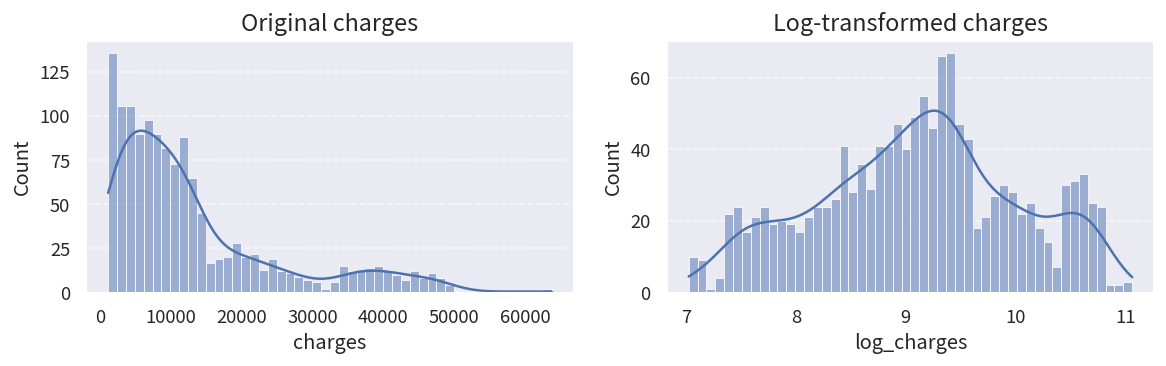

In [ ]:
import numpy as np
df_log = df_plot.copy()
# 원본 유지 + 로그 변환 컬럼 생성
df_log['log_charges'] = np.log(df_log['charges'])

# 1) 그래프 초기화
width_px = 1200
height_px = 400
rows, cols = 1, 2
figsize = (width_px / my_dpi, height_px / my_dpi)

fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

# 2) 원본 charges
sb.histplot(
    data=df_log,
    x='charges',
    bins=50,
    kde=True,
    ax=ax[0]
)
ax[0].set_title('Original charges', fontsize=14, fontweight='bold')
ax[0].grid(axis='y', linestyle='--', alpha=0.6)

# 3) 로그 변환 charges
sb.histplot(
    data=df_log,
    x='log_charges',
    bins=50,
    kde=True,
    ax=ax[1]
)
ax[1].set_title('Log-transformed charges', fontsize=14, fontweight='bold')
ax[1].grid(axis='y', linestyle='--', alpha=0.6)

# 4) 출력
plt.tight_layout()
plt.show()
plt.close()



## 미션 3. EDA
    - 변수 시각화를 진행한 결과 세 가지 변수(흡연 여부, 연령 그룹, 체질량지수)에서는 그룹 간 log(charges) 값의 명확한 차이가 발견되어 추가적인 분산분석과 사후검정을 수행하였음. 
### (1) 성별에 따른 의료비 분포 확인

1️⃣ 시각화: 성별·지역별 의료비 분포
(1) sex × charges (박스플롯 + 바이올린 플롯)
- 성별에 따른 의료비 분포를 보면, 남성과 여성의 중앙값은 유사하며 분포가 크게 겹쳐 있다.
남성 집단에서 고액 의료비 사례가 다소 더 넓게 분포하는 경향은 관찰되지만,
박스플롯과 바이올린 플롯 모두에서 중앙값과 주요 분포 구간의 차이는 뚜렷하지 않다.
따라서 성별 자체가 의료비를 명확히 구분하는 결정적 요인이라고 보기는 어렵다.

C:\Users\itwill\AppData\Local\Temp\ipykernel_21064\2706157786.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.boxplot(data=df_plot2, y='log_charges', x='sex', ax=ax[0], palette='pastel')
C:\Users\itwill\AppData\Local\Temp\ipykernel_21064\2706157786.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[0].legend(loc='lower right', fontsize=10)
C:\Users\itwill\AppData\Local\Temp\ipykernel_21064\2706157786.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.violinplot(data=df_plot2, y='log_charges', x='sex', ax=ax[1], palette='pastel')
C:\Users\itwill\AppData\Local\Temp\ipykerne

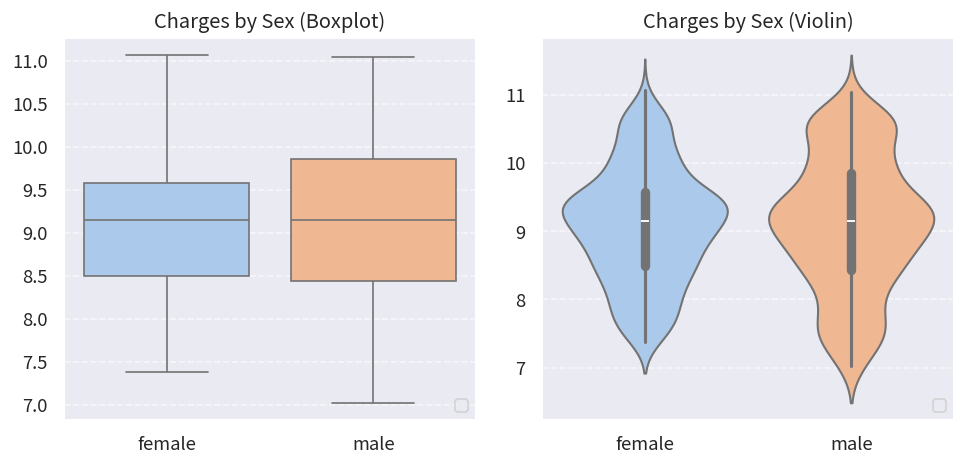

In [ ]:
df_plot2=df_log.copy()

# 1) 그래프 초기화
width_px, height_px = 1000, 500
figsize = (width_px / my_dpi, height_px / my_dpi)

fig, ax = plt.subplots(1, 2, figsize=figsize, dpi=my_dpi)

# 박스플롯
sb.boxplot(data=df_plot2, y='log_charges', x='sex', ax=ax[0], palette='pastel')
ax[0].set_title('Charges by Sex (Boxplot)')
ax[0].grid(axis='y', linestyle='--', alpha=0.6)
ax[0].set_xlabel('')
ax[0].set_ylabel('')
ax[0].legend(loc='lower right', fontsize=10)

# 바이올린 플롯
sb.violinplot(data=df_plot2, y='log_charges', x='sex', ax=ax[1], palette='pastel')
ax[1].set_title('Charges by Sex (Violin)')
ax[1].grid(axis='y', linestyle='--', alpha=0.6)
ax[1].set_xlabel('')
ax[1].set_ylabel('')
ax[1].legend(loc='lower right', fontsize=10)

plt.tight_layout()
plt.show()
plt.close()


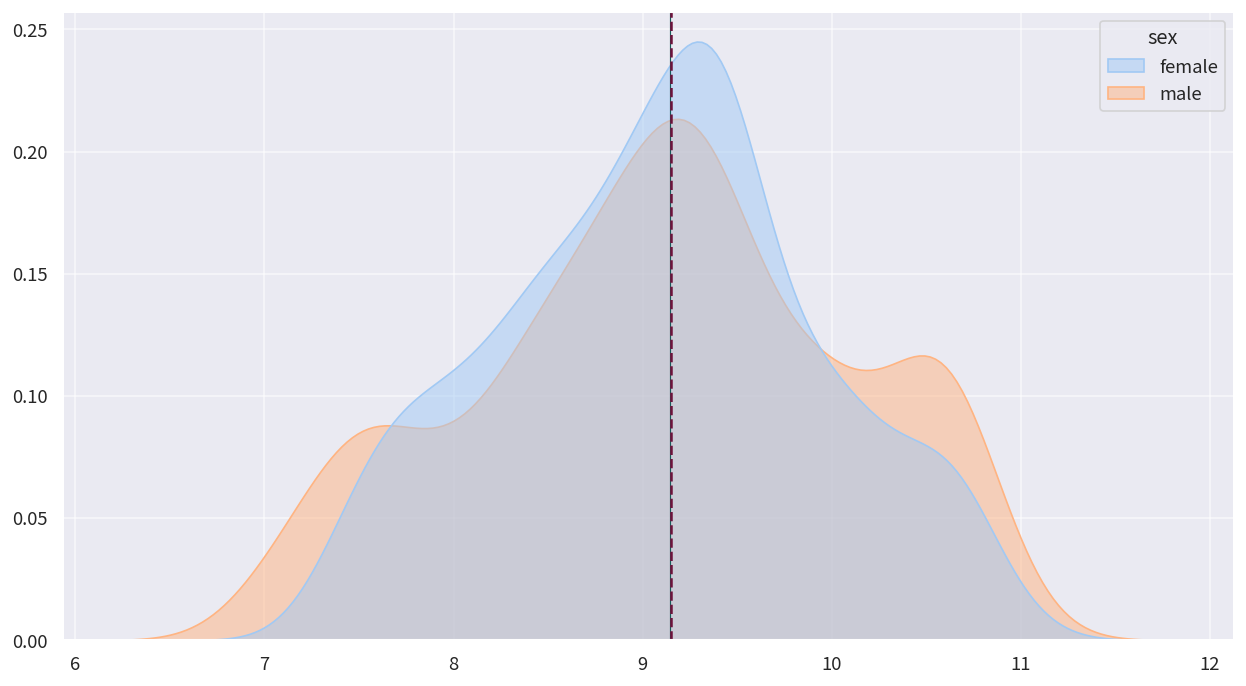

In [ ]:
# 1) 그래프 초기화
width_px = 1280
height_px = 720
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=my_dpi)


# 2) KDE Plot 그리기
sb.kdeplot(data=df_plot2, x='log_charges', fill=True, alpha=0.5, hue='sex', palette='pastel')
#sb.kdeplot(data=data)
male = df_plot2.query('sex == "male"')['log_charges']
female = df_plot2.query('sex == "female"')['log_charges']
ax.axvline(male.median(), linestyle="-", color="#185A5A", linewidth=0.7)
ax.axvline(female.median(), linestyle="--", color="#6E133C", linewidth=1.5)


# 3) 그래프 꾸미기
ax.grid(True, alpha=0.6)
ax.set_ylabel('')
ax.set_xlabel('')
#ax.set_title("성별에 따른 의료 보험료 분포 차이", fontsize=20, pad=15)

# 4) 그래프 출력
plt.tight_layout()
plt.show()
plt.close()

### (2)지역에 따른 의료비 분포 확인

(2) region × charges (박스플롯 + 바이올린 플롯)
- 지역별 의료비 분포를 비교한 결과,
네 지역의 중앙값은 서로 큰 차이를 보이지 않으며,
분포 또한 상당 부분 겹쳐 있다.
다만 southeast 지역에서 고액 의료비 사례가
상대적으로 눈에 띄게 관찰되지만,
이를 근거로 지역 간 의료비 차이가 뚜렷하다고 단정하기는 어렵다.

C:\Users\itwill\AppData\Local\Temp\ipykernel_21064\3583130948.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.boxplot(data=df_plot2, x='region', y='log_charges', ax=ax[0], palette='pastel')
C:\Users\itwill\AppData\Local\Temp\ipykernel_21064\3583130948.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.violinplot(data=df_plot2, x='region', y='log_charges', ax=ax[1], palette='pastel')


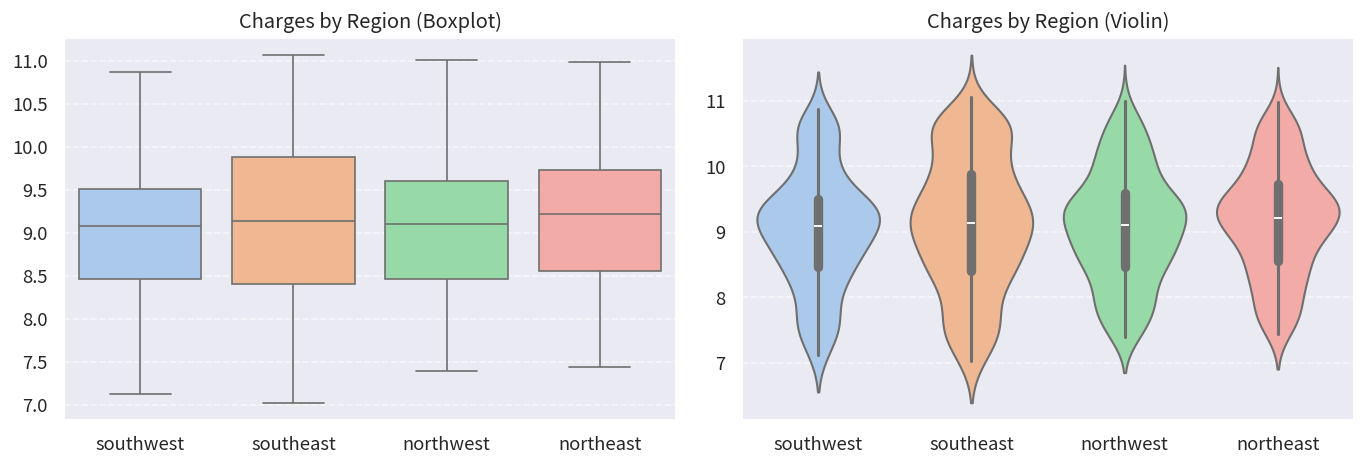

In [ ]:
# 1) 그래프 초기화
width_px, height_px = 1400, 500
figsize = (width_px / my_dpi, height_px / my_dpi)

fig, ax = plt.subplots(1, 2, figsize=figsize, dpi=my_dpi)

# 박스플롯
sb.boxplot(data=df_plot2, x='region', y='log_charges', ax=ax[0], palette='pastel')
ax[0].set_title('Charges by Region (Boxplot)')
ax[0].tick_params(axis='x')
ax[0].set_xlabel('')
ax[0].set_ylabel('')
ax[0].grid(axis='y', linestyle='--', alpha=0.6)

# 바이올린 플롯
sb.violinplot(data=df_plot2, x='region', y='log_charges', ax=ax[1], palette='pastel')
ax[1].set_title('Charges by Region (Violin)')
ax[1].tick_params(axis='x')
ax[1].set_xlabel('')
ax[1].set_ylabel('')
ax[1].grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()
plt.close()


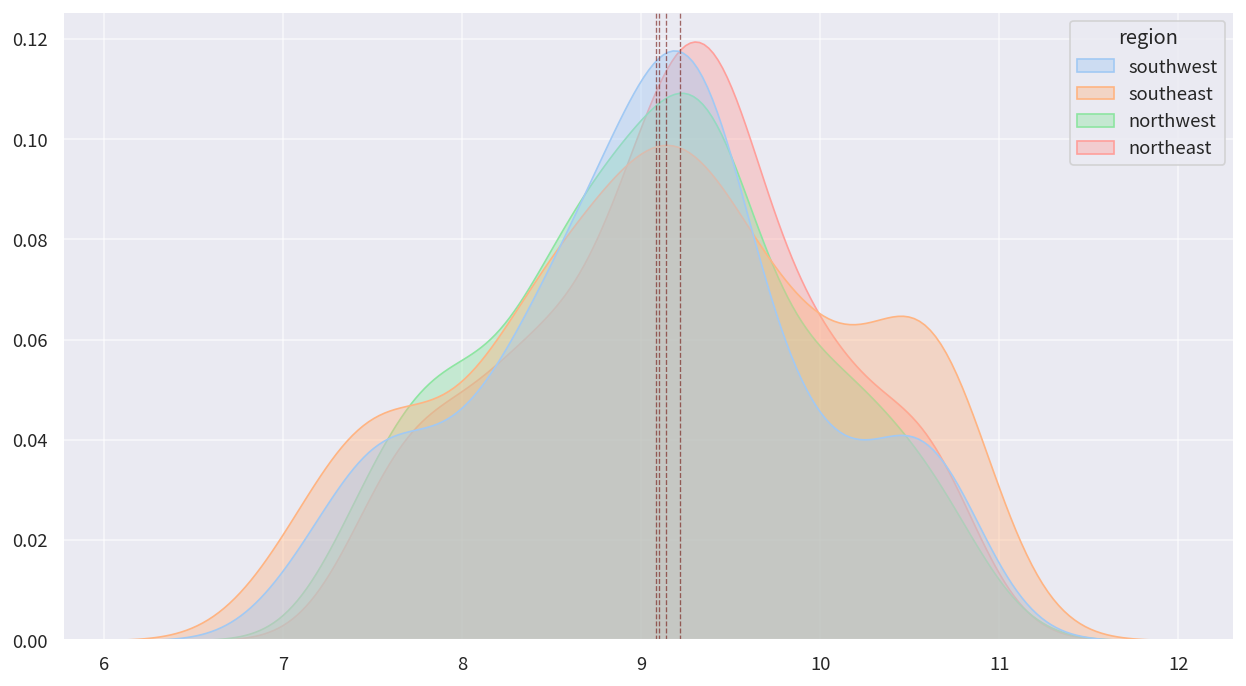

In [ ]:
# 1) 그래프 초기화
width_px = 1280
height_px = 720
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=my_dpi)

# 2) KDE Plot 그리기
sb.kdeplot(data=df_plot2, x='log_charges', fill=True, alpha=0.4, hue='region', palette='pastel')
#sb.kdeplot(data=data)
for r in (['northwest', 'northeast', 'southwest', 'southeast']):
    region_data = df_plot2.query('region == @r')['log_charges']
    ax.axvline(region_data.median(), linestyle='--', color="#741913A0", linewidth=0.8)


# 3) 그래프 꾸미기
ax.grid(True, alpha=0.6)
ax.set_ylabel('')
ax.set_xlabel('')
#ax.set_title("성별에 따른 의료 보험료 분포 차이", fontsize=20, pad=15)

# 4) 그래프 출력
plt.tight_layout()
plt.show()
plt.close()

다시 말해 성별과 지역 변수는 단독으로 의료 보험료의 변동을 명확하게 설명하지 못할 가능성이 높다. 그러나 이는 다른 가격 결정 요인을 통제하지 않은 상태에서 도출된 결과이므로, 조건부 관계에서는 상이한 결과가 나타날 가능성이 있다. 따라서 성별과 지역 변수의 효과는 이후 다중선형회귀 모형을 통해 추가적으로 검토할 예정이다.

### (3) 흡연 여부에 따른 의료비 분포 확인

(3) smoker × charges (박스플롯 + 바이올린 플롯)
- 흡연 여부에 따른 의료비 분포를 박스플롯과 바이올린 플롯으로 시각화한 결과,
  흡연자(smoker = yes)는 비흡연자(smoker = no)에 비해 의료비의 중앙값과 분포 중심이 현저히 높게 나타났다.또한 흡연자 집단은 **고액 의료비 방향으로 긴 꼬리(long-tail)**를 가지며,
  두 집단의 분포는 겹침이 매우 제한적으로 시각적으로도 뚜렷한 차이를 보였다.

In [ ]:
insurance_smoker = df_plot2.filter(['smoker', 'log_charges'])
insurance_smoker.head()

,smoker,log_charges
0,yes,9.734176
1,no,7.453302
2,no,8.400538
3,no,9.998092
4,no,8.260197


C:\Users\itwill\AppData\Local\Temp\ipykernel_21064\2711185481.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.boxplot(data=insurance_smoker, y='log_charges', x='smoker', ax=ax[0], palette='pastel')
C:\Users\itwill\AppData\Local\Temp\ipykernel_21064\2711185481.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[0].legend(loc='lower right')
C:\Users\itwill\AppData\Local\Temp\ipykernel_21064\2711185481.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.violinplot(data=insurance_smoker, y='log_charges', x='smoker', ax=ax[1], palette='pastel')
C:\Users\itwill\AppData\Local\Temp\

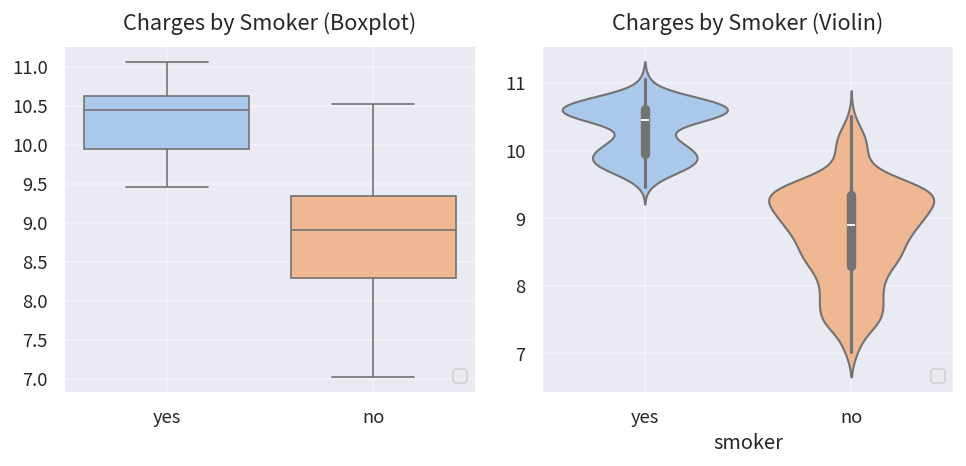

In [ ]:
# hue가 흡연 여부일 때의 보험료 분포 알아보기 (바이올린 & 박스 플롯)
width_px = 1000
height_px = 500
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(1, 2, figsize=figsize, dpi=my_dpi)

sb.boxplot(data=insurance_smoker, y='log_charges', x='smoker', ax=ax[0], palette='pastel')
ax[0].grid(True, alpha=0.4)
ax[0].set_xlabel('')
ax[0].set_ylabel('')
ax[0].set_title(f"Charges by Smoker (Boxplot)", fontsize=13, pad=10)
ax[0].legend(loc='lower right')

sb.violinplot(data=insurance_smoker, y='log_charges', x='smoker', ax=ax[1], palette='pastel')
ax[1].grid(True, alpha=0.4)
ax[0].set_xlabel('')
ax[1].set_ylabel('')
ax[1].set_title(f"Charges by Smoker (Violin)", fontsize=13, pad=10)
#ax[0].set_yticks([7.0, 7.5, 8.0, 8.5, 9.0, 9.5, 10.0, 10.5, 11.0])
ax[1].legend(loc='lower right')

plt.tight_layout()
plt.show()
plt.close()

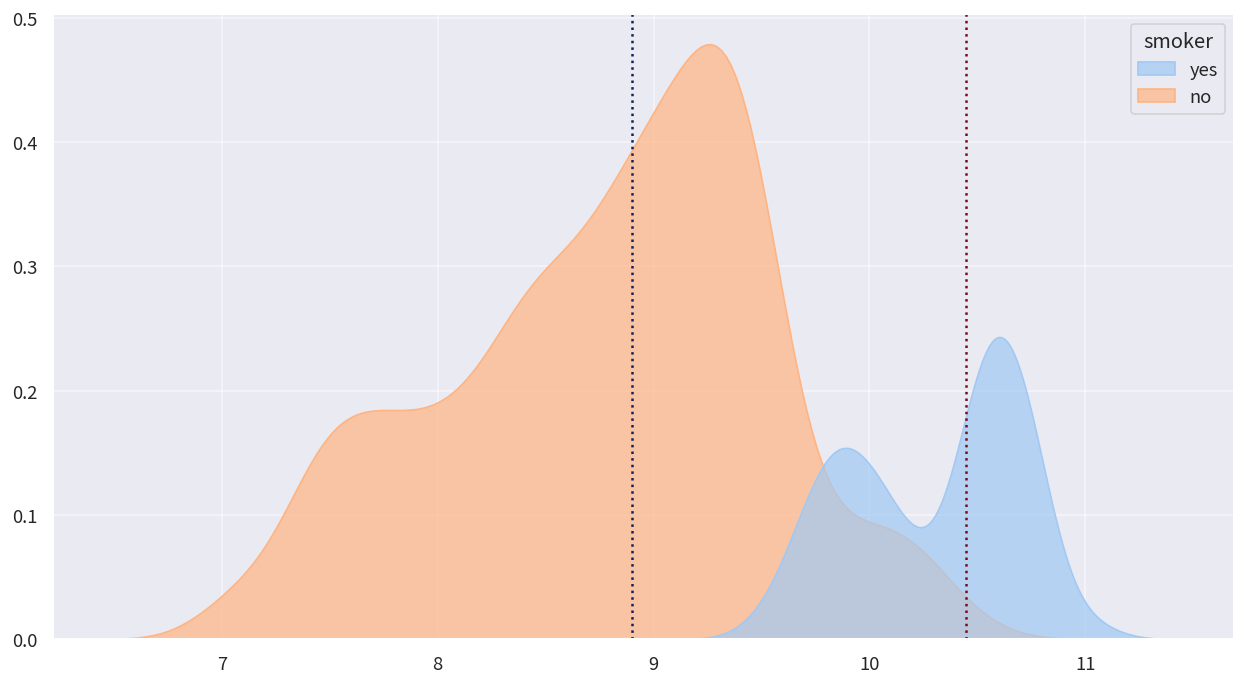

In [ ]:
# 1) 그래프 초기화
width_px = 1280
height_px = 720
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=my_dpi)

# 2) KDE Plot 그리기
sb.kdeplot(data=insurance_smoker, x='log_charges', hue='smoker', fill=True, alpha=0.7, palette='pastel')
#sb.kdeplot(data=data)
smoke_yes = insurance_smoker.query('smoker == "yes"')['log_charges']
smoke_no = insurance_smoker.query('smoker == "no"')['log_charges']
ax.axvline(smoke_no.median(), linestyle=":", color="#13225F", linewidth=1.5)
ax.axvline(smoke_yes.median(), linestyle=":", color="#7A0C15", linewidth=1.5)

# 3) 그래프 꾸미기
ax.grid(True, alpha=0.5)
# 그래프 안에서 각각의 kde 선에 제목 달기
ax.set_xlabel('')
ax.set_ylabel('')
#ax.set_title("흡연 여부에 따른 의료 보험료 분포 차이", fontsize=20, pad=15)

# 6) 그래프 출력
plt.tight_layout()
plt.show()
plt.close()

#### 독립 표본 t-test 실시

흡연 여부에 따른 평균 차이의 유의미성 확인 

그러나 이것만으로는 위의 결과가 해당 데이터에서만 우연하게 발생한 것인지 실제로도 유의미한 것인지 알 수 없다. 따라서 t 검정을 통해 해당 결과가 통계적으로 유의하다고 말할 수 있는지 확인할 필요가 있다.

> 정규성과 등분산성을 충족하지 않아 mannwhitneyu 비모수 검정을 진행해야한다

| 구분        | 기호      | 내용                                 |
| --------- | ------- | ---------------------------------- |
| 그룹 1 평균   | μ₁      | 흡연자(smoker = yes)의 의료비(charges) 평균 |
| 그룹 2 평균   | μ₂      | 비흡연자(smoker = no)의 의료비(charges) 평균 |
| 귀무가설 (H₀) | μ₁ = μ₂ | 흡연자와 비흡연자의 의료비 평균에는 차이가 없다         |
| 대립가설 (H₁) | μ₁ ≠ μ₂ | 흡연자와 비흡연자의 의료비 평균에는 차이가 있다         |

- 효과 크기(차이의 크기)를 함께 제시하고, “실제로 의미 있는 차이인가?”를 말로 해석하세요.
  - Welch’s t-test 결과는 다음과 같다
  t-statistic = −32.75
  p-value ≈ 0 (p < 0.001)
  p-value가 유의수준 0.05보다 매우 작으므로 귀무가설을 기각한다.
  즉, 비흡연자의 평균 의료비는 흡연자보다 통계적으로 유의하게 작다,
  다시 말해 흡연 여부에 따라 의료비 평균에는 매우 유의한 차이가 존재한다고 할 수 있다.


- 정규성/등분산 가정 점검 후 필요 시 Welch’s t-test나 비모수 검정을 선택하세요.
  - 정규성 검정 결과, 흡연자와 비흡연자 두 집단 모두 정규성 가정을 충족하지 않았으며,
  Levene 검정을 통해 등분산성 가정 역시 충족되지 않음을 확인하였다.
  이에 따라 등분산을 가정하지 않는 Welch’s t-test를 사용하여
  두 집단의 평균 의료비 차이를 검정하였다.

- 효과 크기를 의료 정책 관점에서 의미를 서술합니다.
  - 흡연자는 비흡연자에 비해 평균적으로 훨씬 높은 의료비를 발생시키므로,
  흡연은 개인의 건강 문제를 넘어 의료 시스템 전체의 비용 부담을 증가시키는 요인으로 해석할 수 있다.
  이러한 결과는 금연 정책, 예방 중심의 공공 보건 전략,
  그리고 흡연 관련 건강 관리 프로그램의 필요성을 뒷받침하는 근거로 활용될 수 있다.

- 📌 출제 의도
두 집단 비교에서 방법 선택과 효과 크기 해석을 연습하고, 숫자를 의미로 번역하게 합니다.

In [ ]:
insurance_smoker

,smoker,log_charges
0,yes,9.734176
1,no,7.453302
2,no,8.400538
3,no,9.998092
4,no,8.260197
...,...,...
1333,no,9.268661
1334,no,7.698927
1335,no,7.396233
1336,no,7.604867


- [3] 가설 검정의 가정 확인

In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import normaltest, bartlett, levene

normal_dist = True
report = []
data_list = []

for yn in ['yes', 'no']:
    data = insurance_smoker.query('smoker == @yn')['log_charges']
    s, p = normaltest(data)
    normalize = p > 0.05
    data_list.append(data)   # 후에 있을 등분산성 검정을 위한 데이터 저장
    report.append({"field": f"smoker_{yn}", "statistic": s, "p-value": p, "result": normalize})
    normal_dist = normal_dist and normalize

# 등분산 검정 (두 집단)
if normal_dist:
    n = "Bartlett"
    s, p = bartlett(*data_list)
else:
    n = "Levene"
    s, p = levene(*data_list, center='median')

report.append({"field": n, "statistic": s, "p-value": p, "result": p > 0.05})

report_df = pd.DataFrame(report).set_index('field')
report_df


,statistic,p-value,result
field,,,
smoker_yes,182.429884,2.431387e-40,False
smoker_no,37.441016,7.409463e-09,False
Levene,89.496182,1.332619e-20,False


In [ ]:
from scipy import stats

# Welch's t-test (equal_var=False)
s, p = stats.mannwhitneyu(insurance_smoker.query('smoker == "yes"')['log_charges'], 
                     insurance_smoker.query('smoker == "no"')['log_charges']
)

print(
    "statistic: {0:.3f}, p-value: {1:.3e}, {2}가설 채택"
    .format(s, p, "대립" if p <= 0.05 else "귀무")
)

statistic: 284133.000, p-value: 5.270e-130, 대립가설 채택


> Mann-Whitney U Test 결과, 흡연자와 비흡연자의 평균 의료비 차이는 통계적으로 매우 유의하였다
(검정통계량 = 284133.000, p < 0.00... ).
유의확률이 유의수준 0.05보다 작기때문에 귀무가설을 기각하고, 흡연 여부에 따라 의료비 평균에 차이가 있다는 대립가설을 채택한다.

- 비흡연자의 의료비가 흡연자의 의료비보다 작은지 검정
(= 흡연자가 더 비싼지 검정)

| 구분        | 수식             | 내용                         |
| --------- | -------------- | -------------------------- |
| 귀무가설 (H₀) | μ(no) ≥ μ(yes) | 비흡연자의 평균 의료비는 흡연자보다 작지 않다  |
| 대립가설 (H₁) | μ(no) < μ(yes) | **비흡연자의 평균 의료비는 흡연자보다 작다** |


In [ ]:
s, p = stats.mannwhitneyu(insurance_smoker.query('smoker == "no"')['log_charges'], 
                     insurance_smoker.query('smoker == "yes"')['log_charges'],
                     alternative='less'
)

print(
    "statistic: {0:.3f}, p-value: {1:.3e}, {2}가설 채택"
    .format(s, p, "대립" if p <= 0.05 else "귀무")
)

statistic: 7403.000, p-value: 2.635e-130, 대립가설 채택


- Mann-Whitney U Test 결과, 두 집단의 평균 의료비 차이는 통계적으로 유의하였다
(검정통계량 = 7403.000 , p-value = 0.00...).
이에 따라 비흡연자의 평균 의료비는 흡연자보다 유의하게 작다고 판단된다.

#### +) 흡연율은?

- 성별에 따른 흡연율
  
| 성별     | 흡연율 (%) |
| ------ | ------: |
| Female |    17.4 |
| Male   |    23.5 |


- 지역에 따른 흡연율 
  
| 지역        | 흡연율 (%) |
| --------- | ------: |
| Northeast |    20.7 |
| Northwest |    17.8 |
| Southeast |    25.0 |
| Southwest |    17.8 |


- BMI 그룹에 따른 흡연율 
  
| BMI 그룹      | 흡연율 (%) |
| ----------- | ------: |
| Underweight |    25.0 |
| Normal      |    22.2 |
| Overweight  |    19.2 |
| Obese       |    20.5 |


- 연령대에 따른 흡연율
  
| 연령대   |        흡연율 (%) |
| ----- | -------------: |
| 18–24 |           21.6 |
| 25–34 |           20.7 |
| 35–44 |           23.5 |
| 45–64 |           18.3 |

In [ ]:
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

# 0) 흡연율(%) 계산 함수
def make_smoke_rate_df(df, group_col, smoker_col='smoker'):
    out = (
        df.assign(smoke_yes=df[smoker_col].eq('yes').astype(int))
          .groupby(group_col, dropna=False)
          .agg(total=('smoke_yes', 'size'),
               smokers=('smoke_yes', 'sum'))
          .reset_index()
    )
    out['smoke_rate'] = out['smokers'] / out['total'] * 100
    return out


# 1) 변수별 흡연율 df 만들기
sex_rate_df      = make_smoke_rate_df(df_plot2, 'sex')
region_rate_df   = make_smoke_rate_df(df_plot2, 'region')
bmi_rate_df      = make_smoke_rate_df(df_plot2, 'bmi_group')
age_rate_df      = make_smoke_rate_df(df_plot2, 'age_group')
children_rate_df = make_smoke_rate_df(df_plot2, 'children')


# (선택) 보기 좋게 범주 순서 고정
bmi_order = ['Underweight', 'Normal', 'Overweight', 'Obese']
age_order = ['18-24', '25-34', '35-44', '45-64']  # 네가 65+ 만들었으면
# children은 숫자라 자동 정렬되는데 혹시 문자열이면 아래처럼:
# children_order = sorted(children_rate_df['children'].unique())

# 2) 그래프 초기화 (rows=5)
width_px = 900
height_px = 2400
rows, cols = 5, 1
figsize = (width_px / 200, height_px / 200)

fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=200)

plot_info = [
    (sex_rate_df,      'sex',       'Smoking rate by Sex',       None),
    (region_rate_df,   'region',    'Smoking rate by Region',    None),
    (bmi_rate_df,      'bmi_group', 'Smoking rate by BMI group', bmi_order),
    (age_rate_df,      'age_group', 'Smoking rate by Age group', age_order),
    (children_rate_df, 'children',  'Smoking rate by Children',  None),
]

# 3) barplot 그리기 (y='smoke_rate')
for i, (df, x_col, title, order) in enumerate(plot_info):
    sb.barplot(
        data=df,
        x=x_col,
        y='smoke_rate',
        order=order,
        ax=ax[i]
    )

    ax[i].grid(axis='y', linestyle='--', alpha=0.7)
    ax[i].set_xlabel('')
    ax[i].set_ylabel('Smoking rate (%)', fontsize=12)
    ax[i].set_title(title, fontsize=16, fontweight='bold')
    ax[i].tick_params(axis='x', labelsize=12)
    ax[i].tick_params(axis='y', labelsize=11)

    # y축 범위 (0~100% 중 필요한 범위로 보기 좋게)
    ax[i].set_ylim(0, 100)

    # (선택) 막대 위에 퍼센트 표시
    for p in ax[i].patches:
        h = p.get_height()
        ax[i].annotate(f'{h:.1f}%',
                       (p.get_x() + p.get_width()/2, h),
                       ha='center', va='bottom', fontsize=10,
                       xytext=(0, 3), textcoords='offset points')

fig.suptitle('Smoking rate by categorical variables', fontsize=20, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
plt.close()

KeyError: 'bmi_group'

### (4) 연령 그룹에 따른 의료비 분포 확인
- age를 여러 구간으로 나누어(예: 18~30, 31~50, 51+) 각 연령대별 charges 분포를 시각화한다.
  - 연령대를 NCHS(미국 국립보건통계센터) Distribution #22 기준에 따라
  18–24세, 25–34세, 35–44세, 45–64세의 네 개 구간으로 구분하여
  각 연령대별 의료비(charges) 분포를 시각화하였다.

  그 결과, 연령이 증가할수록 의료비의 중앙값(median) 이 점진적으로 상승하는 경향이 관찰되었으며,동시에 분포의 상단(고액 의료비 영역) 또한 점차 확장되는 모습을 보였다.특히 45–64세 연령대에서는 분포의 꼬리가 길어지며,
  고액 의료비 사례가 다른 연령대에 비해 상대적으로 많이 나타났다.

  이는 연령 증가에 따라 만성질환 유병률과 의료 이용 빈도가 함께 증가할 가능성을 시사한다.

- 분산분석(ANOVA)으로 전체 차이를 확인하고, 사후검정으로 어느 연령대 사이에서 차이가 나는지 정리한다.
  - Welch ANOVA 결과, 연령대에 따라 평균 의료비는 통계적으로 유의미한 차이를 보였다
  (F = 36.77, p < 0.001).
  이는 연령대가 의료비 변동을 설명하는 중요한 요인임을 의미하며,
  단순한 우연이 아닌 구조적인 차이가 존재함을 시사한다.


- 사후검정은 Tukey HSD 또는 Games-Howell(등분산 위반 시)을 사용하고, “의료비 연령 서열표” 형태로 요약하세요.

| 연령대       | 평균 의료비 수준 | 해석                   |
| --------- | --------- | -------------------- |
| **18–24** | 가장 낮음     | 의료 이용 및 비용 부담이 가장 적음 |
| **25–34** | 낮음        | 의료비 증가 시작 단계         |
| **35–44** | 중간        | 의료 이용 및 비용이 본격적으로 증가 |
| **45–64** | 가장 높음     | 고액 의료비 위험이 가장 큼      |

  연령 서열:
  18–24 < 25–34 < 35–44 < 45–64

** 분석 대상의 연령 구간은 NCHS(미국 국립보건통계센터)의 Distribution #22 분류 체계에 따라 18-24세, 25-34세, 35-44세, 45-64세의 4개 그룹으로 층화(stratified) 하였다 (해당 기준은 미국 보건·의료 통계 및 보험 관련 연구에서
연령에 따른 건강 상태와 의료 이용 패턴을 비교하기 위해
널리 활용되는 생애 단계 기반 분류이다.)

- 출제 의도
여러 범주를 전체→어디서 차이가 나는지 순서로 해석하며, 결과를 서열/지도처럼 정리하는 훈련입니다.

In [ ]:
df_age = df_plot2.copy()

- age 구간 나누기

In [ ]:
# NCHS 기준 age 구간화
df_add_age_bmi_standard=df_log.copy()

bins = [18, 24, 34, 44, 64]
labels = ['18-24', '25-34', '35-44', '45-64']

df_add_age_bmi_standard['age_group'] = pd.cut(
    df_add_age_bmi_standard['age'],
    bins=bins,
    labels=labels,
    include_lowest=True,
    right=True
)

#df_age[['age', 'age_group']].head()

# who 기준
bmi_bins = [0, 18.5, 25, 30, float('inf')]
bmi_labels = ['Underweight', 'Normal', 'Overweight', 'Obese']

df_add_age_bmi_standard['bmi_group'] = pd.cut(
    df_add_age_bmi_standard['bmi'],
    bins=bmi_bins,
    labels=bmi_labels,
    include_lowest=True,
    right=False
)

df_add_age_bmi_standard

,age,sex,bmi,children,smoker,region,charges,charges_robust,age_robust,bmi_robust,log_charges,age_group,bmi_group
0,19,female,27.900,0,yes,southwest,16884.92400,0.630515,-0.833333,-0.297708,9.734176,18-24,Overweight
1,18,male,33.770,1,no,southeast,1725.55230,-0.643422,-0.875000,0.401310,7.453302,18-24,Obese
2,28,male,33.000,3,no,southeast,4449.46200,-0.414515,-0.458333,0.309616,8.400538,25-34,Obese
3,33,male,22.705,0,no,northwest,21984.47061,1.059062,-0.250000,-0.916344,9.998092,25-34,Normal
4,32,male,28.880,0,no,northwest,3866.85520,-0.463475,-0.291667,-0.181006,8.260197,25-34,Overweight
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830,0.102399,0.458333,0.067877,9.268661,45-64,Obese
1334,18,female,31.920,0,no,northeast,2205.98080,-0.603049,-0.875000,0.181006,7.698927,18-24,Obese
1335,18,female,36.850,0,no,southeast,1629.83350,-0.651466,-0.875000,0.768086,7.396233,18-24,Obese
1336,21,female,25.800,0,no,southwest,2007.94500,-0.619691,-0.750000,-0.547782,7.604867,18-24,Overweight


In [ ]:
df_plot2 = df_add_age_bmi_standard.copy()

C:\Users\itwill\AppData\Local\Temp\ipykernel_14196\918040383.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.boxplot(data=df_plot2, x='age_group', y='log_charges', ax=ax[0],palette='pastel')
C:\Users\itwill\AppData\Local\Temp\ipykernel_14196\918040383.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.violinplot(data=df_plot2, x='age_group', y='log_charges', ax=ax[1],palette='pastel')


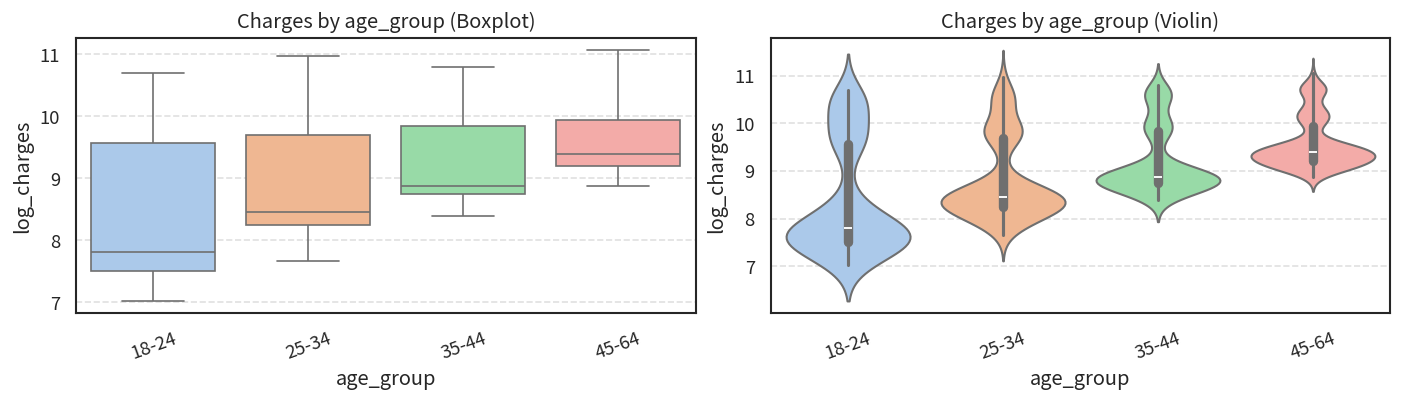

In [ ]:
# 1) 그래프 초기화
width_px, height_px = 1400, 400
figsize = (width_px / my_dpi, height_px / my_dpi)

fig, ax = plt.subplots(1, 2, figsize=figsize, dpi=my_dpi)

# 박스플롯
sb.boxplot(data=df_plot2, x='age_group', y='log_charges', ax=ax[0],palette='pastel')
ax[0].set_title('Charges by age_group (Boxplot)')
ax[0].tick_params(axis='x', rotation=20)
ax[0].grid(axis='y', linestyle='--', alpha=0.6)

# 바이올린 플롯
sb.violinplot(data=df_plot2, x='age_group', y='log_charges', ax=ax[1],palette='pastel')
ax[1].set_title('Charges by age_group (Violin)')
ax[1].tick_params(axis='x', rotation=20)
ax[1].grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()
plt.close()

- 데이터 분포 및 가정 확인
- [1] 데이터 분포

In [ ]:
# df_age: age, age_group(18-24 / 25-34 / 35-44 / 45-64) 포함

age_18_24 = df_plot2.loc[df_plot2['age_group'] == '18-24', 'log_charges']
age_25_34 = df_plot2.loc[df_plot2['age_group'] == '25-34', 'log_charges']
age_35_44 = df_plot2.loc[df_plot2['age_group'] == '35-44', 'log_charges']
age_45_64 = df_plot2.loc[df_plot2['age_group'] == '45-64', 'log_charges']

data = pd.DataFrame({
    '18-24': age_18_24,
    '25-34': age_25_34,
    '35-44': age_35_44,
    '45-64': age_45_64
})

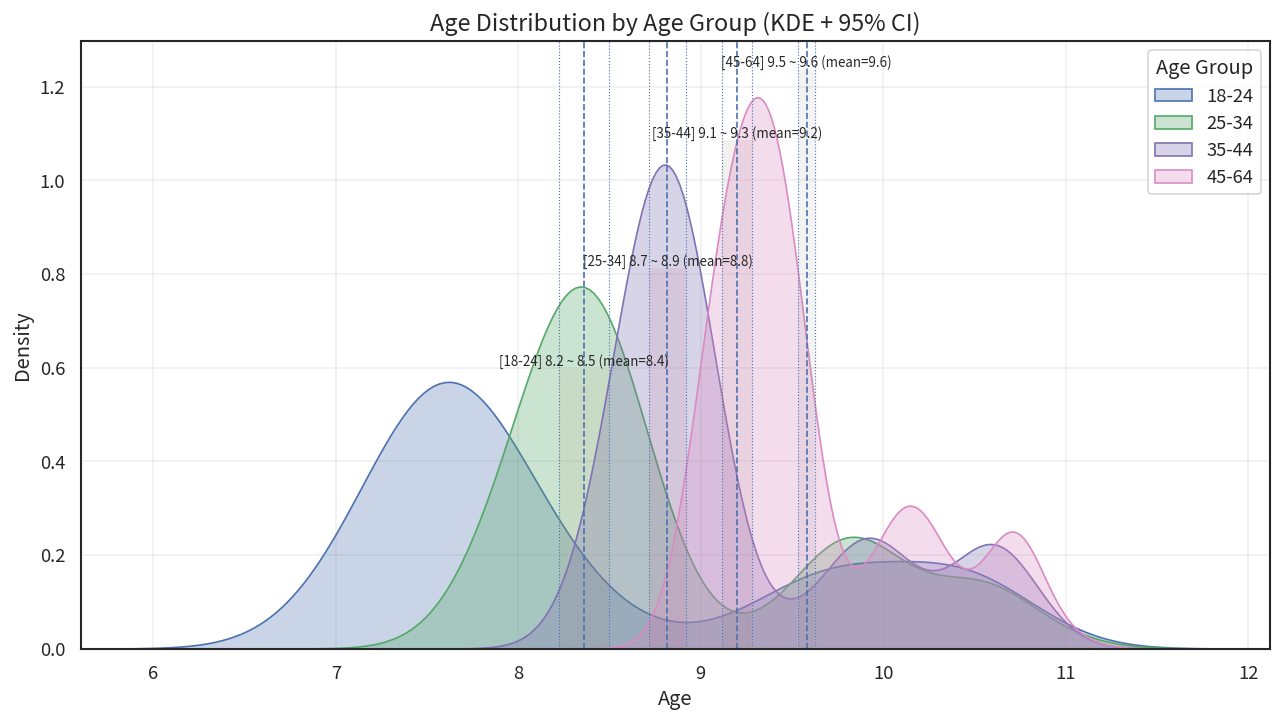

In [ ]:
from math import sqrt
from scipy.stats import t

# 1) 그래프 초기화
width_px  = 1280
height_px = 720
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=my_dpi)

for c in data.columns:
    series = data[c].dropna()   # NaN 제거

    # KDE Plot
    sb.kdeplot(x=series, fill=True, alpha=0.3, label=c)

    # 신뢰구간 계산
    clevel = 0.95
    dof = len(series) - 1
    sp_mean = series.mean()
    sp_std = series.std(ddof=1)
    sp_std_error = sp_std / sqrt(len(series))

    cmin, cmax = t.interval(clevel, dof, loc=sp_mean, scale=sp_std_error)

    # 시각화
    ax.axvline(cmin, linestyle=':', linewidth=0.7)
    ax.axvline(cmax, linestyle=':', linewidth=0.7)
    ax.axvline(sp_mean, linestyle='--', linewidth=1)

    ymin, ymax = ax.get_ylim()
    ax.fill_between([cmin, cmax], 0, ymax, alpha=0.1)

    ax.text(
        x=(cmax + cmin) / 2,
        y=ymax,
        s=f"[{c}] {cmin:.1f} ~ {cmax:.1f} (mean={sp_mean:.1f})",
        ha='center',
        va='bottom',
        fontsize=8
    )

# 3) 그래프 꾸미기
ax.set_title('Age Distribution by Age Group (KDE + 95% CI)', fontsize=14, fontweight='bold')
ax.set_xlabel('Age')
ax.grid(True, alpha=0.3)
ax.legend(title='Age Group')

# 4) 출력
plt.tight_layout()
plt.show()
plt.close()


- 정규성 검정

In [ ]:
# df_age: age_group, charges 포함 (NCHS 기준)

data = pd.DataFrame({
    '18-24': df_plot2.loc[df_plot2['age_group'] == '18-24', 'log_charges'],
    '25-34': df_plot2.loc[df_plot2['age_group'] == '25-34', 'log_charges'],
    '35-44': df_plot2.loc[df_plot2['age_group'] == '35-44', 'log_charges'],
    '45-64': df_plot2.loc[df_plot2['age_group'] == '45-64', 'log_charges']
})


In [ ]:
from scipy.stats import normaltest, bartlett, levene
from pandas import DataFrame

equal_var_fields = []
normal_dist = True
report = []

for c in data.columns:
    series = data[c].dropna()   # ⭐ 반드시 NaN 제거

    s, p = normaltest(series)

    normalize = p > 0.05
    report.append({
        "field": c,
        "statistic": s,
        "p-value": p,
        "result": normalize
    })

    normal_dist = normal_dist and normalize


# 변수가 두 개 이상인 경우 등분산성 확인
if len(data.columns) > 1:
    if normal_dist:
        n = "Bartlett"               # 정규성 충족 시
        s, p = bartlett(*[data[c].dropna() for c in data.columns])
    else:
        n = "Levene"                 # 정규성 미충족 시
        s, p = levene(*[data[c].dropna() for c in data.columns], center="median")

    report.append({
        "field": n,
        "statistic": s,
        "p-value": p,
        "result": p > 0.05
    })

report_df = DataFrame(report).set_index("field")
report_df


,statistic,p-value,result
field,,,
18-24,59.717985,1.077468e-13,False
25-34,35.839379,1.650356e-08,False
35-44,38.803502,3.749096e-09,False
45-64,73.519734,1.084907e-16,False
Levene,37.794611,1.928057e-23,False


> 연령대별 의료비에 대해 정규성 검정 결과는 충족되지 않았고,
Levene 검정 결과 등분산성 가정도 충족되지 않았다.
표본 수가 충분히 크므로 분산분석을 수행할 수 있으며,
분포의 왜도를 고려하여 Welch ANOVA를 사용하였다.

🔹 가설 설정
| 구분            | 내용                                             |
| ------------- | ---------------------------------------------- |
| **귀무가설 (H₀)** | 연령대별(18–24, 25–34, 35–44, 45–64) 평균 의료비는 모두 같다 |
| **대립가설 (H₁)** | 적어도 한 연령대의 평균 의료비는 다른 연령대와 다르다                 |


🔹 결과 해석
| 항목          | 값            | 의미                          |
| ----------- | ------------ | --------------------------- |
| **Source**  | age_group    | 비교 요인: 연령대                  |
| **ddof1**   | 3            | 집단 간 자유도 (연령대 수 − 1)        |
| **ddof2**   | 약 836        | 집단 내 자유도 (Welch 방식, 비정수 허용) |
| **F**       | 55.16        | 연령대 간 평균 의료비 차이가 큼          |
| **p-value** | 3.16 × 10⁻²³ | 매우 작음 → 귀무가설 기각             |
| **np²**     | 0.076        | 중간 수준의 효과 크기                |


In [ ]:
import pingouin as pg

# 1️⃣ ANOVA 전용 데이터프레임 생성
df_age_anova = df_plot2[['age_group', 'log_charges']].dropna().copy()
df_age_anova['age_group'] = df_age_anova['age_group'].astype('category')

# 2️⃣ Welch ANOVA 수행
anova_result = pg.welch_anova(
    data=df_age_anova,
    dv='log_charges',
    between='age_group'
)

# 3️⃣ 결과 추출
s = anova_result['F'].iloc[0]
p = anova_result['p-unc'].iloc[0]

# 4️⃣ 결과 출력
print(
    "statistic: {0:.3f}, p-value: {1:.3e}, {2}가설 채택"
    .format(s, p, "대립" if p <= 0.05 else "귀무")
)

anova_result


statistic: 140.641, p-value: 4.064e-68, 대립가설 채택


,Source,ddof1,ddof2,F,p-unc,np2
0,age_group,3,566.958509,140.640535,4.063798e-68,0.263259


결론 :log(charges)를 기준으로 보았을 때, 연령대에 따라 평균 의료비는 통계적으로 유의미하게 달라지며, 연령대는 의료비를 설명하는 중요한 요인이다.

| 항목         |                               값 | 해석                                     |
| ---------- | ------------------------------: | -------------------------------------- |
| **가설 검정**  | p-value = 4.12 × 10⁻⁶⁸ (< 0.05) | 귀무가설(H₀)을 기각하고 대립가설(H₁)을 채택            |
| **통계적 의미** |                      F = 140.62 | 연령대 간 평균 log(의료비) 차이가 매우 큼             |
| **효과 크기**  |                     np² = 0.263 | 연령대는 log(의료비)에 **큰(large) 수준의 영향**을 미침 |


Welch ANOVA 결과, 연령대(age_group)에 따라 평균 log(charges) 는 통계적으로 유의미한 차이를 보였다(F = 140.62, p < 0.001).
또한 효과 크기(np² = 0.263)는 큰 수준으로, 연령대는 의료비 변동을 설명하는 핵심 요인임을 시사한다.


- 사후검정
- ANOVA의 결과를 통해 두 집단의 평균에 통계적으로 유의미한 차이가 발견되었을 때, 구체적으로 어떤 수준(들)에서 평균 차이가 나는지에 대한 검증 결과를 확인해야 할 경우 사후검정을 수행해야 한다.

| 구분              | Tukey HSD                                               | Bonferroni                                      | Games–Howell                                          |
|------------------|----------------------------------------------------------|--------------------------------------------------|--------------------------------------------------------|
| 기본 목적        | 등분산 가정에서 모든 그룹 쌍의 평균 차이 비교            | 다중 비교에서 1종 오류 증가를 제어하기 위한 p값 보정 | 등분산성 위반 시 안전하게 평균 차이 비교               |
| 사용 상황        | ✔ 집단 분산이 같을 때<br>✔ 표본 크기가 비슷할 때        | ✔ 어떤 경우도 적용 가능하나 보수적                | ✔ 분산이 서로 다를 때<br>✔ 표본 크기가 다를 때        |
| 표본 크기 동일 조건 | 전체에 포함되면 이상적                                  | 불필요                                           | 불필요                                                 |
| 주요 장점        | 그룹 간 차이를 가장 잘 찾아냄(파워 좋음)                 | 단순한 방식, 모든 비교에 적용 가능               | 등분산성 위반 시 최적, 강건함(robust)                  |
| 주요 단점        | 등분산성 깨지면 부적절                                   | 지나치게 보수적 → 실제 차이도 못 찾을 수 있음     | 계산이 조금 복잡, 일부 패키지에서만 제공               |
| statsmodels 지원 | ✔ 지원                                                   | ✔ 지원                                           | ❌ 지원 안함                                           |

----------------------------------------------------------------

| 항목                | 내용                                                                 |
|---------------------|----------------------------------------------------------------------|
| pingouin 지원       | ✔ `pairwise_tukey()`<br>✔ `pairwise_tests(padjust='bonf')`<br>✔ `pairwise_gameshowell()` |
| 추천 사용 시나리오 | - Tukey: 수업·연구에서 전형적인 ANOVA 후 사후검정<br>- Bonferroni: 비교 집단이 많고 기초적인 보정이 필요할 때<br>- Games–Howell: 도시/교육/사회과학 분야 등 실제 데이터에서 등분산성 자주 깨질 때 |




+) 사후검정의 종류
| 종류                 | 사용 조건                         |
|----------------------|------------------------------------|
| **투키 HSD**         | 등분산이고 샘플 수가 동일한 경우   |
| **본페로니 교정, 피셔의 LSD, 세피의 방법** | 등분산이고 샘플 수가 다른 경우 |
| **Games–Howell**     | 등분산이 아닌 경우                |



- Welch ANOVA 결과 연령대별 평균 의료비 차이가 유의하게 나타나 사후검정을 수행하였다.
- Levene 은 통과하였지만, 분포 자체에 왜도와 표본수 차이가 존재하는 것을 감안하여 .등분산 가정을 필요로 하지 않는 Games–Howell 검정을 사용하였다. 

+) Games-Howel 검정

**Games–Howell 검정**은 다수의 그룹 간 평균 차이를 비교하는 통계적 방법 중 하나로,  
**등분산성 가정이 만족되지 않을 때 사용하는 사후검정**이다.

이 예제에 적합한 방법은 아니지만,  
소스 코드의 제시를 목적으로 설명한다.

`statsmodels` 라이브러리에는 **Games–Howell 검정을 직접 지원하는 함수가 없다.**

대신 `pingouin` 라이브러리를 사용하여  
**Games–Howell 검정을 수행할 수 있다.**


In [ ]:
# df_age_anova: ['age_group', 'charges'] 포함된 데이터프레임
gh_df = pg.pairwise_gameshowell(
    data=df_age_anova,
    dv='log_charges',
    between='age_group'
)

gh_df

,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,18-24,25-34,8.362075,8.817952,-0.455876,0.086200,-5.288597,508.596210,1.095365e-06,-0.449121
1,18-24,35-44,8.362075,9.198383,-0.836308,0.081294,-10.287413,457.478231,2.274847e-13,-0.872327
2,18-24,45-64,8.362075,9.580536,-1.218461,0.072892,-16.716089,339.547146,0.000000e+00,-1.520052
3,25-34,35-44,8.817952,9.198383,-0.380432,0.066873,-5.688843,515.313437,1.285141e-07,-0.491075
4,25-34,45-64,8.817952,9.580536,-0.762585,0.056360,-13.530600,381.056584,2.228218e-13,-1.164462
5,35-44,45-64,9.198383,9.580536,-0.382153,0.048526,-7.875171,414.012428,0.000000e+00,-0.650817


<결과표의 의미>  
1️⃣ 18–24 vs 35–44
| 항목          |             값 | 해석          |
| ----------- | ------------: | ----------- |
| mean(18–24) |         8.362 | 기준 연령대      |
| mean(35–44) |         9.199 | 뚜렷한 증가      |
| diff        |        -0.836 | 35–44가 더 높음 |
| p-value     |  3.83 × 10⁻¹³ | **매우 유의**   |
| Hedges’ g   |         -0.87 | **큰 효과**    |
| 결론          | 35–44 > 18–24 | 의료비 증가 명확   |



2️⃣ 18–24 vs 45–64
| 항목          |             값 | 해석             |
| ----------- | ------------: | -------------- |
| mean(18–24) |         8.362 | 가장 낮음          |
| mean(45–64) |         9.581 | 가장 높음          |
| diff        |        -1.218 | **매우 큰 차이**    |
| p-value     |  3.54 × 10⁻¹⁴ | **매우 유의**      |
| Hedges’ g   |         -1.52 | **매우 큰 효과**    |
| 결론          | 45–64 > 18–24 | 고령 전 단계 의료비 급증 |



3️⃣ 25–34 vs 45–64
| 항목          |             값 | 해석        |
| ----------- | ------------: | --------- |
| mean(25–34) |         8.818 | 젊은 성인     |
| mean(45–64) |         9.581 | 고연령       |
| diff        |        -0.762 | 큰 차이      |
| p-value     |  5.07 × 10⁻¹⁴ | **매우 유의** |
| Hedges’ g   |         -1.16 | **큰 효과**  |
| 결론          | 45–64 > 25–34 | 의료비 부담 급증 |



4️⃣ 35–44 vs 45–64
| 항목          |             값 | 해석          |
| ----------- | ------------: | ----------- |
| mean(35–44) |         9.199 | 중년          |
| mean(45–64) |         9.581 | 고연령         |
| diff        |        -0.382 | 유의한 증가      |
| p-value     |  2.65 × 10⁻¹³ | **유의**      |
| Hedges’ g   |         -0.65 | **중간~큰 효과** |
| 결론          | 45–64 > 35–44 | 의료비 지속 증가   |





최종 종합 결론: 의료비 연령 서열표
| 연령대       | 평균 의료비 수준 | 해석             |
| --------- | --------- | -------------- |
| **18–24** | 가장 낮음     | 의료 이용·비용 부담 최소 |
| **25–34** | 낮음        | 의료비 증가 시작      |
| **35–44** | 중간        | 만성질환·의료 이용 확대  |
| **45–64** | 가장 높음     | 고액 의료비 위험 급증   |

18–24 < 25–34 < 35–44 < 45–64

Games–Howell 사후검정 결과, NCHS 기준 연령대 간 log(의료비) 는 대부분의 비교 쌍에서 통계적으로 유의한 차이를 보였다.
특히 45–64세 연령대는 모든 하위 연령대보다 의료비가 유의하게 높았으며, 효과 크기 또한 중간에서 매우 큰 수준으로 나타나, 연령 증가에 따른 의료비 상승 구조가 명확히 확인되었다.

### (5) 자녀수에 따른 의료비 분포 확인
(5) children × log_charges 산점도 + 회귀선
- 자녀 수에 따른 로그 의료비 분포를 살펴본 결과,
자녀 수가 증가할수록 의료비가 완만하게 증가하는 경향이 관찰된다.

회귀선의 기울기는 양(+)의 값을 보이지만,
각 자녀 수 구간 내에서 의료비 분포의 산포가 크게 나타나며
값들이 상당 부분 겹쳐 있다.

특히 자녀 수가 적은 경우에도 고액 의료비 사례가 다수 존재하고,
자녀 수가 많은 경우에도 상대적으로 낮은 의료비 관측치가 확인된다.

따라서 자녀 수와 의료비 간에 약한 양의 관계는 존재하나,
자녀 수만으로 의료비 수준을 설명하기에는 한계가 있으며
다른 요인들의 영향이 함께 고려될 필요가 있다.

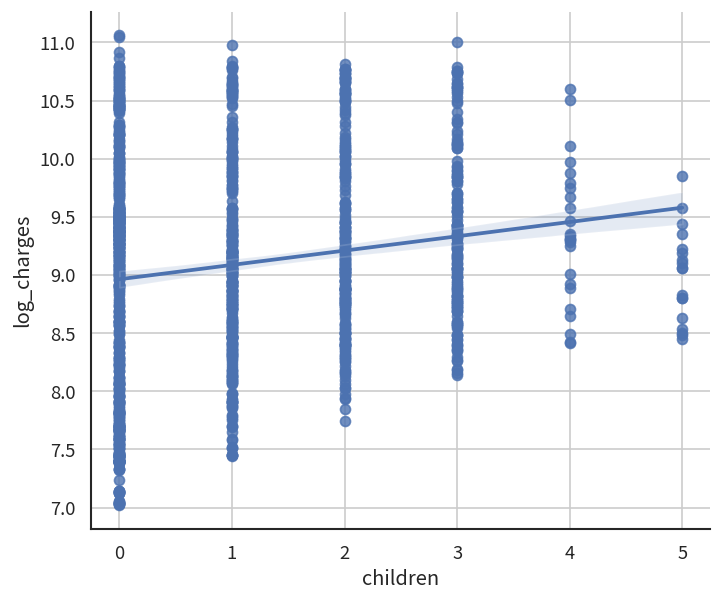

In [ ]:
# 1) 그래프 초기화 (캔버스(fig)와 도화지(ax) 준비하기)
width_px = 1280              # 그래프 가로 크기
height_px = 720              # 그래프 세로 크기
figsize = (width_px / my_dpi, height_px / my_dpi)

#아래의 초기화 부분은 생략된다 
#fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

# 2) LM plot 그리기
#그래프를 꾸미기 위해서는 LM PLOT () 메서드로부터 리턴되는 객체 g 를 활용해야 한다

g=sb.lmplot(data=df_plot2 , x='children', y='log_charges')

g.fig.set_dpi(my_dpi)
g.fig.set_figwidth(figsize[0])
g.fig.set_figwidth(figsize[1])

#두개의 그래프가 생성되면 각 그래프에 대해 그리드 설정은 별도로 필요하다
for ax in g.axes.flatten():
  ax.grid(True)

# 3) 출력
plt.tight_layout()                     # 여백 제거
plt.savefig("plot.png", dpi=my_dpi * 2)
plt.show()                             # 그래프 화면 출력
plt.close()                            # 그래프 작업 종료

### (6) BMI에 따른 의료비 분포 확인
(6) bmi × log_charges 산점도 + 회귀선
- (전체 데이터) BMI를 연속형 변수로 분석할 경우
BMI 증가에 따른 의료비의 점진적인 변화는 확인할 수 있었으나,
의료비 수준이 어느 구간에서 구조적으로 변화하는지에 대한 해석에는 한계가 있었다.

이에 BMI를 WHO 기준에 따라 범주형 변수로 구분하여 분석한 결과,
정상(Normal) 및 과체중(Overweight) 구간에서는
의료비 분포가 상당 부분 중첩되는 반면,
비만(Obese) 구간에서 의료비의 중앙값과 상위 분포가 뚜렷하게 상승하는 양상이 관찰되었다.

이는 BMI가 의료비에 선형적으로 작용하기보다는,
비만 구간에 진입하면서 의료비 수준을 구조적으로 변화시키는 변수임을 시사한다.


한편 BMI가 의료비에 일정 부분 영향을 미치지만,
BMI 단독 변수로 의료비 수준을 충분히 설명하기는 어렵다고 판단되어 
성별, smoker 을 기준으로 추가적인 시각화를 진행하였다 

- (성별)
성별에 따라 BMI와 의료비의 관계를 비교한 결과,
남성과 여성 모두에서 BMI 증가에 따른 의료비 상승 경향이 나타난다.

두 집단의 회귀선 기울기는 유사하며,
의료비 분포 또한 상당 부분 겹쳐 있어
성별에 따른 뚜렷한 의료비 수준 차이는 제한적으로 보인다.

따라서 성별은 의료비에 일정한 영향을 줄 수 있으나,
BMI와 의료비 간 관계를 구조적으로 변화시키는 요인으로 보기는 어렵다.


- (흡연)
흡연 여부에 따라 BMI와 의료비 간의 관계를 비교한 결과,
흡연자 집단에서 전반적으로 의료비 수준이 비흡연자보다 현저히 높게 나타난다.

특히 흡연자의 경우 BMI 증가에 따라 의료비가 가파르게 증가하는 경향이 관찰되며,
회귀선의 기울기 또한 비흡연자보다 크게 나타난다.

반면 비흡연자 집단에서는 BMI 증가에 따른 의료비 상승 폭이 상대적으로 완만하며,
전체 의료비 수준 역시 낮게 분포한다.

동일한 BMI 구간에서도 흡연자의 의료비 분포가 비흡연자보다 상단에 위치하여,
흡연 여부가 BMI보다 의료비에 더 강한 영향을 미치는 주요 요인임을 시사한다.

이는 BMI와 의료비 간의 관계가 흡연 여부에 따라 상호작용 효과(interaction)를 가질 가능성을 보여준다.

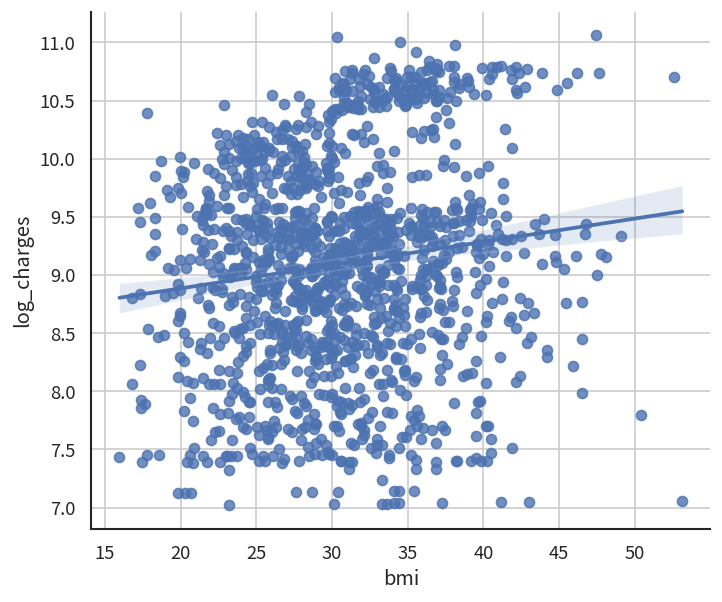

In [ ]:
# 1) 그래프 초기화 (캔버스(fig)와 도화지(ax) 준비하기)
width_px = 1280              # 그래프 가로 크기
height_px = 720              # 그래프 세로 크기
figsize = (width_px / my_dpi, height_px / my_dpi)

#아래의 초기화 부분은 생략된다 
#fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

# 2) LM plot 그리기
#그래프를 꾸미기 위해서는 LM PLOT () 메서드로부터 리턴되는 객체 g 를 활용해야 한다

g=sb.lmplot(data=df_plot2 , x='bmi', y='log_charges')

g.fig.set_dpi(my_dpi)
g.fig.set_figwidth(figsize[0])
g.fig.set_figwidth(figsize[1])

#두개의 그래프가 생성되면 각 그래프에 대해 그리드 설정은 별도로 필요하다
for ax in g.axes.flatten():
  ax.grid(True)

# 3) 출력
plt.tight_layout()                     # 여백 제거
plt.savefig("plot.png", dpi=my_dpi * 2)
plt.show()                             # 그래프 화면 출력
plt.close()                            # 그래프 작업 종료

ValueError: Could not interpret value `bmi_group` for `x`. An entry with this name does not appear in `data`.

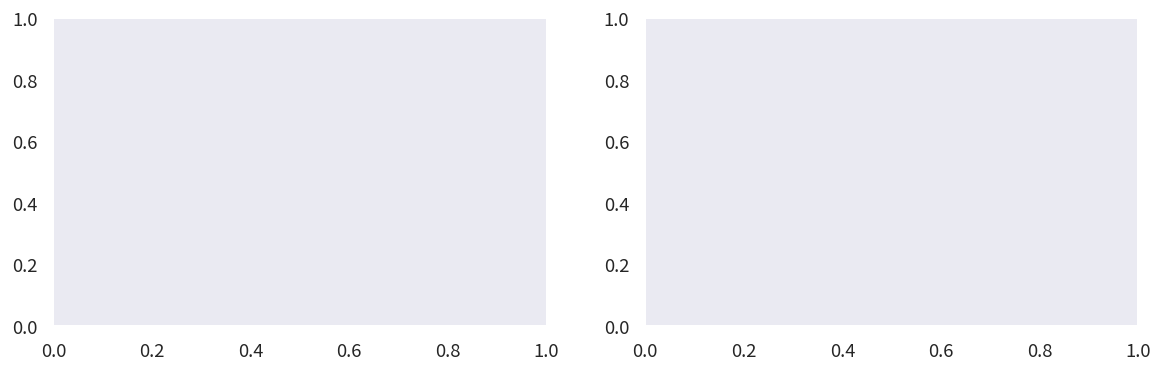

In [ ]:
# 1) 그래프 초기화
width_px, height_px = 1400, 400
figsize = (width_px / my_dpi, height_px / my_dpi)

fig, ax = plt.subplots(1, 2, figsize=figsize, dpi=my_dpi)

# 박스플롯
sb.boxplot(data=df_plot2, x='bmi_group', y='log_charges', ax=ax[0],palette='pastel')
ax[0].set_title('Charges by bmi_group (Boxplot)')
ax[0].tick_params(axis='x', rotation=20)
ax[0].grid(axis='y', linestyle='--', alpha=0.6)

# 바이올린 플롯
sb.violinplot(data=df_plot2, x='bmi_group', y='log_charges', ax=ax[1],palette='pastel')
ax[1].set_title('Charges by bmi_group (Violin)')
ax[1].tick_params(axis='x', rotation=20)
ax[1].grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()
plt.close()

- sex 에 따른 bmi 와 log_charges 의 관계

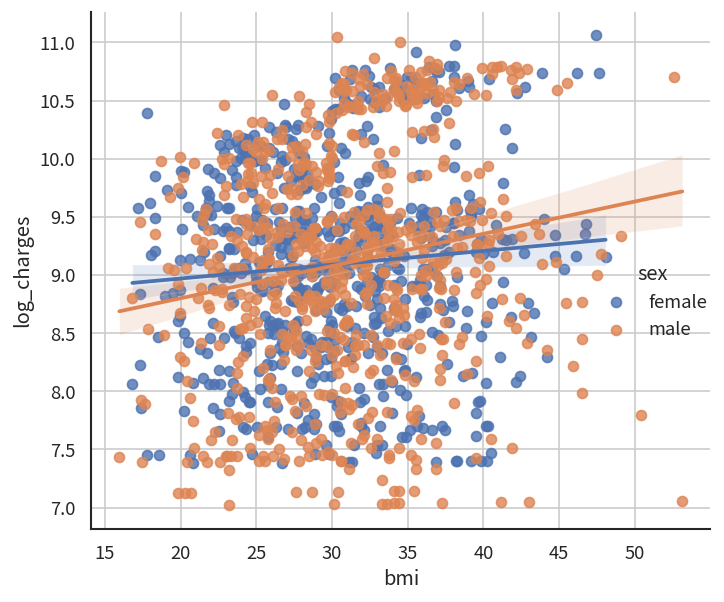

In [ ]:
# 1) 그래프 초기화 (캔버스(fig)와 도화지(ax) 준비하기)
width_px = 1280              # 그래프 가로 크기
height_px = 720              # 그래프 세로 크기
figsize = (width_px / my_dpi, height_px / my_dpi)

#아래의 초기화 부분은 생략된다 
#fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

# 2) LM plot 그리기
#그래프를 꾸미기 위해서는 LM PLOT () 메서드로부터 리턴되는 객체 g 를 활용해야 한다

g=sb.lmplot(data=df_plot2 , x='bmi', y='log_charges',hue = 'sex' )

g.fig.set_dpi(my_dpi)
g.fig.set_figwidth(figsize[0])
g.fig.set_figwidth(figsize[1])

#두개의 그래프가 생성되면 각 그래프에 대해 그리드 설정은 별도로 필요하다
for ax in g.axes.flatten():
  ax.grid(True)




# 3) 출력
plt.tight_layout()                     # 여백 제거
plt.savefig("plot.png", dpi=my_dpi * 2)
plt.show()                             # 그래프 화면 출력
plt.close()                            # 그래프 작업 종료


- smoker 에 따른 bmi 와 log_charges 의 관계

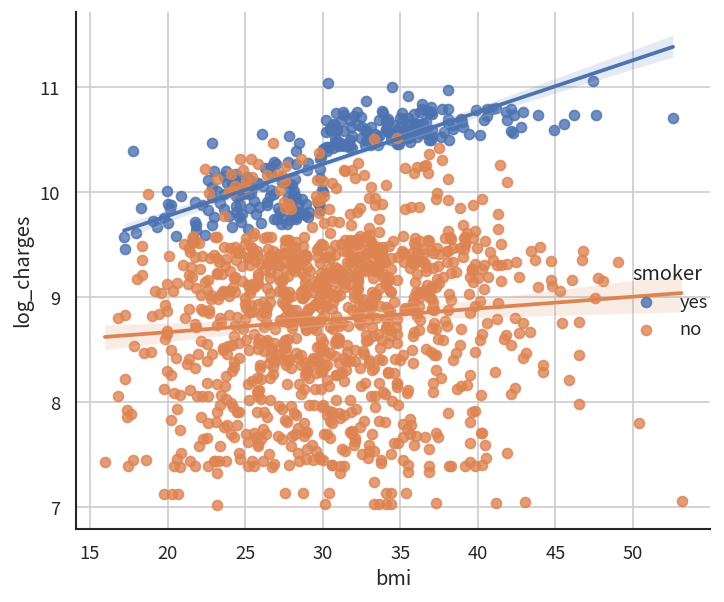

In [ ]:
# 1) 그래프 초기화 (캔버스(fig)와 도화지(ax) 준비하기)
width_px = 1280              # 그래프 가로 크기
height_px = 720              # 그래프 세로 크기
figsize = (width_px / my_dpi, height_px / my_dpi)

#아래의 초기화 부분은 생략된다 
#fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

# 2) LM plot 그리기
#그래프를 꾸미기 위해서는 LM PLOT () 메서드로부터 리턴되는 객체 g 를 활용해야 한다

g=sb.lmplot(data=df_plot2 , x='bmi', y='log_charges',hue = 'smoker' )

g.fig.set_dpi(my_dpi)
g.fig.set_figwidth(figsize[0])
g.fig.set_figwidth(figsize[1])

#두개의 그래프가 생성되면 각 그래프에 대해 그리드 설정은 별도로 필요하다
for ax in g.axes.flatten():
  ax.grid(True)




# 3) 출력
plt.tight_layout()                     # 여백 제거
plt.savefig("plot.png", dpi=my_dpi * 2)
plt.show()                             # 그래프 화면 출력
plt.close()                            # 그래프 작업 종료

> 각 변수들에 대해 시각화를 진행하여 분포를 확인하였고, 흡연 , 연령대 , bmi 구간 변수에 대해 추가적인 통계적 검증 진행

#### Welch ANOVA 실시

bmi 구간에 따른 평균 차이의 유의미성 확인 

In [ ]:
df_plot2

In [ ]:
bmi_Underweight = df_plot2.loc[df_plot2['bmi_group'] == 'Underweight', 'log_charges']
bmi_Normal = df_plot2.loc[df_plot2['bmi_group'] == 'Normal', 'log_charges']
bmi_Overweight = df_plot2.loc[df_plot2['bmi_group'] == 'Overweight', 'log_charges']
bmi_Obese = df_plot2.loc[df_plot2['bmi_group'] == 'Obese', 'log_charges']

data = pd.DataFrame({
    'Underweight': bmi_Underweight,
    'Normal': bmi_Normal,
    'Overweight': bmi_Overweight,
    'Obese': bmi_Obese
})

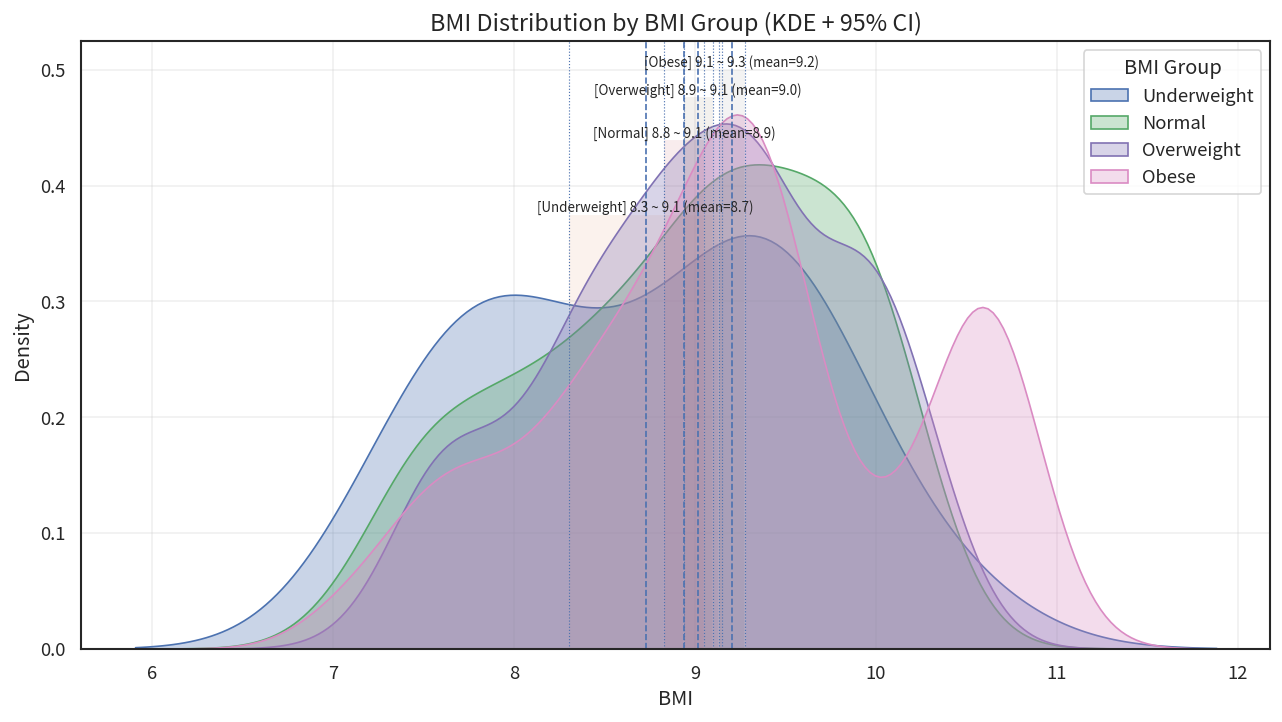

In [ ]:
from math import sqrt
from scipy.stats import t

# 1) 그래프 초기화
width_px  = 1280
height_px = 720
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=my_dpi)

for c in data.columns:
    series = data[c].dropna()   # NaN 제거

    # KDE Plot
    sb.kdeplot(x=series, fill=True, alpha=0.3, label=c)

    # 신뢰구간 계산
    clevel = 0.95
    dof = len(series) - 1
    sp_mean = series.mean()
    sp_std = series.std(ddof=1)
    sp_std_error = sp_std / sqrt(len(series))

    cmin, cmax = t.interval(clevel, dof, loc=sp_mean, scale=sp_std_error)

    # 시각화
    ax.axvline(cmin, linestyle=':', linewidth=0.7)
    ax.axvline(cmax, linestyle=':', linewidth=0.7)
    ax.axvline(sp_mean, linestyle='--', linewidth=1)

    ymin, ymax = ax.get_ylim()
    ax.fill_between([cmin, cmax], 0, ymax, alpha=0.1)

    ax.text(
        x=(cmax + cmin) / 2,
        y=ymax,
        s=f"[{c}] {cmin:.1f} ~ {cmax:.1f} (mean={sp_mean:.1f})",
        ha='center',
        va='bottom',
        fontsize=8
    )

# 3) 그래프 꾸미기
ax.set_title('BMI Distribution by BMI Group (KDE + 95% CI)', fontsize=14, fontweight='bold')
ax.set_xlabel('BMI')
ax.grid(True, alpha=0.3)
ax.legend(title='BMI Group')

# 4) 출력
plt.tight_layout()
plt.show()
plt.close()


In [ ]:
from scipy.stats import normaltest, bartlett, levene
from pandas import DataFrame

equal_var_fields = []
normal_dist = True
report = []

for c in data.columns:
    series = data[c].dropna()   # ⭐ 반드시 NaN 제거

    s, p = normaltest(series)

    normalize = p > 0.05
    report.append({
        "field": c,
        "statistic": s,
        "p-value": p,
        "result": normalize
    })

    normal_dist = normal_dist and normalize


# 변수가 두 개 이상인 경우 등분산성 확인
if len(data.columns) > 1:
    if normal_dist:
        n = "Bartlett"               # 정규성 충족 시
        s, p = bartlett(*[data[c].dropna() for c in data.columns])
    else:
        n = "Levene"                 # 정규성 미충족 시
        s, p = levene(*[data[c].dropna() for c in data.columns], center="median")

    report.append({
        "field": n,
        "statistic": s,
        "p-value": p,
        "result": p > 0.05
    })

report_df = DataFrame(report).set_index("field")
report_df

,statistic,p-value,result
field,,,
Underweight,2.579796,2.752988e-01,True
Normal,28.960146,5.144987e-07,False
Overweight,27.454654,1.092189e-06,False
Obese,42.825477,5.018407e-10,False
Levene,5.378765,1.109893e-03,False


> BMI 구간별 의료비에 대해 대부분 정규성 검정 결과는 충족되지 않았고,
Levene 검정 결과 등분산성 가정도 충족되지 않았다.
표본 수가 충분히 크므로 분산분석을 수행할 수 있으며,
분포의 왜도를 고려하여 Welch ANOVA를 사용하였다.

🔹 가설 설정
| 구분            | 내용                                             |
| ------------- | ---------------------------------------------- |
| **귀무가설 (H₀)** | BMI 구간별 평균 의료비는 모두 같다 |
| **대립가설 (H₁)** | 적어도 한 연령대의 평균 의료비는 다른 연령대와 다르다                 |

In [ ]:
import pingouin as pg

# 1️⃣ ANOVA 전용 데이터프레임 생성
df_bmi_anova = df_plot2[['bmi_group', 'log_charges']].dropna().copy()
df_bmi_anova['bmi_group'] = df_bmi_anova['bmi_group'].astype('category')

# 2️⃣ Welch ANOVA 수행
anova_result = pg.welch_anova(
    data=df_bmi_anova,
    dv='log_charges',
    between='bmi_group'
)

# 3️⃣ 결과 추출
s = anova_result['F'].iloc[0]
p = anova_result['p-unc'].iloc[0]

# 4️⃣ 결과 출력
print(
    "statistic: {0:.3f}, p-value: {1:.3e}, {2}가설 채택"
    .format(s, p, "대립" if p <= 0.05 else "귀무")
)

anova_result

statistic: 7.444, p-value: 1.652e-04, 대립가설 채택


,Source,ddof1,ddof2,F,p-unc,np2
0,bmi_group,3,90.024775,7.443851,0.000165,0.016623


log(charges)를 기준으로 보았을 때, BMI 그룹에 따라 평균 의료비는 통계적으로 유의미하게 달라지며,
BMI 그룹은 의료비 수준을 설명하는 중요한 요인으로 나타났다.


| 항목         |                              값 | 해석                                |
| ---------- | -----------------------------: | --------------------------------- |
| **가설 검정**  | p-value = 1.65 × 10⁻⁴ (< 0.05) | 귀무가설(H₀)을 기각하고 대립가설(H₁)을 채택       |
| **통계적 의미** |                       F = 7.45 | BMI 그룹 간 평균 log(의료비) 차이가 통계적으로 유의 |
| **효과 크기**  |                   np² = 0.0166 | BMI 그룹의 영향은 **작음(small) 수준**      |

- Welch ANOVA 결과 연령대별 평균 의료비 차이가 유의하게 나타나 사후검정을 수행하였다.
- 등분산 가정을 필요로 하지 않는 Games–Howell 검정을 사용하였다. 

In [ ]:
# df_age_anova: ['age_group', 'charges'] 포함된 데이터프레임
gh_df = pg.pairwise_gameshowell(
    data=df_bmi_anova,
    dv='log_charges',
    between='bmi_group'
)

gh_df

,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,Underweight,Normal,8.727644,8.940622,-0.212978,0.209244,-1.017845,22.106003,0.740886,-0.248881
1,Underweight,Overweight,8.727644,9.017031,-0.289387,0.205507,-1.408159,20.577928,0.508601,-0.359301
2,Underweight,Obese,8.727644,9.204015,-0.476371,0.204843,-2.325542,20.314254,0.125085,-0.482728
3,Normal,Overweight,8.940622,9.017031,-0.076409,0.069686,-1.096475,445.807426,0.691881,-0.093339
4,Normal,Obese,8.940622,9.204015,-0.263394,0.067703,-3.890454,433.198937,0.000667,-0.275194
5,Overweight,Obese,9.017031,9.204015,-0.186985,0.055080,-3.394750,939.324913,0.003984,-0.201861


<사후검정 결과 해설>

1️⃣ Underweight vs Normal
| 항목                |                    값 | 해석           |
| ----------------- | -------------------: | ------------ |
| mean(Underweight) |                8.728 | 저체중          |
| mean(Normal)      |                8.941 | 정상           |
| diff              |               -0.213 | Normal이 더 높음 |
| p-value           |                0.741 | 유의하지 않음      |
| Hedges’ g         |                -0.25 | 작은 효과        |
| **결론**            | Normal ≈ Underweight | 의료비 차이 없음    |



2️⃣ Underweight vs Overweight
| 항목                |                        값 | 해석               |
| ----------------- | -----------------------: | ---------------- |
| mean(Underweight) |                    8.728 | 저체중              |
| mean(Overweight)  |                    9.017 | 과체중              |
| diff              |                   -0.289 | Overweight가 더 높음 |
| p-value           |                    0.509 | 유의하지 않음          |
| Hedges’ g         |                    -0.36 | 작은~중간 효과         |
| **결론**            | Overweight ≈ Underweight | 통계적 차이 없음        |


3️⃣ Underweight vs Obese
| 항목                |                   값 | 해석            |
| ----------------- | ------------------: | ------------- |
| mean(Underweight) |               8.728 | 저체중           |
| mean(Obese)       |               9.204 | 비만            |
| diff              |              -0.476 | Obese가 더 높음   |
| p-value           |               0.121 | 유의하지 않음       |
| Hedges’ g         |               -0.48 | 중간 효과         |
| **결론**            | Obese ≥ Underweight | 증가 경향 있으나 불확실 |



4️⃣ Normal vs Overweight
| 항목               |                   값 | 해석        |
| ---------------- | ------------------: | --------- |
| mean(Normal)     |               8.941 | 정상        |
| mean(Overweight) |               9.017 | 과체중       |
| diff             |              -0.076 | 차이 매우 작음  |
| p-value          |               0.692 | 유의하지 않음   |
| Hedges’ g        |               -0.09 | 효과 거의 없음  |
| **결론**           | Normal ≈ Overweight | 의료비 수준 유사 |


5️⃣ Normal vs Obese ⭐
| 항목           |                  값 | 해석          |
| ------------ | -----------------: | ----------- |
| mean(Normal) |              8.941 | 정상          |
| mean(Obese)  |              9.204 | 비만          |
| diff         |             -0.263 | Obese가 더 높음 |
| p-value      |        6.66 × 10⁻⁴ | **유의**      |
| Hedges’ g    |              -0.28 | 작은~중간 효과    |
| **결론**       | **Obese > Normal** | 비만에서 의료비 증가 |


6️⃣ Overweight vs Obese ⭐
| 항목               |                      값 | 해석          |
| ---------------- | ---------------------: | ----------- |
| mean(Overweight) |                  9.017 | 과체중         |
| mean(Obese)      |                  9.204 | 비만          |
| diff             |                 -0.187 | Obese가 더 높음 |
| p-value          |            3.98 × 10⁻³ | **유의**      |
| Hedges’ g        |                  -0.20 | 작은 효과       |
| **결론**           | **Obese > Overweight** | 비만 단계에서 증가  |


🔢 서열 요약

Underweight ≈ Normal ≈ Overweight < Obese



Games–Howell 사후검정 결과, BMI 그룹 간 의료비 차이는 주로 비만(Obese) 그룹과 다른 BMI 그룹 간 비교에서 유의하게 나타났다. 정상 및 과체중 그룹 간에는 유의한 차이가 관찰되지 않았으나, 비만 그룹은 정상 및 과체중 그룹보다 평균 log(의료비)가 유의하게 높았다. 이는 BMI가 연속적으로 의료비를 증가시키기보다는, 비만 단계에 진입하면서 의료비 부담이 구조적으로 증가함을 시사한다.

### (7) 상관분석
1. 주요 작업
   - 연속형 변수 위주로 'age', 'bmi', 'children', 'log_charges' 상관행렬 생성 하여 시각화, VIF 점검
   - children 은 이산형 변수이므로 목적에 따라 연속형/범주형 변수로 쓰일 수 있다고 판단함 (해당 분석에서는 연속형으로서 사용)


2. 상관성 확인 
   - z score 기준으로 outlier 확인 시, 이상치가 확인되어 스피어만 상관계수 사용 

| 변수              |   age |   bmi | children | log_charges |
| --------------- | ----: | ----: | -------: | ----------: |
| **age**         | 1.000 | 0.108 |    0.057 |       0.534 |
| **bmi**         | 0.108 | 1.000 |    0.016 |       0.119 |
| **children**    | 0.057 | 0.016 |    1.000 |       0.133 |
| **log_charges** | 0.534 | 0.119 |    0.133 |       1.000 |



3. VIF 확인
   - VIF 분석 결과, age, bmi, children의 VIF 값은 모두 1.0~1.02 수준으로 나타나
    다중공선성 문제는 전혀 관찰되지 않았다.\

   - 이는 다음 두 가지 이유에 기인한다.
    독립변수 간 상관계수가 전반적으로 낮아 변수 간 정보 중복이 거의 없고,
    각 변수는 의료비에 대해 서로 다른 측면(연령, 건강 상태, 가족 구성)을 설명하기 때문이다.
    따라서 본 분석에서는 모든 변수를 안정적으로 회귀 모델에 포함할 수 있다.

- 피어슨 상관 계수와 스피어만 상관 계수 중 선택해보자

In [ ]:
df_corr=df_age.copy()

In [ ]:
# 이상치와 왜도 검정
data = df_corr[['age', 'bmi', 'children', 'log_charges']]
results = {}

for col in data.columns:
    temp = data[col].dropna()

    # 왜도 계산
    skew_original = temp.skew()

    # Z-score 기반 이상치 탐지 (|z| > 3)
    z_scores = zscore(temp)
    outlier_count = int(np.sum(np.abs(z_scores) > 3))

    # 로그 변환 후 왜도 계산 (음수 대비 +1)
    data_log = np.log1p(temp - temp.min() + 1)
    skew_log = data_log.skew()

    # 로그 변환 필요 여부 판단
    need_log = (abs(skew_original) > 1) and (abs(skew_log) < abs(skew_original))

    results[col] = {
        'original_skew': skew_original,
        'log_skew': skew_log,
        'outliers(|z|>3)': outlier_count,
        'log_recommended': need_log,
    }

# 결과 dataframe 변환
results_df = pd.DataFrame(results).T
display(results_df)

# 이상치 검정 결과
outlier_flag = len(results_df[results_df['outliers(|z|>3)'] > 0]) > 0


if outlier_flag:
    print("이상치가 발견되어 스피어만 상관계수 사용")
else:
    print("이상치가 발견되지 않아 피어슨 상관계수 사용")


,original_skew,log_skew,outliers(|z|>3),log_recommended
age,0.055673,-0.988574,0,False
bmi,0.284047,-0.963062,4,False
children,0.93838,0.432129,18,False
log_charges,-0.090098,-0.596158,0,False


이상치가 발견되어 스피어만 상관계수 사용


- Pearson 상관계수
    - 선형 관계 + 정규성 가정 필요
    - 이상치(outlier)에  민감

- Spearman 상관계수
    - 순위 기반 상관
    - 비선형 관계와 이상치에 강건(robust)

본 데이터의 의료비(charges)는:
극단적으로 큰 값이 존재하는 long-tail 분포
정규성 가정을 충족하지 않음
따라서 Pearson보다 Spearman 상관계수가 더 적합하며,
실제 변수 간 관계를 왜곡 없이 반영할 수 있다.

> 결론: Spearman 상관계수를 기준으로 해석이 적합하다고 판단

In [ ]:
cols = ['age', 'bmi', 'children', 'log_charges']

# 스피어만 상관행렬 + p-value 행렬
corr, pvals = spearmanr(df_corr[cols])

# DataFrame으로 정리
spearman_corr = pd.DataFrame(corr, index=cols, columns=cols)
spearman_pval = pd.DataFrame(pvals, index=cols, columns=cols)

spearman_corr, spearman_pval


(                  age       bmi  children  log_charges
 age          1.000000  0.107736  0.056992     0.534392
 bmi          0.107736  1.000000  0.015607     0.119396
 children     0.056992  0.015607  1.000000     0.133339
 log_charges  0.534392  0.119396  0.133339     1.000000,
                       age       bmi      children   log_charges
 age          0.000000e+00  0.000079  3.711959e-02  1.130692e-99
 bmi          7.859093e-05  0.000000  5.684234e-01  1.192606e-05
 children     3.711959e-02  0.568423  0.000000e+00  9.846806e-07
 log_charges  1.130692e-99  0.000012  9.846806e-07  0.000000e+00)

In [ ]:
# 사용할 변수
cols = ['age', 'bmi', 'children', 'log_charges']

# 상관계수 선택 (이전에 이상치/왜도 검사 결과 → Spearman 권장)
chosen = 'spearman'   # 또는 'pearson'

corr_matrix = df_corr[cols].corr(method=chosen)
corr_matrix


,age,bmi,children,log_charges
age,1.000000,0.107736,0.056992,0.534392
bmi,0.107736,1.000000,0.015607,0.119396
children,0.056992,0.015607,1.000000,0.133339
log_charges,0.534392,0.119396,0.133339,1.000000


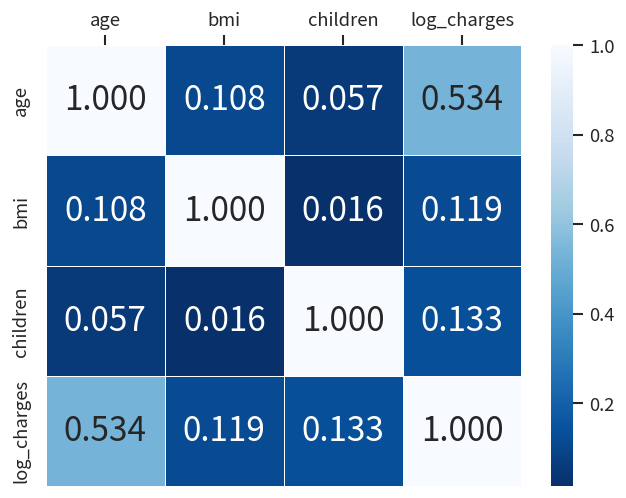

In [ ]:
# 1) 그래프 초기화
width_px  = 650          # 그래프 가로 크기
height_px = 500          # 그래프 세로 크기
rows = 1                 # 그래프 행 수
cols = 1                 # 그래프 열 수

figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

# 2) heatmap 그리기
sb.heatmap(
    data=corr_matrix,
    annot=True,
    fmt="0.3f",
    linewidth=0.5,
    cmap="Blues_r",
    annot_kws={"size": 20}
)

# 3) 그래프 꾸미기
ax.set_xlabel("")
ax.set_ylabel("")
ax.xaxis.tick_top()      # x축의 변수 이름을 상단으로 이동

# 4) 출력
plt.tight_layout()       # 여백 제거
plt.show()               # 그래프 화면 출력
plt.close()              # 그래프 작업 종료


- charges와 age, bmi, children의 상관계수 계산 결과
  
  | 변수       | Spearman 상관계수 (ρ) | 해석             |
  | -------- | ----------------- | -------------- |
  | age      | **0.534**         | 중간~강한 양(+)의 상관 |
  | bmi      | 0.119             | 약한 양(+)의 상관    |
  | children | 0.133             | 약한 양(+)의 상관    |

- 각 변수의 관계를 의료학·보험학적 언어로 해석하고 인과성을 말할 수 있는지 비교·평가합니다.

  | 변수           | 해석                     | 의료학적 의미             | 보험학적 의미                | 요약 문장             |
  | ------------ | ---------------------- | ------------------- | ---------------------- | ----------------- |
  | **Age**      | 의료비와 **중간 이상 양의 상관관계** | 고령일수록 만성질환·의료 이용 누적 | 보험 위험을 가장 잘 설명하는 핵심 변수 | 나이가 많을수록 의료비가 증가  |
  | **BMI**      | 의료비와 **약한 양의 상관관계**    | 비만 관련 질환 위험 증가      | 단독보다는 보조적 위험 요인        | BMI는 의료비에 간접적 영향  |
  | **Children** | 의료비와 **매우 약한 상관관계**    | 개인 건강 상태와 직접 연관 낮음  | 가구 특성 변수에 가까움          | 자녀 수는 의료비 설명력이 낮음 |

  -------------------------------------------------------
  | 변수           | 인과 해석 가능성 | 판단                   |
  | ------------ | --------- | -------------------- |
  | **Age**      |  제한적 가능 | 시간적 선후는 명확하나 관측자료 한계 |
  | **BMI**      | 어려움     | 생활습관·질병이 매개          |
  | **Children** |  불가      | 사회경제적 요인 혼재          |

> 의료비는 연령과 가장 밀접한 관련을 보이며, BMI와 자녀 수는 보조적 요인으로 작용한다. 본 분석은 상관관계 기반이므로 변수 간 인과성을 직접적으로 단정할 수는 없다.

*** 그러나 주의해야 할 점 !!!!!!

- 지금까지의 탐색 결과를 바탕으로 “상관이 높다 = 원인이다”라는 착각을 피하자.
  - 1️⃣ 상관관계 ≠ 인과관계
  상관계수가 높다는 것은 두 변수가 함께 변한다는 의미일 뿐,
  한 변수가 다른 변수를 직접적으로 원인으로 만든다는 것을 의미하지 않는다.
  본 분석은 관측 자료(observational data)를 기반으로 하므로, 인과관계를 단정할 수 없다.

  - 2️⃣ age–charges 관계: 나이가 원인일까?
  관찰 결과	해석
  age와 charges는 높은 양의 상관관계	나이가 많을수록 의료비가 증가하는 경향
  인과 해석의 한계	나이 자체보다는 만성질환, 건강 악화, 의료 이용 누적의 대리변수일 가능성

  - 해석 요약 : 나이는 의료비 증가의 직접 원인이라기보다는, 건강 상태와 의료 이용을 대표하는 지표(proxy variable)일 가능성이 크다.
  
- smoker 효과: 흡연자는 정말 더 많이 병에 걸려서인가, 아니면 보험사의 위험 평가 기준인가?

| 가능성            | 설명                            |
| -------------- | ----------------------------- |
| **의학적 경로**     | 흡연 → 호흡기·심혈관 질환 증가 → 의료 이용 증가 |
| **보험 제도적 요인**  | 흡연자에게 더 높은 보험료·위험 할증 적용       |
| **행동·생활습관 요인** | 흡연과 동반되는 다른 위험 행동(운동 부족 등)    |



- 데이터 수집 시점·의료 접근성 차이·미측정 변수(직업, 교육, 소득)가 결론에 주는 한계를 서술하세요.
  
| 한계 요인         | 설명                        |
| ------------- | ------------------------- |
| **데이터 수집 시점** | 단일 시점 관측 → 시간적 인과관계 추적 불가 |
| **의료 접근성 차이** | 지역·보험 유형에 따라 의료 이용량 상이    |
| **미측정 변수**    | 직업, 소득, 교육 수준, 생활습관 미포함   |
| **선택 편향**     | 보험 가입자만 포함된 표본            |

## 미션 4. 회귀분석

In [ ]:
# 데이터 프레임 복사
ydf = origin.copy()
ydf['log_charges'] = np.log(ydf['charges'])
ydf.head()

,age,sex,bmi,children,smoker,region,charges,log_charges
0,19,female,27.900,0,yes,southwest,16884.92400,9.734176
1,18,male,33.770,1,no,southeast,1725.55230,7.453302
2,28,male,33.000,3,no,southeast,4449.46200,8.400538
3,33,male,22.705,0,no,northwest,21984.47061,9.998092
4,32,male,28.880,0,no,northwest,3866.85520,8.260197


In [ ]:
# 모델 적합
model = ols('log_charges ~ age + C(sex) + bmi + children + C(smoker) + C(region)', data = ydf).fit()

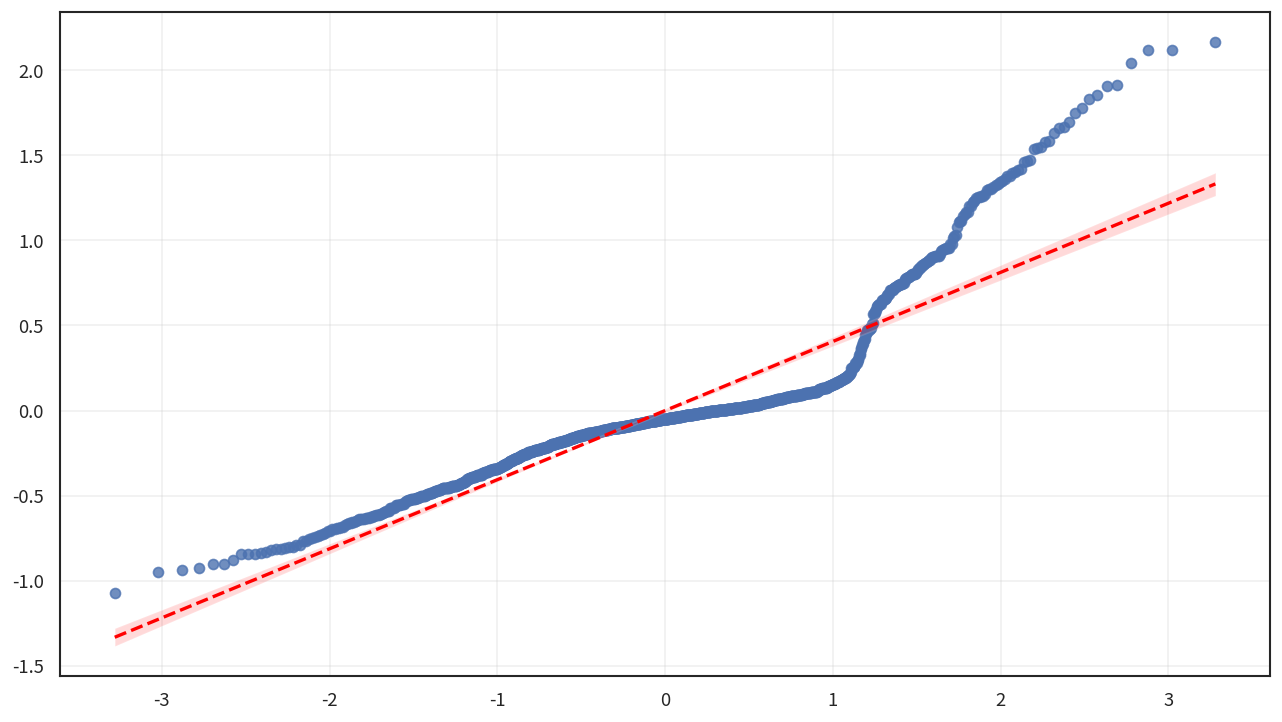

In [ ]:
# 잔차의 정규성 검정 (Q-Q Plot)
(x, y), _ = probplot(model.resid)

width_px  = 1280
height_px = 720
rows = 1
cols = 1
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

# 2) regplot 그리기
sb.regplot(x=x, y=y, line_kws={
"color": "red",
"linestyle": "--",   
"linewidth": 2
            })
# 3) 그래프 꾸미기
ax.grid(True, alpha=0.3)           

plt.tight_layout()      
plt.show()              
plt.close()             

In [ ]:
# Shaprio 검정을 통한 정규성 진단
s, p = stats.shapiro(model.resid)
print(f"statistic: {s:.3f}, p-value: {p:.3f} >>> 정규성 {'만족' if p > 0.05 else '불만족'}")

statistic: 0.837, p-value: 0.000 >>> 정규성 불만족


In [ ]:
# 선형성 검정
reset_res = linear_reset(model, power=2, use_f=True)
print(f"RESET F-statistic: {reset_res.fvalue:.4f}")
print(f"p-value: {reset_res.pvalue:.4f}")
if reset_res.pvalue < 0.05:
    print(">>> 선형성/기능형 위배 가능성이 있음 (5% 유의수준)")
else:
    print(">>> 선형성 가정 위배 근거 없음 (5% 유의수준)")

RESET F-statistic: 287.1425
p-value: 0.0000
>>> 선형성/기능형 위배 가능성이 있음 (5% 유의수준)


In [ ]:
# 독립성 검정
dw = durbin_watson(model.resid)

if 1.5 <= dw <= 2.5:
    interpretation = "잔차는 독립성을 만족함 (자기상관 없음)"
elif dw < 1.5:
    interpretation = "잔차에 양(+)의 자기상관이 존재할 가능성 있음 (독립성 위반)"
else:
    interpretation = "잔차에 음(–)의 자기상관이 존재할 가능성 있음 (독립성 위반)"

print(f"Durbin–Watson: {dw:.3f}")
print(interpretation)

Durbin–Watson: 2.046
잔차는 독립성을 만족함 (자기상관 없음)


In [ ]:
# 등분산성 검정
# Breusch–Pagan Test
names = ['LM Statistic', 'LM p-value', 'F Statistic', 'F p-value']
bp_test = het_breuschpagan(model.resid, model.model.exog)
bp = DataFrame(bp_test, index=names, columns=['value'])

# p-value는 F p-value를 기준으로 사용
p_bp = bp.loc['F p-value', 'value']

print(f"Breusch–Pagan statistic: {bp.loc['F Statistic','value']:.3f}, p-value = {p_bp:.3f}")
print(f"{'이분산성 존재(등분산 아님)' if p_bp <= 0.05 else '등분산성 만족'}")

Breusch–Pagan statistic: 10.155, p-value = 0.000
이분산성 존재(등분산 아님)


정규성, 선형성, 독립성, 등분산성 만족


........

선형성 등분산성을 만족하기 위한 전처리 시작
1. charge 변수 boxcox 변환 + bmi, age 로그변환
2. 독립변수(age, bmi) 변환
3. 상호작용항 추가

In [ ]:
y = ydf['charges']
y_bc, lam = stats.boxcox(y)
ydf['charges_bc'] = y_bc
model = ols('charges_bc ~ age + C(sex) + bmi + children + C(smoker) + C(region)', data = ydf).fit()
stats.shapiro(model.resid)

ShapiroResult(statistic=np.float64(0.8294801902859807), pvalue=np.float64(1.5794296661975697e-35))

In [ ]:
reset_res = linear_reset(model, power=2, use_f=True)
print(f"RESET F-statistic: {reset_res.fvalue:.4f}")
print(f"p-value: {reset_res.pvalue:.4f}")
if reset_res.pvalue < 0.05:
    print("선형성/기능형 위배 가능성이 있음 (5% 유의수준)")
else:
    print("선형성 가정 위배 근거 없음 (5% 유의수준)")

RESET F-statistic: 245.0683
p-value: 0.0000
선형성/기능형 위배 가능성이 있음 (5% 유의수준)


In [ ]:
# Breusch–Pagan Test
names = ['LM Statistic', 'LM p-value', 'F Statistic', 'F p-value']
bp_test = het_breuschpagan(model.resid, model.model.exog)
bp = DataFrame(bp_test, index=names, columns=['value'])

# p-value는 F p-value를 기준으로 사용
p_bp = bp.loc['F p-value', 'value']

print(f"Breusch–Pagan statistic: {bp.loc['F Statistic','value']:.3f}, p-value = {p_bp:.3f}")
print(f"{'이분산성 존재(등분산 아님)' if p_bp <= 0.05 else '등분산성 만족'}")

Breusch–Pagan statistic: 9.100, p-value = 0.000
이분산성 존재(등분산 아님)


bmi, age 로그변환후 타겟변수로그변환과 한번, 박스콕스변환과 한번씩 진행, 
둘다 만족 안함

In [ ]:
ydf['age_log'] = np.log(ydf['age'])
ydf['bmi_log'] = np.log(ydf['bmi'])
model = ols('log_charges ~ age_log + C(sex) + bmi_log + children + C(smoker) + C(region)', data = ydf).fit()

In [ ]:
reset_res = linear_reset(model, power=2, use_f=True)
print(f"RESET F-statistic: {reset_res.fvalue:.4f}")
print(f"p-value: {reset_res.pvalue:.4f}")
if reset_res.pvalue < 0.05:
    print("선형성/기능형 위배 가능성이 있음 (5% 유의수준)")
else:
    print("선형성 가정 위배 근거 없음 (5% 유의수준)")

RESET F-statistic: 212.9912
p-value: 0.0000
선형성/기능형 위배 가능성이 있음 (5% 유의수준)


In [ ]:
# Breusch–Pagan Test
names = ['LM Statistic', 'LM p-value', 'F Statistic', 'F p-value']
bp_test = het_breuschpagan(model.resid, model.model.exog)
bp = DataFrame(bp_test, index=names, columns=['value'])

# p-value는 F p-value를 기준으로 사용
p_bp = bp.loc['F p-value', 'value']

print(f"Breusch–Pagan statistic: {bp.loc['F Statistic','value']:.3f}, p-value = {p_bp:.3f}")
print(f"{'이분산성 존재(등분산 아님)' if p_bp <= 0.05 else '등분산성 만족'}")

Breusch–Pagan statistic: 11.397, p-value = 0.000
이분산성 존재(등분산 아님)


2. 독립변수 변환, 위반

In [ ]:
ydf['age2'] = ydf['age']**2
ydf['bmi2'] = ydf['bmi']**2
model = ols('log_charges ~ age2 + C(sex) + bmi2 + children + C(smoker) + C(region)', data = ydf).fit()

In [ ]:
reset_res = linear_reset(model, power=2, use_f=True)
print(f"RESET F-statistic: {reset_res.fvalue:.4f}")
print(f"p-value: {reset_res.pvalue:.4f}")
if reset_res.pvalue < 0.05:
    print("선형성/기능형 위배 가능성이 있음 (5% 유의수준)")
else:
    print("선형성 가정 위배 근거 없음 (5% 유의수준)")

RESET F-statistic: 330.2636
p-value: 0.0000
선형성/기능형 위배 가능성이 있음 (5% 유의수준)


In [ ]:
# Breusch–Pagan Test
names = ['LM Statistic', 'LM p-value', 'F Statistic', 'F p-value']
bp_test = het_breuschpagan(model.resid, model.model.exog)
bp = DataFrame(bp_test, index=names, columns=['value'])

# p-value는 F p-value를 기준으로 사용
p_bp = bp.loc['F p-value', 'value']

print(f"Breusch–Pagan statistic: {bp.loc['F Statistic','value']:.3f}, p-value = {p_bp:.3f}")
print(f"{'이분산성 존재(등분산 아님)' if p_bp <= 0.05 else '등분산성 만족'}")

Breusch–Pagan statistic: 9.063, p-value = 0.000
이분산성 존재(등분산 아님)


3. 상호작용항 추가

In [ ]:
ydfe = ydf.copy()
ydfe = pd.get_dummies(ydfe, dtype = int, drop_first=True)

In [ ]:
ydfe.columns

Index(['age', 'bmi', 'children', 'charges', 'log_charges', 'charges_bc',
       'age_log', 'bmi_log', 'age2', 'bmi2', 'sex_male', 'smoker_yes',
       'region_northwest', 'region_southeast', 'region_southwest'],
      dtype='object')

In [ ]:
ydfe['bmi_smoker_interaction'] = ydfe['bmi'] * ydfe['smoker_yes']
ydfe['age_smoker_interaction'] = ydfe['age'] * ydfe['smoker_yes']
ydfe.columns

Index(['age', 'bmi', 'children', 'charges', 'log_charges', 'charges_bc',
       'age_log', 'bmi_log', 'age2', 'bmi2', 'sex_male', 'smoker_yes',
       'region_northwest', 'region_southeast', 'region_southwest',
       'bmi_smoker_interaction', 'age_smoker_interaction'],
      dtype='object')

In [ ]:
model = ols('log_charges ~ age + bmi + children + sex_male + smoker_yes + region_northwest + region_southeast + region_southwest + bmi_smoker_interaction + age_smoker_interaction', data = ydfe).fit()

In [ ]:
reset_res = linear_reset(model, power=2, use_f=True)
print(f"RESET F-statistic: {reset_res.fvalue:.4f}")
print(f"p-value: {reset_res.pvalue:.4f}")
if reset_res.pvalue < 0.05:
    print("선형성/기능형 위배 가능성이 있음 (5% 유의수준)")
else:
    print("선형성 가정 위배 근거 없음 (5% 유의수준)")

RESET F-statistic: 111.9104
p-value: 0.0000
선형성/기능형 위배 가능성이 있음 (5% 유의수준)


In [ ]:
# Breusch–Pagan Test
names = ['LM Statistic', 'LM p-value', 'F Statistic', 'F p-value']
bp_test = het_breuschpagan(model.resid, model.model.exog)
bp = DataFrame(bp_test, index=names, columns=['value'])

# p-value는 F p-value를 기준으로 사용
p_bp = bp.loc['F p-value', 'value']

print(f"Breusch–Pagan statistic: {bp.loc['F Statistic','value']:.3f}, p-value = {p_bp:.3f}")
print(f"{'이분산성 존재(등분산 아님)' if p_bp <= 0.05 else '등분산성 만족'}")

Breusch–Pagan statistic: 7.243, p-value = 0.000
이분산성 존재(등분산 아님)


이상황에서 더 하면 과적합, 따라서 로그변환, 비선형항 및 상호작용항을 포함한 선형회귀모형을 적용하였으나 잔차–적합값 산점도에서 곡선 패턴이 지속되어 선형성 가정이 충족되지 않았다. 이에 따라 종속변수의 분포 특성을 반영할 수 있는 Gamma GLM을 대안 모형으로 적용하였다.

In [ ]:
import statsmodels.formula.api as smf
model_glm = smf.glm(
    formula='charges ~ age + C(sex) +bmi + children + C(smoker) + C(region)',
    data=ydf,
    family=sm.families.Gamma(link=sm.families.links.log())
).fit()
print(model_glm.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                charges   No. Observations:                 1338
Model:                            GLM   Df Residuals:                     1329
Model Family:                   Gamma   Df Model:                            8
Link Function:                    log   Scale:                         0.46695
Method:                          IRLS   Log-Likelihood:                -13307.
Date:                Fri, 16 Jan 2026   Deviance:                       337.73
Time:                        10:54:41   Pearson chi2:                     621.
No. Iterations:                    18   Pseudo R-squ. (CS):             0.6833
Covariance Type:            nonrobust                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  7

c:\Users\itwill\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\genmod\families\links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(


GLM 기본가정 만족여부
1. 분포가정
2. 링크 함수 적합성
3. GLM 잔차 확인

1. 분포 가정 : 우측꼬리 모형, 독립변수 종속변수 모두 양수 ? 만족

<Axes: xlabel='charges', ylabel='Count'>

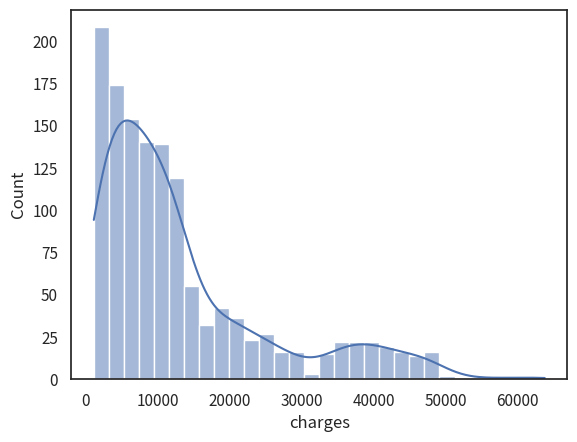

In [ ]:
sb.histplot(ydf['charges'], kde=True)

2. 링크 함수 적합성 : 
smoker 계수 > 0 인가? 만족
age, bmi 계수 방향이 상식적인가? 만족

In [ ]:
ydf[['bmi', 'age']].describe()

,bmi,age
count,1338.000000,1338.000000
mean,30.663397,39.207025
std,6.098187,14.049960
min,15.960000,18.000000
25%,26.296250,27.000000
50%,30.400000,39.000000
75%,34.693750,51.000000
max,53.130000,64.000000


3. GLM 잔차 확인 :  패턴이 없고 0을 중심으로 대칭적으로 분포하지 않음 즉 선형성 가정 위반

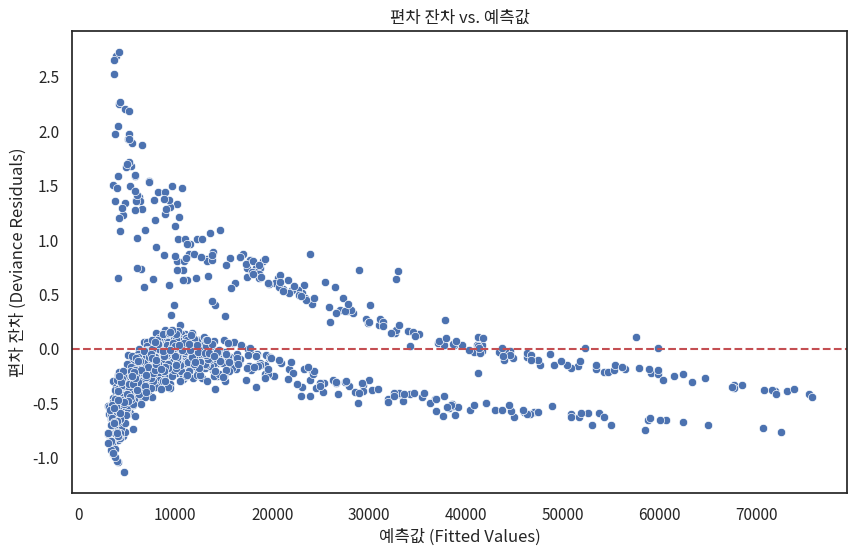

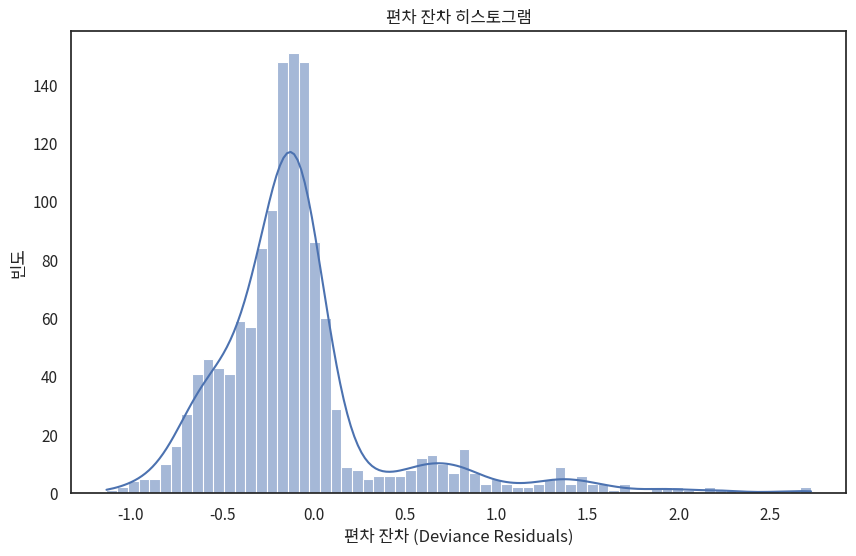

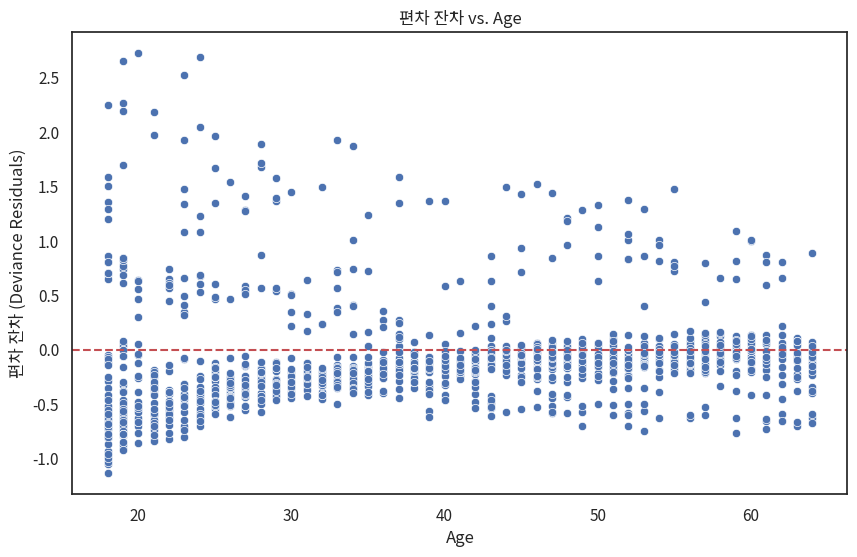

In [ ]:
# 1. 잔차 추출
deviance_residuals = model_glm.resid_deviance
pearson_residuals = model_glm.resid_pearson

# 예측값 추출 (잔차 vs 예측값 플롯에 필요)
fitted_values = model_glm.fittedvalues

# 2. 잔차 vs. 예측값 플롯 (등분산성 및 패턴 확인)
# 이상적으로는 0을 중심으로 무작위로 분포되어야 합니다.
plt.figure(figsize=(10, 6))
sb.scatterplot(x=fitted_values, y=deviance_residuals) # 또는 pearson_residuals
plt.axhline(y=0, color='r', linestyle='--')
plt.title('편차 잔차 vs. 예측값')
plt.xlabel('예측값 (Fitted Values)')
plt.ylabel('편차 잔차 (Deviance Residuals)')
plt.show()

# 3. 잔차 히스토그램 (잔차 분포의 대략적인 형태 확인)
# 0을 중심으로 대략적으로 대칭적인 분포를 보이는 것이 좋습니다.
plt.figure(figsize=(10, 6))
sb.histplot(deviance_residuals, kde=True) # 또는 pearson_residuals
plt.title('편차 잔차 히스토그램')
plt.xlabel('편차 잔차 (Deviance Residuals)')
plt.ylabel('빈도')
plt.show()

# 4. 잔차 vs. 각 독립 변수 (선형성 가정 위반 여부 확인)
# 각 독립 변수와 잔차 사이에 패턴이 없어야 합니다.
# 예시: 'age' 변수에 대해
# 만약 model_glm을 만들 때 사용한 데이터프레임이 df_encoded라면
# df_encoded['age']를 사용합니다.
plt.figure(figsize=(10, 6))
sb.scatterplot(x=model_glm.model.exog[:, model_glm.model.exog_names.index('age')], y=deviance_residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('편차 잔차 vs. Age')
plt.xlabel('Age')
plt.ylabel('편차 잔차 (Deviance Residuals)')
plt.show()

다중공선성확인 확인

In [ ]:
ydf.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges',
       'log_charges', 'charges_bc', 'age_log', 'bmi_log', 'age2', 'bmi2'],
      dtype='object')

In [ ]:
ydfv = ydf.copy()
ydfv = ydfv.drop(columns = ['log_charges', 'charges_bc', 'age_log', 'bmi_log', 'age2', 'bmi2'])

In [ ]:
ydfve = pd.get_dummies(ydfv, dtype = 'int', drop_first=True)
ydfve.head(3)

,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19,27.90,0,16884.9240,0,1,0,0,1
1,18,33.77,1,1725.5523,1,0,0,1,0
2,28,33.00,3,4449.4620,1,0,0,1,0


타겟 데이터 분리

In [ ]:
ydfve1 = ydfve.copy()
Y = ydfve1.pop('charges')
print(ydfve1.shape, ydfve.shape)

(1338, 8) (1338, 9)


In [ ]:
vif_list2 = []
for i in range(ydfve1.shape[1]):
    vif_values = variance_inflation_factor(ydfve1.values, i)
    vif_list2.append(vif_values)
yv = pd.DataFrame({
    'feature' : ydfve1.columns,
    'VIF' : vif_list2
})
yv

,feature,VIF
0,age,7.686965
1,bmi,11.358443
2,children,1.809930
3,sex_male,2.003185
4,smoker_yes,1.261233
5,region_northwest,1.890281
6,region_southeast,2.265564
7,region_southwest,1.960745


왜 vif 임계값이 11이 넘는 bmi를 제거하지 않았느냐?
1. 이론적으로 필수 변수이므로 제거하지 않음
2. 다중공선성은 예측력보다 계수 안정성 문제
3. 분석 목적상 유지가 합리적

Gamma GLM (log link) 회귀식
charges = exp(7.3863 - 0.0571 * sex_male
 + 1.5003 * smoker_yes
 - 0.0579 * region_northwest
 - 0.1416 * region_southeast
 - 0.1455 * region_southwest
 + 0.0286 * age
 + 0.0141 * bmi
 + 0.0842 * children)

## 미션 5. 연령 그룹별 회귀분석

<종합 결론>

본 연구는 보험 의료비 데이터에 대해 연령대별 Gamma GLM 분석을 수행한 결과, 흡연 여부가 모든 연령대에서 의료비에 가장 큰 영향을 미치는 핵심 요인임을 확인하였다. 특히 젊은 연령대에서는 흡연으로 인한 의료비의 상대적 증가 폭이 매우 크게 나타났으며, 연령이 증가할수록 그 배수 효과는 완만해지는 경향을 보였다. 나이와 자녀 수는 전반적으로 의료비 증가와 양의 관계를 보였고, BMI는 중·장년층에서 누적적 건강 위험 요인으로 작용하였다. 반면 성별과 지역 변수는 대부분의 연령대에서 유의하지 않아, 의료비 예측에서의 설명력은 제한적인 것으로 나타났다.


1. smoker
- 연령대와 모형에 관계없이, 흡연 여부는 의료비에 가장 큰 영향을 미치는 요인으로
모든 분석에서 일관되게 확인되었다.

<비흡연자 대비 흡연자의 charges >
- 전체 데이터: 약 4.5배
- 18–24세: 약 7.6배
- 25–34세(OLS): 약 176% 증가
- 24-34세(GLM): 약 5배
- 35–44세: 약 4배
- 45–64세: 약 3배
---------------------------------------------------------------------------------

2. age_group 변수 
- 나이는 거의 모든 Gamma GLM 모형에서 의료비 증가와 유의한 양의 관계를 보였으나,
그 효과 크기는 연령대별로 상이하게 나타났다.

- 18–24세: 1세 증가 시 약 7.5% 증가
- 25-34세: ❌ 유의하지 않음
- 35–44세: 약 3.0% 증가
- 45–64세: 약 2.4% 증가

> 젊은 연령대에서는 나이 증가 자체가 건강 위험 증가를 더 민감하게 반영
> 고연령대에서는 이미 위험이 누적 → 한 살의 추가 효과는 상대적으로 작음
---------------------------------------------------------------------------------

3. children 변수
- 자녀 수는 모든 연령대에서 의료비 증가와 양의 관계를 보였으나,
젊은 연령대에서 그 효과가 특히 크게 나타났다.

- 18–24세: 1명 증가 시 약 24% 증가
- 25-34세: 약 10% 증가
- 35–44세: 약 9% 증가
- 45–64세: 약 4% 증가

>젊은 연령대에서는 출산·육아 관련 의료비 가족 단위 의료 이용 증가로 예상
---------------------------------------------------------------------------------


4. BMI 변수
- BMI는 중·장년층에서 의료비 증가와 유의한 관계를 보였으나,
젊은 연령대에서는 통계적으로 뚜렷하지 않았다.

- 18–24세: ❌ 유의하지 않음
- 25-34세: 1 증가 시 약 1.0% 증가
- 35–44세: 약 2.6% 증가
- 45–64세: 약 0.7% 증가

> BMI의 건강 영향은 시간이 누적되며 의료비로 반영
> 단기적 영향보다는 장기적 위험 요인
---------------------------------------------------------------------------------


5. region 변수
- 지역 변수가 유의했던 그룹은 2개로 25-34, 35-44가 이에 해당한다. 두 그룹에서는 '북동부 > 남동부, 남서부'의 경향을 보였다.

In [ ]:
ydf2 = load_data('insurance')

[data] https://data.hossam.kr/data/kaggle/insurance.xlsx
[desc] 개인의 나이·성별·BMI·흡연 여부·거주 지역 등 기본 건강·인구학적 정보를 바탕으로 의료보험 청구 비용(charges)을 예측하도록 구성된, 선형회귀와 머신러닝 실습에 널리 사용되는 대표적인 보험 비용 데이터셋 (출처: https://www.kaggle.com/datasets/mirichoi0218/insurance)

변수명    의미(설명)
--------  ---------------------------------------------------------------
age       가입자의 나이(세).
sex       성별 (male, female).
bmi       체질량 지수(Body Mass Index).
children  부양 자녀 수(보험 내 자녀 수).
smoker    흡연 여부 (yes / no).
region    미국 내 거주 지역 (northeast, northwest, southeast, southwest).
charges   의료보험 청구 비용(달러). 예측해야 하는 타깃 변수.



In [ ]:
# NCHS 기준 age 구간화
bins = [18, 24, 34, 44, 64]
labels = ['18-24', '25-34', '35-44', '45-64']

ydf2['age_group'] = pd.cut(
    ydf2['age'],
    bins=bins,
    labels=labels,
    include_lowest=True,
    right=True
)
ydf2.head(3)

,age,sex,bmi,children,smoker,region,charges,age_group
0,19,female,27.90,0,yes,southwest,16884.9240,18-24
1,18,male,33.77,1,no,southeast,1725.5523,18-24
2,28,male,33.00,3,no,southeast,4449.4620,25-34


In [ ]:
ydf2['log_charges'] = np.log(ydf2['charges'])

In [ ]:
ydf18 = ydf2[ydf2['age_group'] == '18-24']
ydf25 = ydf2[ydf2['age_group'] == '25-34']
ydf35 = ydf2[ydf2['age_group'] == '35-44']
ydf45 = ydf2[ydf2['age_group'] == '45-64']
ydf18.head(3)

,age,sex,bmi,children,smoker,region,charges,age_group,log_charges
0,19,female,27.90,0,yes,southwest,16884.9240,18-24,9.734176
1,18,male,33.77,1,no,southeast,1725.5523,18-24,7.453302
12,23,male,34.40,0,no,southwest,1826.8430,18-24,7.510345


#### 18-24 그룹

In [ ]:
model18 = ols('log_charges ~ C(sex) + bmi + children + C(smoker) + C(region)', data = ydf18) .fit()
stats.shapiro(model18.resid)

ShapiroResult(statistic=np.float64(0.7142523651954531), pvalue=np.float64(1.6646684657090636e-21))

1. 정규성 검정, 결과 : 정규성 만족 안함, 하지만 qq플롯으로본 결과 비교적 회귀직선에 따르므로 회귀분석 그냥 진행가능

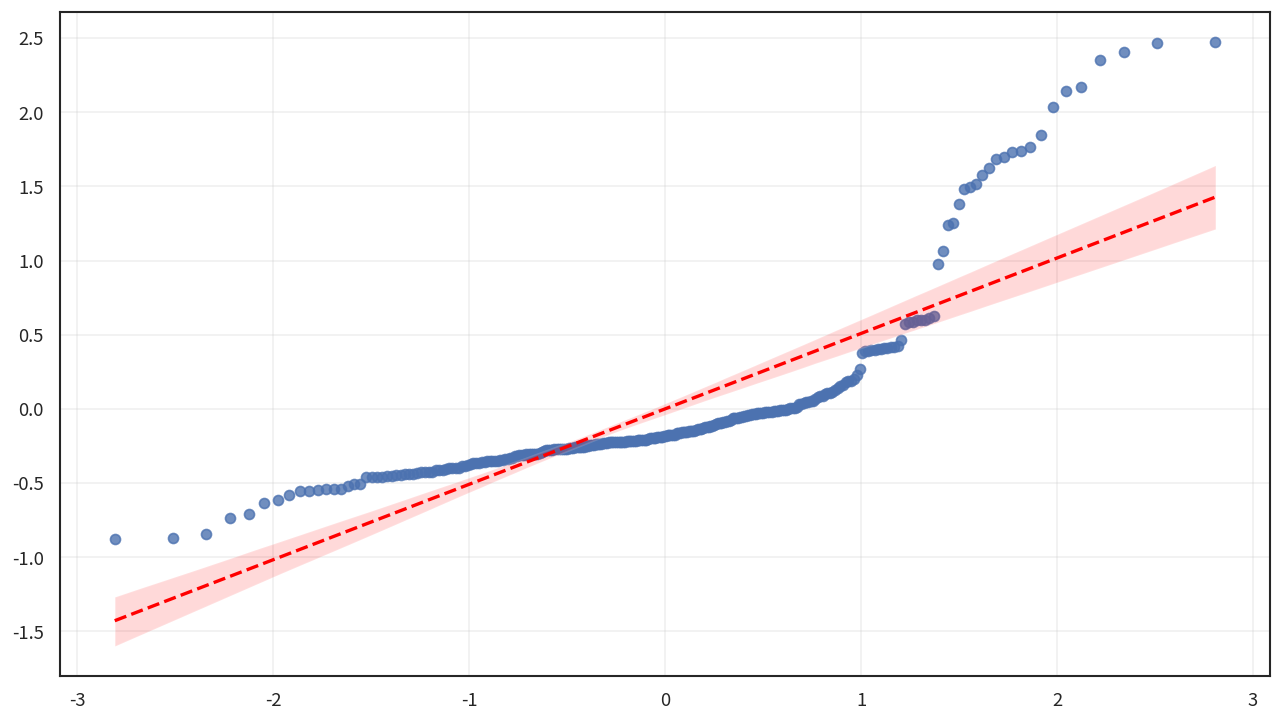

In [ ]:
(x, y), _ = probplot(model18.resid)

width_px  = 1280
height_px = 720
rows = 1
cols = 1
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

# 2) regplot 그리기
sb.regplot(x=x, y=y, line_kws={
"color": "red",
"linestyle": "--",   
"linewidth": 2
            })
# 3) 그래프 꾸미기
ax.grid(True, alpha=0.3)           

plt.tight_layout()      
plt.show()              
plt.close()             

2. 선형성 검정, 결과 : 위배 가능성 있음

In [ ]:
reset_res = linear_reset(model18, power=2, use_f=True)
print(f"RESET F-statistic: {reset_res.fvalue:.4f}")
print(f"p-value: {reset_res.pvalue:.4f}")
if reset_res.pvalue < 0.05:
    print("선형성/기능형 위배 가능성이 있음 (5% 유의수준)")
else:
    print("선형성 가정 위배 근거 없음 (5% 유의수준)")

RESET F-statistic: 8.5834
p-value: 0.0037
선형성/기능형 위배 가능성이 있음 (5% 유의수준)


3.  잔차의 독립성 검정, 결과 : 독립성 만족

In [ ]:
dw = durbin_watson(model18.resid)

if 1.5 <= dw <= 2.5:
    interpretation = "잔차는 독립성을 만족함 (자기상관 없음)"
elif dw < 1.5:
    interpretation = "잔차에 양(+)의 자기상관이 존재할 가능성 있음 (독립성 위반)"
else:
    interpretation = "잔차에 음(–)의 자기상관이 존재할 가능성 있음 (독립성 위반)"

print(f"Durbin–Watson: {dw:.3f}")
print(interpretation)

Durbin–Watson: 1.867
잔차는 독립성을 만족함 (자기상관 없음)


4. 등분산성 검정, 결과 : 등분산

In [ ]:
# Breusch–Pagan Test
names = ['LM Statistic', 'LM p-value', 'F Statistic', 'F p-value']
bp_test = het_breuschpagan(model18.resid, model18.model.exog)
bp = DataFrame(bp_test, index=names, columns=['value'])

# p-value는 F p-value를 기준으로 사용
p_bp = bp.loc['F p-value', 'value']

print(f"Breusch–Pagan statistic: {bp.loc['F Statistic','value']:.3f}, p-value = {p_bp:.3f}")
print(f"{'이분산성 존재(등분산 아님)' if p_bp <= 0.05 else '등분산성 만족'}")

Breusch–Pagan statistic: 0.506, p-value = 0.829
등분산성 만족


선형성 만족을 위한 다항식 추가하여 회귀분석 진행 실시, bmi만 넣기

In [ ]:
model18 = ols('log_charges ~ C(sex) + bmi + bmi**2 + children + C(smoker) + C(region)', data = ydf18) .fit()
reset_res = linear_reset(model18, power=2, use_f=True)
print(f"RESET F-statistic: {reset_res.fvalue:.4f}")
print(f"p-value: {reset_res.pvalue:.4f}")
if reset_res.pvalue < 0.05:
    print("선형성/기능형 위배 가능성이 있음 (5% 유의수준)")
else:
    print("선형성 가정 위배 근거 없음 (5% 유의수준)")

RESET F-statistic: 8.5834
p-value: 0.0037
선형성/기능형 위배 가능성이 있음 (5% 유의수준)


선형성, 등분산성을 위한 다항식 추가하여 회귀분석 진행 실시, children만 넣기

In [ ]:
model18 = ols('log_charges ~ C(sex) + bmi + children + children**2 + C(smoker) + C(region)', data = ydf18) .fit()
reset_res = linear_reset(model18, power=2, use_f=True)
print(f"RESET F-statistic: {reset_res.fvalue:.4f}")
print(f"p-value: {reset_res.pvalue:.4f}")
if reset_res.pvalue < 0.05:
    print("선형성/기능형 위배 가능성이 있음 (5% 유의수준)")
else:
    print("선형성 가정 위배 근거 없음 (5% 유의수준)")

RESET F-statistic: 8.5834
p-value: 0.0037
선형성/기능형 위배 가능성이 있음 (5% 유의수준)


In [ ]:
# Breusch–Pagan Test
names = ['LM Statistic', 'LM p-value', 'F Statistic', 'F p-value']
bp_test = het_breuschpagan(model18.resid, model18.model.exog)
bp = DataFrame(bp_test, index=names, columns=['value'])

# p-value는 F p-value를 기준으로 사용
p_bp = bp.loc['F p-value', 'value']

print(f"Breusch–Pagan statistic: {bp.loc['F Statistic','value']:.3f}, p-value = {p_bp:.3f}")
print(f"{'이분산성 존재(등분산 아님)' if p_bp <= 0.05 else '등분산성 만족'}")

Breusch–Pagan statistic: 0.506, p-value = 0.829
등분산성 만족


선형성, 등분산성을 위한 다항식 추가하여 회귀분석 진행 실시, children, bmi둘다 넣기

In [ ]:
model18 = ols('log_charges ~ C(sex) + bmi + bmi**2 + children + children**2 + C(smoker) + C(region)', data = ydf18) .fit()
reset_res = linear_reset(model18, power=2, use_f=True)
print(f"RESET F-statistic: {reset_res.fvalue:.4f}")
print(f"p-value: {reset_res.pvalue:.4f}")
if reset_res.pvalue < 0.05:
    print("선형성/기능형 위배 가능성이 있음 (5% 유의수준)")
else:
    print("선형성 가정 위배 근거 없음 (5% 유의수준)")

RESET F-statistic: 8.5834
p-value: 0.0037
선형성/기능형 위배 가능성이 있음 (5% 유의수준)


잔차–예측값 산점도에서 이분산성과 비선형 패턴이 확인되었다. 로그 변환, 다항항 추가, 상호작용항 포함 등 모형 재설정에도 불구하고 이러한 가정 위배는 해소되지 않았다. 이에 종속변수의 분포 특성을 직접 반영할 수 있는 Gamma GLM을 적용 실시

In [ ]:
import statsmodels.formula.api as smf
model18_glm = smf.glm(
    formula='charges ~ age + C(sex) +bmi + children + C(smoker) + C(region)',
    data=ydf18,
    family=sm.families.Gamma(link=sm.families.links.log())
).fit()
print(model18_glm.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                charges   No. Observations:                  278
Model:                            GLM   Df Residuals:                      269
Model Family:                   Gamma   Df Model:                            8
Link Function:                    log   Scale:                          1.4376
Method:                          IRLS   Log-Likelihood:                -2714.6
Date:                Fri, 16 Jan 2026   Deviance:                       150.42
Time:                        10:54:42   Pearson chi2:                     387.
No. Iterations:                    19   Pseudo R-squ. (CS):             0.4826
Covariance Type:            nonrobust                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  6

c:\Users\itwill\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\genmod\families\links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(


GLM 기본가정 만족여부
1. 분포가정
2. 링크 함수 적합성
3. GLM 잔차 확인

1. 분포 가정 : 우측꼬리 모형, 독립변수 종속변수 모두 양수 ? 만족

<Axes: xlabel='charges', ylabel='Count'>

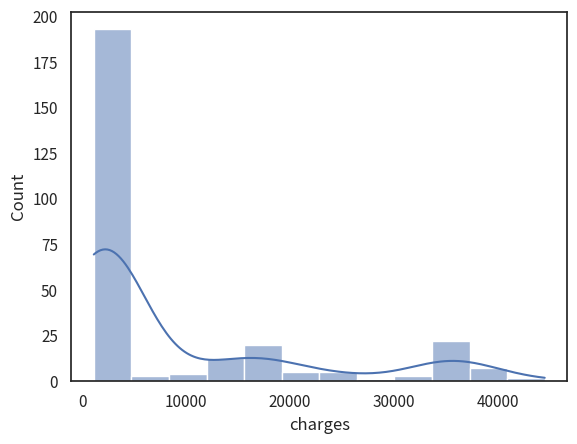

In [ ]:
sb.histplot(ydf18['charges'], kde=True)

2. 링크 함수 적합성 : 
smoker 계수 > 0 인가? 만족
age, bmi 계수 방향이 상식적인가? 만족

In [ ]:
ydf18[['bmi', 'age']].describe()

,bmi,age
count,278.000000,278.000000
mean,30.038921,20.266187
std,6.345378,2.050185
min,15.960000,18.000000
25%,25.591250,19.000000
50%,30.107500,20.000000
75%,34.100000,22.000000
max,53.130000,24.000000


3. GLM 잔차 확인 :
편차잔차 vs 예측값
낮은 예측값 구간에서 잔차 분산 큼
예측값 증가할수록 잔차가 음의 방향으로 쏠림
완전한 적합은 아님, 하지만
ols에서 보이던 깔때기형 이분산보다는 완화됨

편차잔차 히스토그램
우측 꼬리 긴 비대칭 분포, 정상
gamma GLM에서는 정규성 요구 안 함

편차잔차 vs age
나이별 구조적 곡선 패턴은 없음
다만 특정 연령대(18~19, 23~24)에 큰 양의 잔차 존재
age 단독 설명력 한계 or 다른 변수 누락 가능성

정리 : 잔차 진단 결과 일부 구간 변동성이 있으나 ols보다 구조가 완화된 모양을 보여 본 모형을 채택하였다.

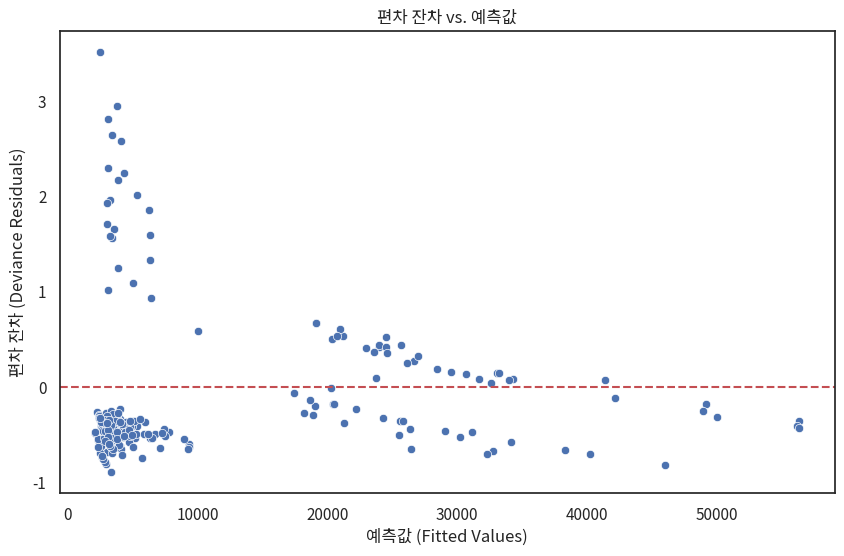

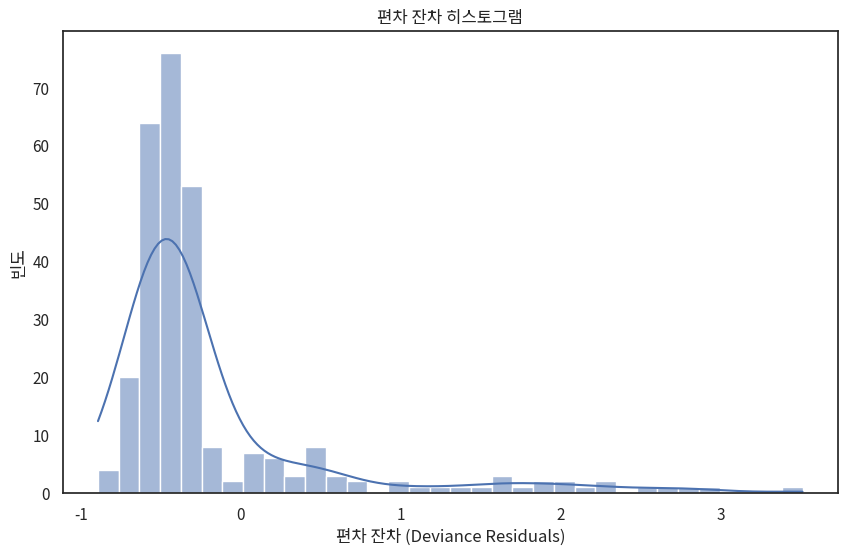

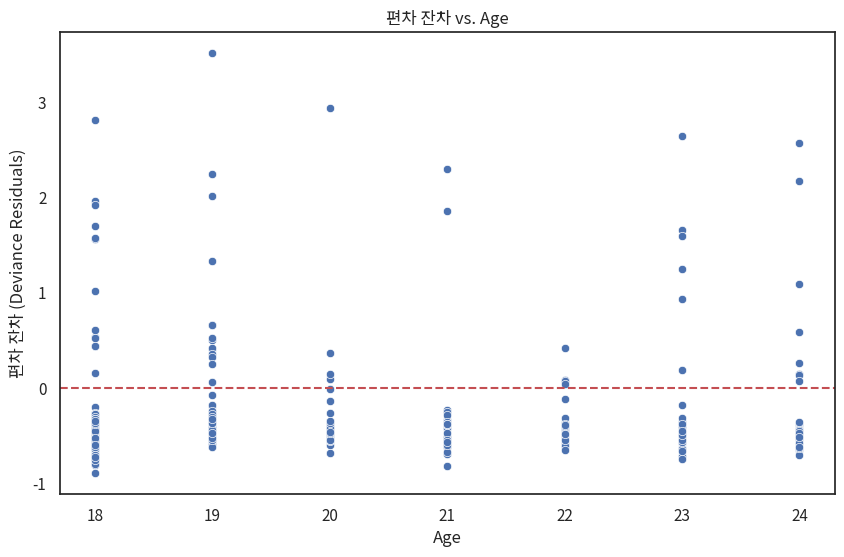

In [ ]:
# 1. 잔차 추출
deviance_residuals = model18_glm.resid_deviance
pearson_residuals = model18_glm.resid_pearson

# 예측값 추출 (잔차 vs 예측값 플롯에 필요)
fitted_values = model18_glm.fittedvalues

# 2. 잔차 vs. 예측값 플롯 (등분산성 및 패턴 확인)
# 이상적으로는 0을 중심으로 무작위로 분포되어야 합니다.
plt.figure(figsize=(10, 6))
sb.scatterplot(x=fitted_values, y=deviance_residuals) # 또는 pearson_residuals
plt.axhline(y=0, color='r', linestyle='--')
plt.title('편차 잔차 vs. 예측값')
plt.xlabel('예측값 (Fitted Values)')
plt.ylabel('편차 잔차 (Deviance Residuals)')
plt.show()

# 3. 잔차 히스토그램 (잔차 분포의 대략적인 형태 확인)
# 0을 중심으로 대략적으로 대칭적인 분포를 보이는 것이 좋습니다.
plt.figure(figsize=(10, 6))
sb.histplot(deviance_residuals, kde=True) # 또는 pearson_residuals
plt.title('편차 잔차 히스토그램')
plt.xlabel('편차 잔차 (Deviance Residuals)')
plt.ylabel('빈도')
plt.show()

# 4. 잔차 vs. 각 독립 변수 (선형성 가정 위반 여부 확인)
# 각 독립 변수와 잔차 사이에 패턴이 없어야 합니다.
# 예시: 'age' 변수에 대해
# 만약 model_glm을 만들 때 사용한 데이터프레임이 df_encoded라면
# df_encoded['age']를 사용합니다.
plt.figure(figsize=(10, 6))
sb.scatterplot(x=model18_glm.model.exog[:, model18_glm.model.exog_names.index('age')], y=deviance_residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('편차 잔차 vs. Age')
plt.xlabel('Age')
plt.ylabel('편차 잔차 (Deviance Residuals)')
plt.show()

다중공선성 확인, 처리

In [ ]:
ydf18.head(3)

,age,sex,bmi,children,smoker,region,charges,age_group,log_charges
0,19,female,27.90,0,yes,southwest,16884.9240,18-24,9.734176
1,18,male,33.77,1,no,southeast,1725.5523,18-24,7.453302
12,23,male,34.40,0,no,southwest,1826.8430,18-24,7.510345


In [ ]:
ydf18_1 = ydf18.copy()
ydf18_1 = ydf18_1.drop(columns = ['age_group', 'charges', 'age'])
ydf18e = pd.get_dummies(ydf18_1, dtype = 'int', drop_first = True)
print(ydf18e.shape)

(278, 8)


타겟 데이터 분리

In [ ]:
ydf18ev = ydf18e.copy()
Y = ydf18ev.pop('log_charges')
print(ydf18ev.shape, ydf18ev.shape)

(278, 7) (278, 7)


In [ ]:
vif_list2 = []
for i in range(ydf18ev.shape[1]):
    vif_values = variance_inflation_factor(ydf18ev.values, i)
    vif_list2.append(vif_values)
yv = pd.DataFrame({
    'feature' : ydf18ev.columns,
    'VIF' : vif_list2
})
yv

,feature,VIF
0,bmi,5.556422
1,children,1.319968
2,sex_male,1.987728
3,smoker_yes,1.287882
4,region_northwest,1.892505
5,region_southeast,2.372029
6,region_southwest,1.874970


vif 10이상 없음

<18-24>
- 모형: Generalized Linear Model (Gamma)
- 링크 함수: log
- 종속변수: charges
- 관측치 수: 278
- Pseudo R² (Cox–Snell): 0.4826
- Scale: 1.4376


| 변수 | 계수 (β) | exp(β) | p-value | 해석 |
|---|---:|---:|---:|---|
| Intercept | 6.3640 | 582 | <0.001 | 기준 집단의 평균 의료비 |
| Male (vs Female) | -0.1533 | 0.86 | 0.287 | 성별 효과 없음 |
| Smoker (Yes vs No) | 2.0310 | 7.62 | <0.001 | 흡연자는 비흡연자 대비 의료비 약 7.6배 증가 |
| Region: Northwest | 0.0293 | 1.03 | 0.888 | 지역 효과 없음 |
| Region: Southeast | -0.0705 | 0.93 | 0.738 | 지역 효과 없음 |
| Region: Southwest | -0.1927 | 0.82 | 0.358 | 지역 효과 없음 |
| Age (1세 증가) | 0.0721 | 1.07 | 0.043 | 나이 1세 증가 시 의료비 약 7.5% 증가 |
| BMI (1 증가) | 0.0126 | 1.01 | 0.300 | BMI 효과 유의하지 않음 |
| Children (1명 증가) | 0.2126 | 1.24 | 0.002 | 자녀 수 1명 증가 시 의료비 약 24% 증가 |


Gamma GLM(log link) 분석 결과, 흡연 여부는 의료비에 가장 큰 영향을 미치는 요인으로 나타났으며,
흡연자의 평균 의료비는 비흡연자 대비 약 7.6배 높았다(p < 0.001).
이는 다른 표본들에 비해 흡연 효과가 특히 크게 추정된 결과이다.
또한 나이와 자녀 수는 의료비 증가와 유의한 양의 관계를 보였으며,
특히 자녀 수는 1명 증가 시 의료비를 약 24% 증가시키는 것으로 나타났다.
반면 BMI, 성별, 지역 변수는 통계적으로 유의하지 않았다.

#### 25-34 그룹

##### (1) OLS

1. 정규성 검정, 결과 : 정규성 만족 안함, 하지만 qq플롯으로본 결과 비교적 회귀직선에 따르므로 회귀분석 그냥 진행가능

In [ ]:
model25 = ols('log_charges ~ C(sex) + bmi + children + C(smoker) + C(region)', data = ydf25).fit()
stats.shapiro(model25.resid)

ShapiroResult(statistic=np.float64(0.7975905511400012), pvalue=np.float64(4.658809228388034e-18))

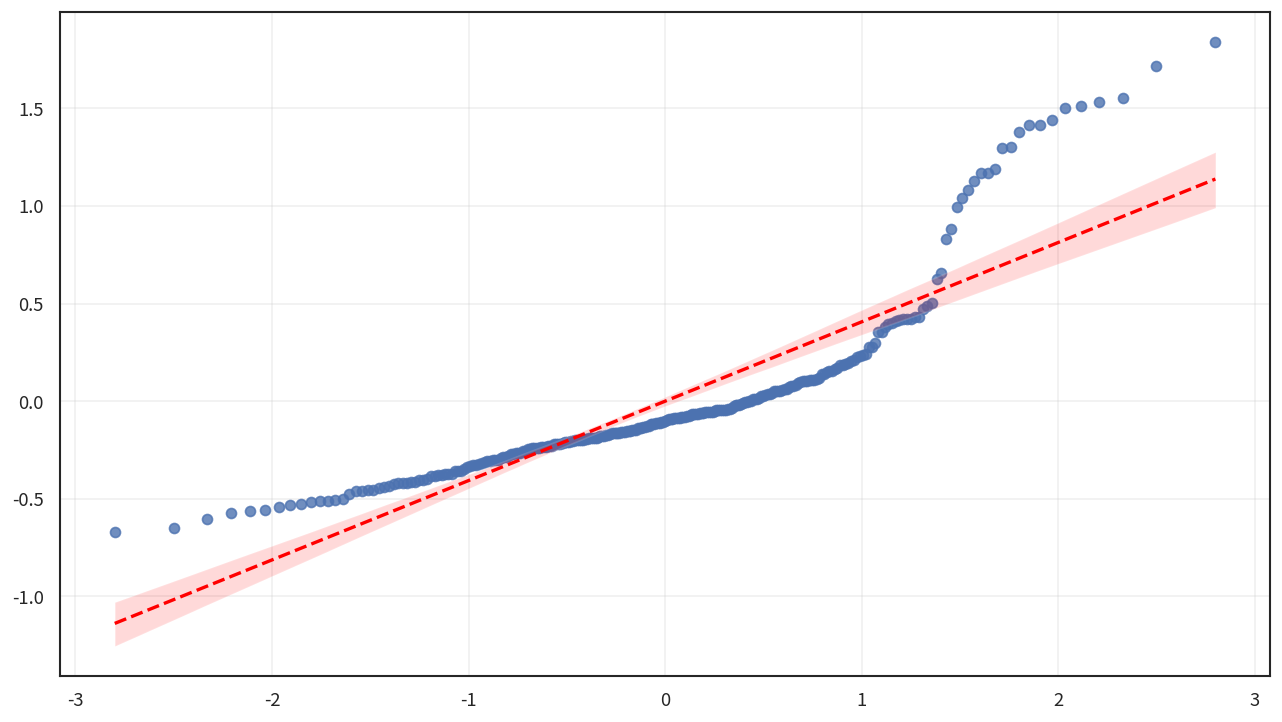

In [ ]:
(x, y), _ = probplot(model25.resid)

width_px  = 1280
height_px = 720
rows = 1
cols = 1
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

# 2) regplot 그리기
sb.regplot(x=x, y=y, line_kws={
"color": "red",
"linestyle": "--",   
"linewidth": 2
            })
# 3) 그래프 꾸미기
ax.grid(True, alpha=0.3)           

plt.tight_layout()      
plt.show()              
plt.close()             

2. 선형성 검정, 결과 : 선형성 만족

In [ ]:
reset_res = linear_reset(model25, power=2, use_f=True)
print(f"RESET F-statistic: {reset_res.fvalue:.4f}")
print(f"p-value: {reset_res.pvalue:.4f}")
if reset_res.pvalue < 0.05:
    print("선형성/기능형 위배 가능성이 있음 (5% 유의수준)")
else:
    print("선형성 가정 위배 근거 없음 (5% 유의수준)")

RESET F-statistic: 0.0159
p-value: 0.8998
선형성 가정 위배 근거 없음 (5% 유의수준)


3.  잔차의 독립성 검정, 결과 : 독립성 만족

In [ ]:
dw = durbin_watson(model25.resid)

if 1.5 <= dw <= 2.5:
    interpretation = "잔차는 독립성을 만족함 (자기상관 없음)"
elif dw < 1.5:
    interpretation = "잔차에 양(+)의 자기상관이 존재할 가능성 있음 (독립성 위반)"
else:
    interpretation = "잔차에 음(–)의 자기상관이 존재할 가능성 있음 (독립성 위반)"

print(f"Durbin–Watson: {dw:.3f}")
print(interpretation)

Durbin–Watson: 1.978
잔차는 독립성을 만족함 (자기상관 없음)


4. 등분산성 검정, 결과 : 등분산

In [ ]:
# Breusch–Pagan Test
names = ['LM Statistic', 'LM p-value', 'F Statistic', 'F p-value']
bp_test = het_breuschpagan(model25.resid, model25.model.exog)
bp = DataFrame(bp_test, index=names, columns=['value'])

# p-value는 F p-value를 기준으로 사용
p_bp = bp.loc['F p-value', 'value']

print(f"Breusch–Pagan statistic: {bp.loc['F Statistic','value']:.3f}, p-value = {p_bp:.3f}")
print(f"{'이분산성 존재(등분산 아님)' if p_bp <= 0.05 else '등분산성 만족'}")

Breusch–Pagan statistic: 1.038, p-value = 0.405
등분산성 만족


25-34 그룹에 대한 다중공선성 확인

In [ ]:
ydf25v = ydf25.copy()
ydf25ve = pd.get_dummies(ydf25v, dtype = 'int', drop_first = True)
Y = ydf25ve.pop('log_charges')

In [ ]:
ydf25ve.columns

Index(['age', 'bmi', 'children', 'charges', 'sex_male', 'smoker_yes',
       'region_northwest', 'region_southeast', 'region_southwest',
       'age_group_25-34', 'age_group_35-44', 'age_group_45-64'],
      dtype='object')

In [ ]:
ydf25ve = ydf25ve.drop(columns = ['age_group_25-34', 'age_group_35-44', 'age_group_45-64', 'age'])

In [ ]:
vif_list2 = []
for i in range(ydf25ve.shape[1]):
    vif_values = variance_inflation_factor(ydf25ve.values, i)
    vif_list2.append(vif_values)
yv = pd.DataFrame({
    'feature' : ydf25ve.columns,
    'VIF' : vif_list2
})
yv

,feature,VIF
0,bmi,7.720701
1,children,2.131729
2,charges,5.878185
3,sex_male,2.159064
4,smoker_yes,4.003005
5,region_northwest,1.938699
6,region_southeast,2.501942
7,region_southwest,2.092429


회귀분석 후 유의하지 않는 독립변수 제거 실시

In [ ]:
print(model25.summary())

                            OLS Regression Results                            
Dep. Variable:            log_charges   R-squared:                       0.715
Model:                            OLS   Adj. R-squared:                  0.707
Method:                 Least Squares   F-statistic:                     94.11
Date:                Fri, 16 Jan 2026   Prob (F-statistic):           6.38e-68
Time:                        10:54:43   Log-Likelihood:                -169.07
No. Observations:                 271   AIC:                             354.1
Df Residuals:                     263   BIC:                             383.0
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  7

In [ ]:
ydf25e = ydf25.copy()
ydf25e = pd.get_dummies(ydf25e, dtype = 'int', drop_first = True)
ydf25e.columns

Index(['age', 'bmi', 'children', 'charges', 'log_charges', 'sex_male',
       'smoker_yes', 'region_northwest', 'region_southeast',
       'region_southwest', 'age_group_25-34', 'age_group_35-44',
       'age_group_45-64'],
      dtype='object')

In [ ]:
model25 = ols('log_charges ~ bmi + children + sex_male + smoker_yes + region_northwest + region_southeast + region_southwest', data = ydf25e).fit()
print(model25.summary())

                            OLS Regression Results                            
Dep. Variable:            log_charges   R-squared:                       0.715
Model:                            OLS   Adj. R-squared:                  0.707
Method:                 Least Squares   F-statistic:                     94.11
Date:                Fri, 16 Jan 2026   Prob (F-statistic):           6.38e-68
Time:                        10:54:43   Log-Likelihood:                -169.07
No. Observations:                 271   AIC:                             354.1
Df Residuals:                     263   BIC:                             383.0
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            7.9382      0.149  

유의성 충족하지 않아 sex_male 먼저 삭제 

In [ ]:
model25 = ols('log_charges ~ bmi + children + smoker_yes + region_northwest + region_southeast + region_southwest', data = ydf25e).fit()
print(model25.summary())

                            OLS Regression Results                            
Dep. Variable:            log_charges   R-squared:                       0.712
Model:                            OLS   Adj. R-squared:                  0.706
Method:                 Least Squares   F-statistic:                     108.8
Date:                Fri, 16 Jan 2026   Prob (F-statistic):           1.88e-68
Time:                        10:54:43   Log-Likelihood:                -170.28
No. Observations:                 271   AIC:                             354.6
Df Residuals:                     264   BIC:                             379.8
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            7.9325      0.149  

유의성 충족하지 않아 그 다음으로 region_northwest 삭제 

In [ ]:
model25f1 = ols('log_charges ~ sex_male + bmi + children + smoker_yes + region_southeast + region_southwest', data = ydf25e).fit()
print(model25f1.summary())

                            OLS Regression Results                            
Dep. Variable:            log_charges   R-squared:                       0.711
Model:                            OLS   Adj. R-squared:                  0.705
Method:                 Least Squares   F-statistic:                     108.5
Date:                Fri, 16 Jan 2026   Prob (F-statistic):           2.60e-68
Time:                        10:54:43   Log-Likelihood:                -170.62
No. Observations:                 271   AIC:                             355.2
Df Residuals:                     264   BIC:                             380.5
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            7.8830      0.146  

둘 다 삭제

In [ ]:
model25f = ols('log_charges ~ bmi + children + smoker_yes + region_southeast + region_southwest', data = ydf25e).fit()
print(model25f.summary())

                            OLS Regression Results                            
Dep. Variable:            log_charges   R-squared:                       0.709
Model:                            OLS   Adj. R-squared:                  0.703
Method:                 Least Squares   F-statistic:                     129.0
Date:                Fri, 16 Jan 2026   Prob (F-statistic):           6.84e-69
Time:                        10:54:43   Log-Likelihood:                -171.80
No. Observations:                 271   AIC:                             355.6
Df Residuals:                     265   BIC:                             377.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            7.8776      0.146  

In [ ]:
model25f.params[:]

Intercept           7.877570
bmi                 0.018089
children            0.100342
smoker_yes          1.745186
region_southeast   -0.208557
region_southwest   -0.141591
dtype: float64

회귀식 : 25-34 구간 charge_log^ = 7.877570 + 0.018089 * bmi^ + 0.100342 * children^ + 1.745186 * smoker_yes^ -0.208557 * region_southeast^ -0.141591 * region_southwest^

<25-34> *혼자 일반 OLS

log(charges)를 종속변수로 한 OLS 회귀 분석 결과,
흡연 여부는 의료비에 가장 큰 영향을 미치는 요인으로 나타났다.
흡연자는 비흡연자 대비 의료비가 약 176% 높았으며(p < 0.001),
이는 다른 변수들의 효과를 크게 상회하는 수준이다.
BMI와 자녀 수 또한 의료비 증가와 유의한 양의 관계를 보였고,
남동부 및 남서부 지역은 기준 지역 대비 의료비가 유의하게 낮았다.
반면 성별은 통계적으로 유의한 영향을 미치지 않았다.



모형 정보
- 모형: Ordinary Least Squares (OLS)
- 종속변수: log(charges)
- 관측치 수: 271
- R-squared: 0.715
- Adjusted R-squared: 0.707


| 변수 | 계수 (β) | p-value | 해석 |
|---|---:|---:|---|
| Intercept | 7.938 | <0.001 | 기준 집단의 평균 log 의료비 |
| Male (vs Female) | -0.088 | 0.126 | 성별에 따른 의료비 차이 없음 |
| Smoker (Yes vs No) | 1.763 | <0.001 | 흡연자는 의료비 약 176% 증가 |
| Region: Northwest | -0.140 | 0.083 | 약 14% 감소 (유의하지 않음) |
| Region: Southeast | -0.284 | 0.001 | 약 28% 감소 |
| Region: Southwest | -0.216 | 0.009 | 약 22% 감소 |
| BMI (1 증가) | 0.020 | <0.001 | BMI 1 증가 시 의료비 약 2.0% 증가 |
| Children (1명 증가) | 0.105 | <0.001 | 자녀 수 1명 증가 시 의료비 약 10.5% 증가 |

##### (2) GLM

나머지 3그룹과의 해석의 용이성을 위해 감마 GLM을 이용한 회귀 분석 추가

In [ ]:
import statsmodels.formula.api as smf
model25g_glm = smf.glm(
    formula='charges ~ age + C(sex) +bmi + children + C(smoker) + C(region)',
    data=ydf25,
    family=sm.families.Gamma(link=sm.families.links.log())
).fit()
print(model25g_glm.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                charges   No. Observations:                  271
Model:                            GLM   Df Residuals:                      262
Model Family:                   Gamma   Df Model:                            8
Link Function:                    log   Scale:                         0.53150
Method:                          IRLS   Log-Likelihood:                -2633.0
Date:                Fri, 16 Jan 2026   Deviance:                       72.348
Time:                        11:05:37   Pearson chi2:                     139.
No. Iterations:                    14   Pseudo R-squ. (CS):             0.6686
Covariance Type:            nonrobust                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  7

c:\Users\itwill\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\genmod\families\links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(


In [ ]:
np.exp(model25g_glm.params)

Intercept                 1598.021163
C(sex)[T.male]               0.958048
C(smoker)[T.yes]             5.412226
C(region)[T.northwest]       0.814151
C(region)[T.southeast]       0.680004
C(region)[T.southwest]       0.711080
age                          1.027361
bmi                          1.019128
children                     1.101437
dtype: float64

GLM 기본가정 만족여부
1. 분포가정
2. 링크 함수 적합성
3. GLM 잔차 확인

1. 분포 가정 : 우측꼬리 모형, 독립변수 종속변수 모두 양수 ? 만족

<Axes: xlabel='charges', ylabel='Count'>

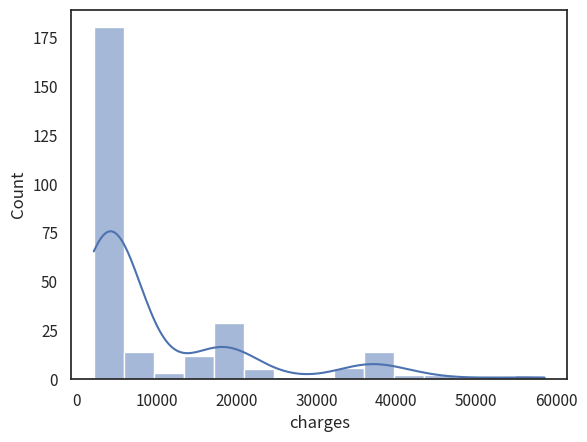

In [ ]:
sb.histplot(ydf25['charges'], kde=True)

2. 링크 함수 적합성 : 
smoker 계수 > 0 인가? 만족
age, bmi 계수 방향이 상식적인가? 만족

In [ ]:
ydf25[['bmi', 'age']].describe()

,bmi,age
count,271.000000,271.000000
mean,30.064133,29.416974
std,6.146324,2.872528
min,17.195000,25.000000
25%,25.800000,27.000000
50%,29.700000,29.000000
75%,33.760000,32.000000
max,46.530000,34.000000


3. GLM 잔차 확인 :  패턴이 없고 0을 중심으로 대칭적으로 분포하지 않음 즉 선형성 가정 위반

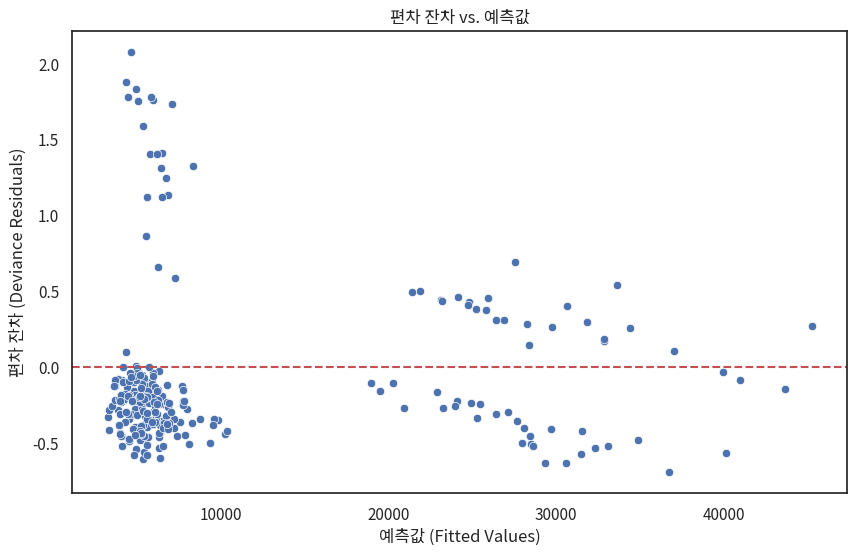

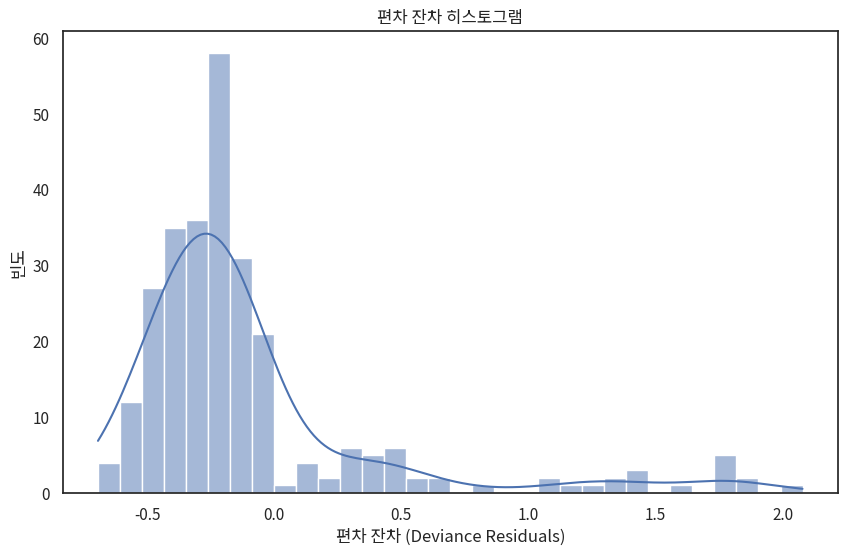

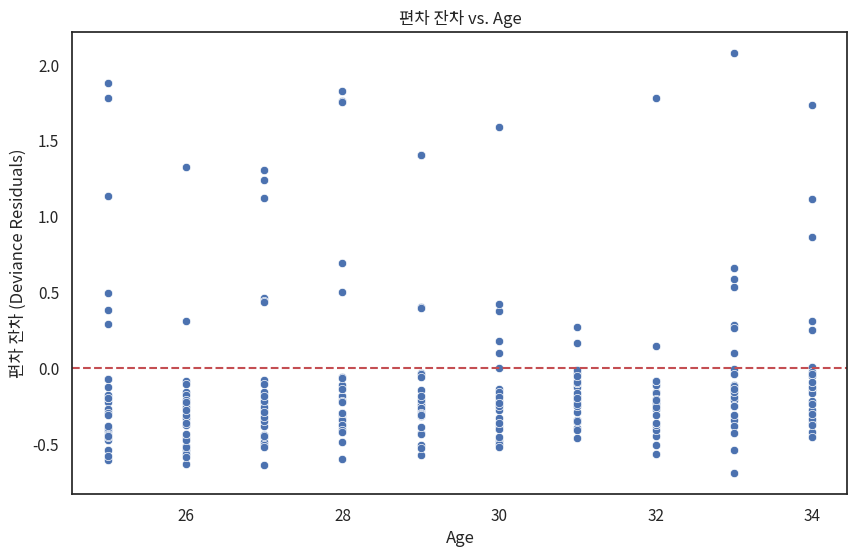

In [ ]:
# 1. 잔차 추출
deviance_residuals = model25g_glm.resid_deviance
pearson_residuals = model25g_glm.resid_pearson

# 예측값 추출 (잔차 vs 예측값 플롯에 필요)
fitted_values = model25g_glm.fittedvalues

# 2. 잔차 vs. 예측값 플롯 (등분산성 및 패턴 확인)
# 이상적으로는 0을 중심으로 무작위로 분포되어야 합니다.
plt.figure(figsize=(10, 6))
sb.scatterplot(x=fitted_values, y=deviance_residuals) # 또는 pearson_residuals
plt.axhline(y=0, color='r', linestyle='--')
plt.title('편차 잔차 vs. 예측값')
plt.xlabel('예측값 (Fitted Values)')
plt.ylabel('편차 잔차 (Deviance Residuals)')
plt.show()

# 3. 잔차 히스토그램 (잔차 분포의 대략적인 형태 확인)
# 0을 중심으로 대략적으로 대칭적인 분포를 보이는 것이 좋습니다.
plt.figure(figsize=(10, 6))
sb.histplot(deviance_residuals, kde=True) # 또는 pearson_residuals
plt.title('편차 잔차 히스토그램')
plt.xlabel('편차 잔차 (Deviance Residuals)')
plt.ylabel('빈도')
plt.show()

# 4. 잔차 vs. 각 독립 변수 (선형성 가정 위반 여부 확인)
# 각 독립 변수와 잔차 사이에 패턴이 없어야 합니다.
# 예시: 'age' 변수에 대해
# 만약 model_glm을 만들 때 사용한 데이터프레임이 df_encoded라면
# df_encoded['age']를 사용합니다.
plt.figure(figsize=(10, 6))
sb.scatterplot(x=model25g_glm.model.exog[:, model25g_glm.model.exog_names.index('age')], y=deviance_residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('편차 잔차 vs. Age')
plt.xlabel('Age')
plt.ylabel('편차 잔차 (Deviance Residuals)')
plt.show()

1. 편차 잔차 vs 예측값
-관측
예측값이 작으면 잔차의 분산이 큼
예측값이 커지면 잔차가 음의 방향으로 수렴
뚜렷한 곡선 패턴 존재
-해석
잔차가 0을 중심으로 무작위하게 흩어져야 하지만 그렇지 못함
예측값의 변화에 따라 잔차의 구조가 체계적으로 변화함

2. 편차 잔차 히스토그램
-관측
분포가 0을 중심으로 대칭이 아님
오른쪽 꼬리가 매우 긴 양의 왜도
-해석
극단값을 갖는 잔차 다수 존재

3. 편차 잔차 vs Age
-관측
연령이 증가할수록 잔차의 평균이 상승
특정 연령대(중, 고령)에서 양의 잔차 집중
잔차 분산 연령대별로 다름
-해석
잔차 - age 와의 체계적 패턴 존재

<정리>
예측값 및 연령 변수에 대해 체계적인 패턴이 관찰, 현재의 모델은 데이터의 구조를 충분히 반영하지 못 한다.

<질문>
왜 ols를 이용한 선형회귀분석에서는 선형성, 등분산성을 만족했지만 감마glm을 이용한 분석에는 선형성, 등분산성을 만족하지 못 할까?
<답>
ols와 감마 glm은 잔차를 보는 기준이 완전히 다르다.
즉 OLS 잔차 ≠ GLM 잔차

<25-34> *GLM 적용 버전

Gamma GLM(log link) 분석 결과,
흡연 여부는 의료비에 가장 큰 영향을 미치는 요인으로 나타났다.
흡연자는 비흡연자 대비 의료비가 5배 넘게 높았으며(p < 0.001),
이는 다른 변수들의 효과를 크게 상회하는 수준이다.
BMI와 자녀 수 또한 의료비 증가와 유의한 양의 관계를 보였고,
남동부 및 남서부 지역은 기준 지역 대비 의료비가 유의하게 낮았다.
반면 성별과 나이는 통계적으로 유의한 영향을 미치지 않았다.



모형 정보
- 모형: Generalized Linear Model (Gamma)
- 종속변수: charges
- 관측치 수: 271
- Pseudo R² (Cox–Snell): 0.6686
- Scale: 0.5315


| 변수 | 계수 (β) | exp(β) | p-value | 해석 |
|---|---:|---:|---:|---|
| Intercept | 7.3765 | 1,598 | <0.001 | 기준 집단의 평균 의료비 |
| Male (vs Female) | -0.0429 | 0.95 | 0.637 | 성별에 따른 의료비 차이 없음 |
| Smoker (Yes vs No) | 1.6887 | 5.41 | <0.001 | 흡연자는 비흡연자 대비 의료비 약 5배 증가 |
| Region: Northwest | -0.2056 | 0.81 | 0.109 | Northeast와 Northwest의 차이 없음 |
| Region: Southeast | -0.3857 | 0.68 | 0.003 | Northeast 대비 약 32% 낮음 |
| Region: Southwest | -0.3410 | 0.71 | 0.009 | Northeast 대비 약 29% 낮음 |
| Age (1세 증가) | 0.0270 | 1.02 | 0.083 | 나이에 따른 의료비 차이 없음 |
| BMI (1 증가) | 0.0189 | 1.01 | 0.016 | BMI 1 증가 시 의료비 약 1.0% 증가 |
| Children (1명 증가) | 0.0966 | 1.10 | <0.001 | 자녀 수 1명 증가 시 의료비 약 10% 증가 |

#### 35-44 그룹

In [ ]:
model35 = ols('log_charges ~ C(sex) + bmi + children + C(smoker) + C(region)', data = ydf35).fit()
stats.shapiro(model35.resid)

ShapiroResult(statistic=np.float64(0.8639387014267138), pvalue=np.float64(2.1162594952070204e-14))

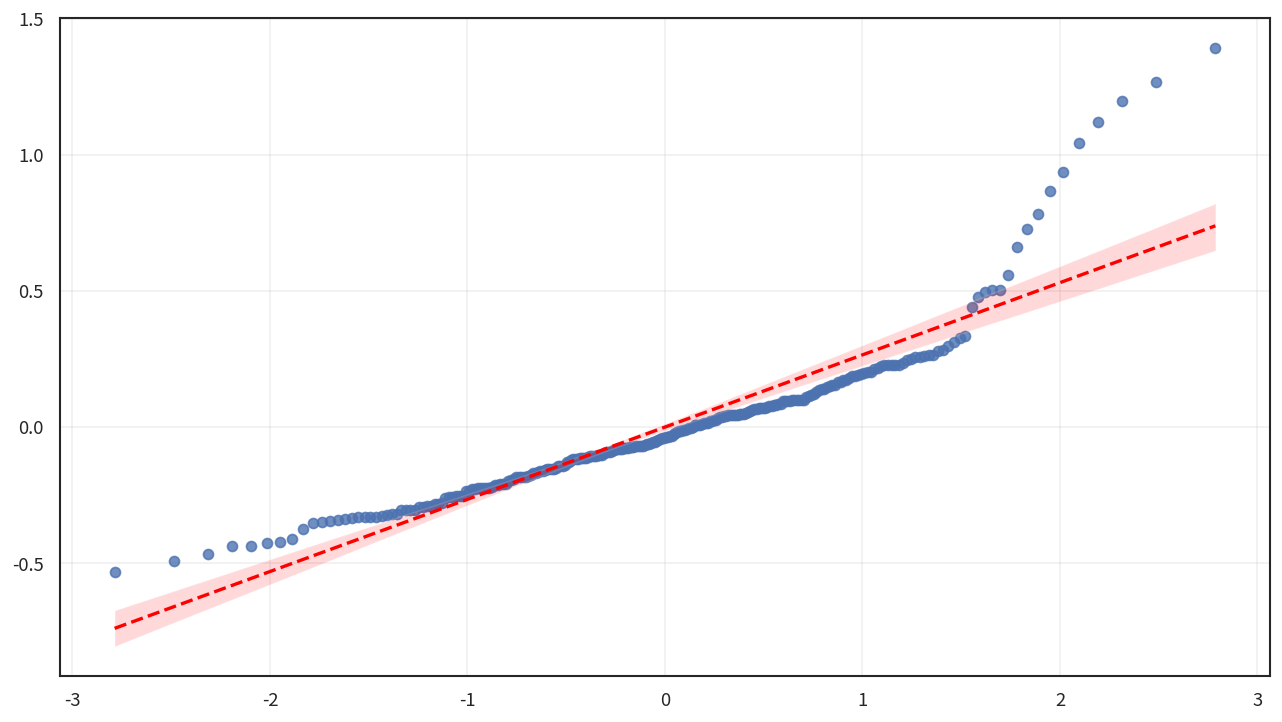

In [ ]:
(x, y), _ = probplot(model35.resid)

width_px  = 1280
height_px = 720
rows = 1
cols = 1
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

# 2) regplot 그리기
sb.regplot(x=x, y=y, line_kws={
"color": "red",
"linestyle": "--",   
"linewidth": 2
            })
# 3) 그래프 꾸미기
ax.grid(True, alpha=0.3)           

plt.tight_layout()      
plt.show()              
plt.close()             

2. 선형성 검정, 결과 : 선형성 만족 안함

In [ ]:
reset_res = linear_reset(model35, power=2, use_f=True)
print(f"RESET F-statistic: {reset_res.fvalue:.4f}")
print(f"p-value: {reset_res.pvalue:.4f}")
if reset_res.pvalue < 0.05:
    print("선형성/기능형 위배 가능성이 있음 (5% 유의수준)")
else:
    print("선형성 가정 위배 근거 없음 (5% 유의수준)")

RESET F-statistic: 7.7165
p-value: 0.0059
선형성/기능형 위배 가능성이 있음 (5% 유의수준)


3.  잔차의 독립성 검정, 결과 : 독립성 만족

In [ ]:
dw = durbin_watson(model35.resid)

if 1.5 <= dw <= 2.5:
    interpretation = "잔차는 독립성을 만족함 (자기상관 없음)"
elif dw < 1.5:
    interpretation = "잔차에 양(+)의 자기상관이 존재할 가능성 있음 (독립성 위반)"
else:
    interpretation = "잔차에 음(–)의 자기상관이 존재할 가능성 있음 (독립성 위반)"

print(f"Durbin–Watson: {dw:.3f}")
print(interpretation)

Durbin–Watson: 2.091
잔차는 독립성을 만족함 (자기상관 없음)


4. 등분산성 검정, 결과 : 등분산

In [ ]:
# Breusch–Pagan Test
names = ['LM Statistic', 'LM p-value', 'F Statistic', 'F p-value']
bp_test = het_breuschpagan(model35.resid, model35.model.exog)
bp = DataFrame(bp_test, index=names, columns=['value'])

# p-value는 F p-value를 기준으로 사용
p_bp = bp.loc['F p-value', 'value']

print(f"Breusch–Pagan statistic: {bp.loc['F Statistic','value']:.3f}, p-value = {p_bp:.3f}")
print(f"{'이분산성 존재(등분산 아님)' if p_bp <= 0.05 else '등분산성 만족'}")

Breusch–Pagan statistic: 1.694, p-value = 0.111
등분산성 만족


선형성 만족안함, 만족을 위해 다항식 추가

In [ ]:
model35 = ols('log_charges ~ C(sex) + bmi + bmi**2 + children + C(smoker) + C(region)', data = ydf35).fit()

reset_res = linear_reset(model35, power=2, use_f=True)
print(f"RESET F-statistic: {reset_res.fvalue:.4f}")
print(f"p-value: {reset_res.pvalue:.4f}")
if reset_res.pvalue < 0.05:
    print("선형성/기능형 위배 가능성이 있음 (5% 유의수준)")
else:
    print("선형성 가정 위배 근거 없음 (5% 유의수준)")

RESET F-statistic: 7.7165
p-value: 0.0059
선형성/기능형 위배 가능성이 있음 (5% 유의수준)


In [ ]:
model35 = ols('log_charges ~ C(sex) + bmi + children + children**2 + C(smoker) + C(region)', data = ydf35).fit()

reset_res = linear_reset(model35, power=2, use_f=True)
print(f"RESET F-statistic: {reset_res.fvalue:.4f}")
print(f"p-value: {reset_res.pvalue:.4f}")
if reset_res.pvalue < 0.05:
    print("선형성/기능형 위배 가능성이 있음 (5% 유의수준)")
else:
    print("선형성 가정 위배 근거 없음 (5% 유의수준)")

RESET F-statistic: 7.7165
p-value: 0.0059
선형성/기능형 위배 가능성이 있음 (5% 유의수준)


In [ ]:
model35 = ols('log_charges ~ C(sex) + bmi + bmi**2 + children + children**2 + C(smoker) + C(region)', data = ydf35).fit()

reset_res = linear_reset(model35, power=2, use_f=True)
print(f"RESET F-statistic: {reset_res.fvalue:.4f}")
print(f"p-value: {reset_res.pvalue:.4f}")
if reset_res.pvalue < 0.05:
    print("선형성/기능형 위배 가능성이 있음 (5% 유의수준)")
else:
    print("선형성 가정 위배 근거 없음 (5% 유의수준)")

RESET F-statistic: 7.7165
p-value: 0.0059
선형성/기능형 위배 가능성이 있음 (5% 유의수준)


잔차–예측값 산점도에서 이분산성과 비선형 패턴이 확인되었다. 로그 변환, 다항항 추가, 상호작용항 포함 등 모형 재설정에도 불구하고 이러한 가정 위배는 해소되지 않았다. 이에 종속변수의 분포 특성을 직접 반영할 수 있는 Gamma GLM을 적용 실시

In [ ]:
import statsmodels.formula.api as smf
model35_glm = smf.glm(
    formula='charges ~ age + C(sex) +bmi + children + C(smoker) + C(region)',
    data=ydf35,
    family=sm.families.Gamma(link=sm.families.links.log())
).fit()
print(model35_glm.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                charges   No. Observations:                  260
Model:                            GLM   Df Residuals:                      251
Model Family:                   Gamma   Df Model:                            8
Link Function:                    log   Scale:                         0.15097
Method:                          IRLS   Log-Likelihood:                -2464.5
Date:                Fri, 16 Jan 2026   Deviance:                       23.109
Time:                        10:54:43   Pearson chi2:                     37.9
No. Iterations:                    12   Pseudo R-squ. (CS):             0.9585
Covariance Type:            nonrobust                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  6

c:\Users\itwill\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\genmod\families\links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(


GLM 기본가정 만족여부
1. 분포가정
2. 링크 함수 적합성
3. GLM 잔차 확인

1. 분포 가정 : 우측꼬리 모형, 독립변수 종속변수 모두 양수 ? 만족

<Axes: xlabel='charges', ylabel='Count'>

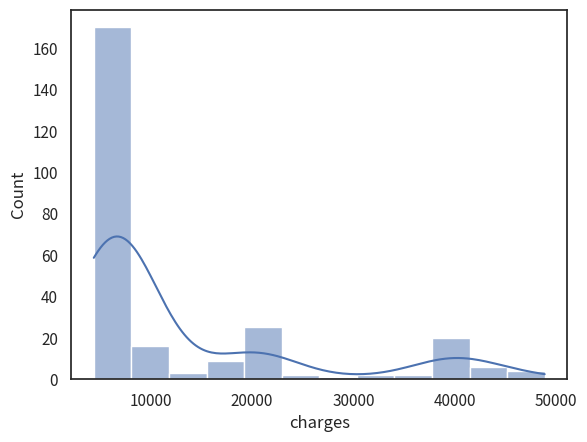

In [ ]:
sb.histplot(ydf35['charges'], kde=True)

2. 링크 함수 적합성 : 
smoker 계수 > 0 인가? 만족
age, bmi 계수 방향이 상식적인가? 만족

In [ ]:
ydf35[['bmi', 'age']].describe()

,bmi,age
count,260.000000,260.000000
mean,30.399712,39.596154
std,5.880318,2.876208
min,16.815000,35.000000
25%,26.291250,37.000000
50%,29.910000,40.000000
75%,34.320000,42.000000
max,47.600000,44.000000


3. GLM 잔차 확인 :
편차잔차 vs 예측값
낮은 예측값 구간에서 잔차 분산 큼
예측값 증가할수록 잔차가 음의 방향으로 쏠림
완전한 적합은 아님, 하지만 ols에서 보이던 깔때기형 이분산보다는 완화됨

편차잔차 히스토그램
우측 꼬리 긴 비대칭 분포, 정상
gamma GLM에서는 정규성 요구 안 함

편차잔차 vs age
잔차가 0을 중심으로 전 연령대에 고르게 분포
연령 증가에 따른 곡선형·체계적 패턴 없음
특정 연령대에서 분산이 급격히 커지거나 작아지는 구간 없음

정리 : 잔차 진단 결과 일부 구간 변동성이 있으나 ols보다 구조가 완화된 모양을 보여 본 모형을 채택하였다.

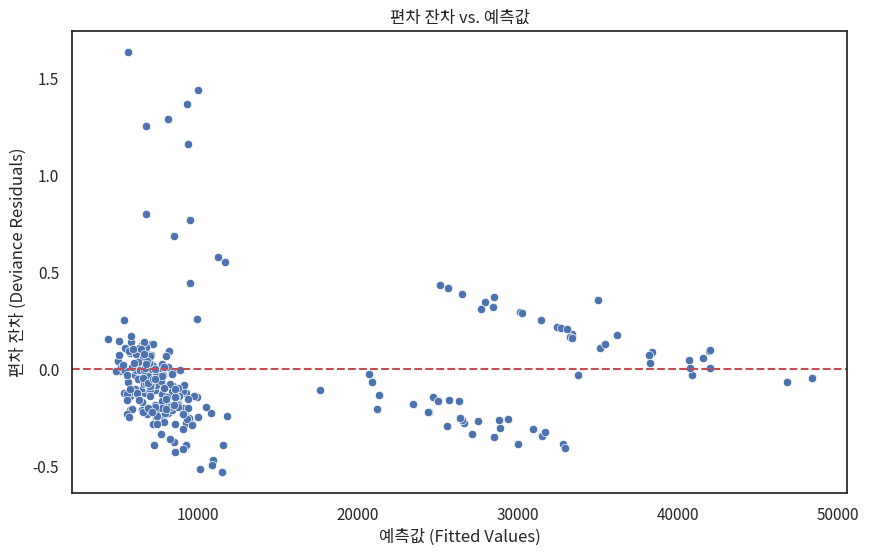

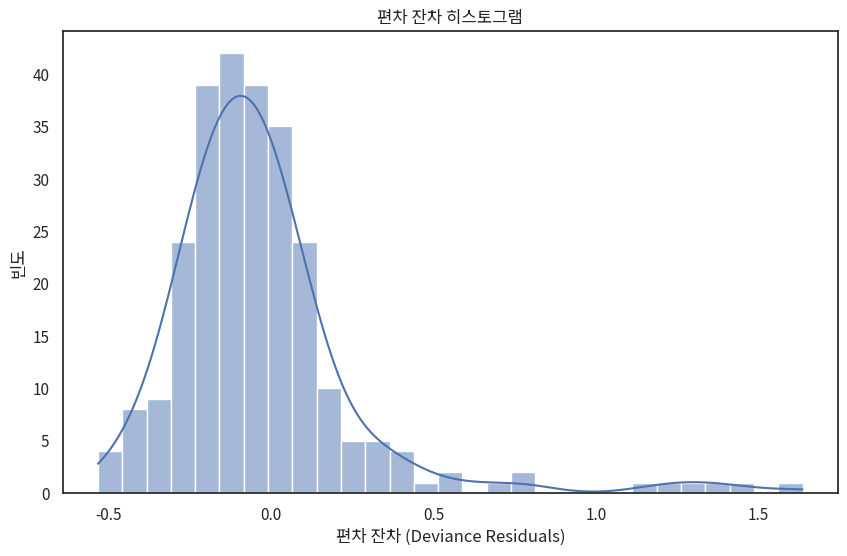

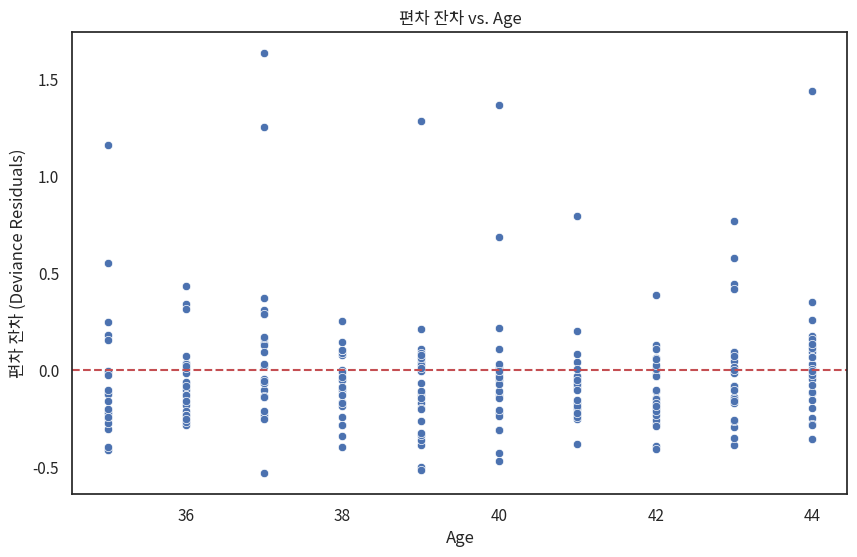

In [ ]:
# 1. 잔차 추출
deviance_residuals = model35_glm.resid_deviance
pearson_residuals = model35_glm.resid_pearson

# 예측값 추출 (잔차 vs 예측값 플롯에 필요)
fitted_values = model35_glm.fittedvalues

# 2. 잔차 vs. 예측값 플롯 (등분산성 및 패턴 확인)
# 이상적으로는 0을 중심으로 무작위로 분포되어야 합니다.
plt.figure(figsize=(10, 6))
sb.scatterplot(x=fitted_values, y=deviance_residuals) # 또는 pearson_residuals
plt.axhline(y=0, color='r', linestyle='--')
plt.title('편차 잔차 vs. 예측값')
plt.xlabel('예측값 (Fitted Values)')
plt.ylabel('편차 잔차 (Deviance Residuals)')
plt.show()

# 3. 잔차 히스토그램 (잔차 분포의 대략적인 형태 확인)
# 0을 중심으로 대략적으로 대칭적인 분포를 보이는 것이 좋습니다.
plt.figure(figsize=(10, 6))
sb.histplot(deviance_residuals, kde=True) # 또는 pearson_residuals
plt.title('편차 잔차 히스토그램')
plt.xlabel('편차 잔차 (Deviance Residuals)')
plt.ylabel('빈도')
plt.show()

# 4. 잔차 vs. 각 독립 변수 (선형성 가정 위반 여부 확인)
# 각 독립 변수와 잔차 사이에 패턴이 없어야 합니다.
# 예시: 'age' 변수에 대해
# 만약 model_glm을 만들 때 사용한 데이터프레임이 df_encoded라면
# df_encoded['age']를 사용합니다.
plt.figure(figsize=(10, 6))
sb.scatterplot(x=model35_glm.model.exog[:, model35_glm.model.exog_names.index('age')], y=deviance_residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('편차 잔차 vs. Age')
plt.xlabel('Age')
plt.ylabel('편차 잔차 (Deviance Residuals)')
plt.show()

Gamma GLM의 편차 잔차와 연령 간 산점도를 확인한 결과, 잔차는 0을 중심으로 무작위적으로 분포하였으며 연령에 따른 체계적인 패턴이나 비선형 구조는 관찰되지 않았다. 이는 연령 효과가 모형에 적절히 반영되었음을 시사한다

다중공선성 확인, 처리

In [ ]:
ydf35.head(3)

,age,sex,bmi,children,smoker,region,charges,age_group,log_charges
7,37,female,27.740,3,no,northwest,7281.50560,35-44,8.893093
8,37,male,29.830,2,no,northeast,6406.41070,35-44,8.765054
24,37,male,28.025,2,no,northwest,6203.90175,35-44,8.732934


In [ ]:
ydf35_1 = ydf35.copy()
ydf35_1 = ydf35_1.drop(columns = ['age_group', 'charges', 'age'])
ydf35e = pd.get_dummies(ydf35_1, dtype = 'int', drop_first = True)
print(ydf35e.shape)

(260, 8)


타겟 데이터 분리

In [ ]:
ydf35ev = ydf35e.copy()
Y = ydf35ev.pop('log_charges')
print(ydf35ev.shape, ydf35ev.shape)

(260, 7) (260, 7)


In [ ]:
vif_list2 = []
for i in range(ydf35ev.shape[1]):
    vif_values = variance_inflation_factor(ydf35ev.values, i)
    vif_list2.append(vif_values)
yv = pd.DataFrame({
    'feature' : ydf35ev.columns,
    'VIF' : vif_list2
})
yv

,feature,VIF
0,bmi,6.664096
1,children,2.413502
2,sex_male,1.992680
3,smoker_yes,1.328021
4,region_northwest,1.971067
5,region_southeast,2.302534
6,region_southwest,1.987681


vif 10이상 없음

회귀식 : 6.9228 + 0.0076 * C(sex)[T.male]  + 1.3826 * C(smoker)[T.yes] -0.1588 * C(region)[T.northwest] -0.1687 * C(region)[T.southeast] -0.1929 * C(region)[T.southwest] + 0.0305 * age + 0.0259 * bmi + 0.0864 * children

<35-44>

Gamma GLM(log link) 분석 결과, 흡연 여부는 의료비에 가장 큰 영향을 미치는 요인으로 나타났다.
흡연자의 평균 의료비는 비흡연자 대비 약 4배 높았으며(p < 0.001),
이는 다른 모든 변수의 효과를 크게 상회하는 수준이다.
나이, BMI, 자녀 수 또한 의료비 증가와 유의한 양의 관계를 보였으나,
성별은 통계적으로 유의한 영향을 미치지 않았다.
또한 모든 지역 변수는 기준 지역(Northeast) 대비 의료비가 유의하게 낮은 것으로 나타났다.

- 모형: Generalized Linear Model (Gamma)
- 링크 함수: log
- 종속변수: charges
- 관측치 수: 260
- Pseudo R² (Cox–Snell): 0.9585
- Scale: 0.1509


| 변수 | 계수 (β) | exp(β) | p-value | 해석 |
|---|---:|---:|---:|---|
| Intercept | 6.9228 | 1,015 | <0.001 | 기준 집단의 평균 의료비 |
| Male (vs Female) | 0.0076 | 1.01 | 0.875 | 성별에 따른 의료비 차이 없음 |
| Smoker (Yes vs No) | 1.3826 | 3.99 | <0.001 | 흡연자는 비흡연자 대비 의료비 약 4배 증가 |
| Region: Northwest | -0.1588 | 0.85 | 0.024 | Northeast 대비 약 15% 낮음 |
| Region: Southeast | -0.1687 | 0.84 | 0.015 | Northeast 대비 약 16% 낮음 |
| Region: Southwest | -0.1929 | 0.82 | 0.006 | Northeast 대비 약 18% 낮음 |
| Age (1세 증가) | 0.0305 | 1.03 | <0.001 | 나이 1세 증가 시 의료비 약 3.0% 증가 |
| BMI (1 증가) | 0.0259 | 1.03 | <0.001 | BMI 1 증가 시 의료비 약 2.6% 증가 |
| Children (1명 증가) | 0.0864 | 1.09 | <0.001 | 자녀 수 1명 증가 시 의료비 약 9% 증가 |


#### 45-64 그룹 

In [ ]:
model45 = ols('log_charges ~ C(sex) + bmi + children + C(smoker) + C(region)', data = ydf45).fit()
stats.shapiro(model45.resid)

ShapiroResult(statistic=np.float64(0.9062805181640432), pvalue=np.float64(1.6039359255367875e-17))

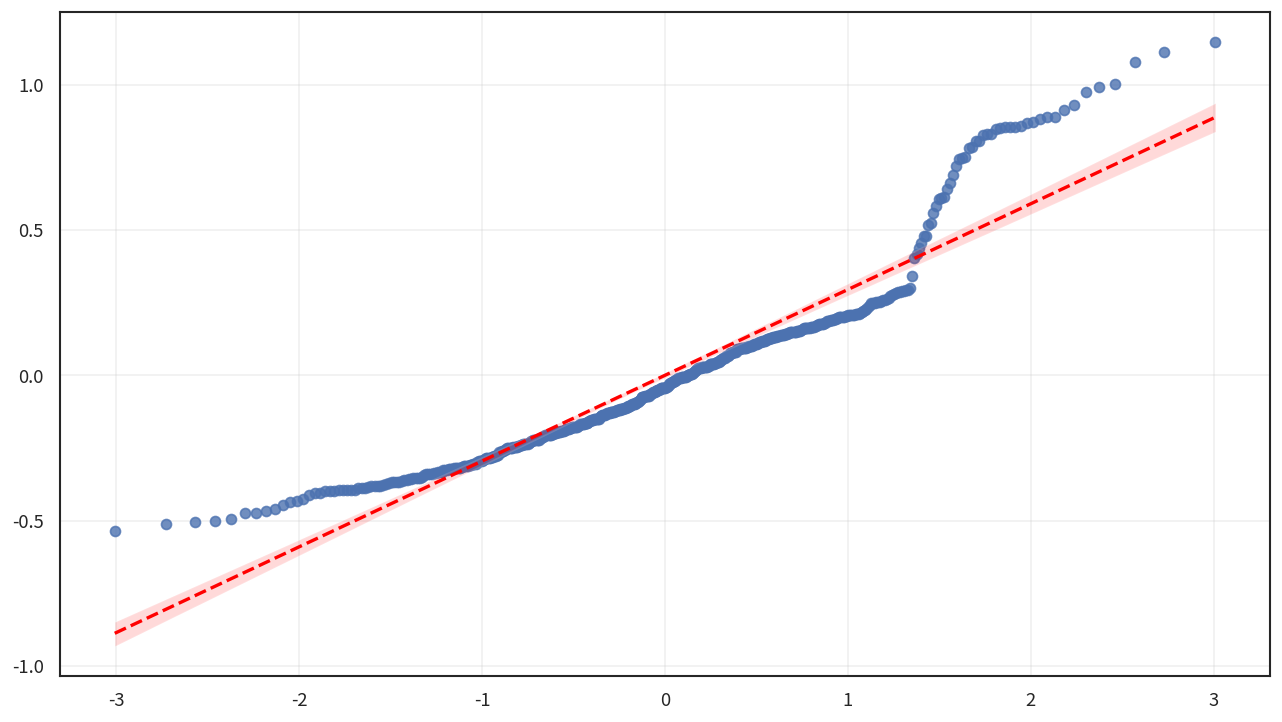

In [ ]:
(x, y), _ = probplot(model45.resid)

width_px  = 1280
height_px = 720
rows = 1
cols = 1
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

# 2) regplot 그리기
sb.regplot(x=x, y=y, line_kws={
"color": "red",
"linestyle": "--",   
"linewidth": 2
            })
# 3) 그래프 꾸미기
ax.grid(True, alpha=0.3)           

plt.tight_layout()      
plt.show()              
plt.close()             

2. 선형성 검정, 결과 : 선형성 위반

In [ ]:
reset_res = linear_reset(model45, power=2, use_f=True)
print(f"RESET F-statistic: {reset_res.fvalue:.4f}")
print(f"p-value: {reset_res.pvalue:.4f}")
if reset_res.pvalue < 0.05:
    print("선형성/기능형 위배 가능성이 있음 (5% 유의수준)")
else:
    print("선형성 가정 위배 근거 없음 (5% 유의수준)")

RESET F-statistic: 34.7760
p-value: 0.0000
선형성/기능형 위배 가능성이 있음 (5% 유의수준)


3.  잔차의 독립성 검정, 결과 : 독립성 만족

In [ ]:
dw = durbin_watson(model45.resid)

if 1.5 <= dw <= 2.5:
    interpretation = "잔차는 독립성을 만족함 (자기상관 없음)"
elif dw < 1.5:
    interpretation = "잔차에 양(+)의 자기상관이 존재할 가능성 있음 (독립성 위반)"
else:
    interpretation = "잔차에 음(–)의 자기상관이 존재할 가능성 있음 (독립성 위반)"

print(f"Durbin–Watson: {dw:.3f}")
print(interpretation)

Durbin–Watson: 2.073
잔차는 독립성을 만족함 (자기상관 없음)


4. 등분산성 검정, 결과 : 등분산

In [ ]:
# Breusch–Pagan Test
names = ['LM Statistic', 'LM p-value', 'F Statistic', 'F p-value']
bp_test = het_breuschpagan(model45.resid, model45.model.exog)
bp = DataFrame(bp_test, index=names, columns=['value'])

# p-value는 F p-value를 기준으로 사용
p_bp = bp.loc['F p-value', 'value']

print(f"Breusch–Pagan statistic: {bp.loc['F Statistic','value']:.3f}, p-value = {p_bp:.3f}")
print(f"{'이분산성 존재(등분산 아님)' if p_bp <= 0.05 else '등분산성 만족'}")

Breusch–Pagan statistic: 0.629, p-value = 0.732
등분산성 만족


선형성 만족안함, 만족을 위해 다항식 추가

In [ ]:
model45 = ols('log_charges ~ C(sex) + bmi + bmi**2 + children + C(smoker) + C(region)', data = ydf45).fit()

reset_res = linear_reset(model45, power=2, use_f=True)
print(f"RESET F-statistic: {reset_res.fvalue:.4f}")
print(f"p-value: {reset_res.pvalue:.4f}")
if reset_res.pvalue < 0.05:
    print("선형성/기능형 위배 가능성이 있음 (5% 유의수준)")
else:
    print("선형성 가정 위배 근거 없음 (5% 유의수준)")

RESET F-statistic: 34.7760
p-value: 0.0000
선형성/기능형 위배 가능성이 있음 (5% 유의수준)


In [ ]:
model45 = ols('log_charges ~ C(sex) + bmi + children + children**2 + C(smoker) + C(region)', data = ydf45).fit()

reset_res = linear_reset(model45, power=2, use_f=True)
print(f"RESET F-statistic: {reset_res.fvalue:.4f}")
print(f"p-value: {reset_res.pvalue:.4f}")
if reset_res.pvalue < 0.05:
    print("선형성/기능형 위배 가능성이 있음 (5% 유의수준)")
else:
    print("선형성 가정 위배 근거 없음 (5% 유의수준)")

RESET F-statistic: 34.7760
p-value: 0.0000
선형성/기능형 위배 가능성이 있음 (5% 유의수준)


In [ ]:
model45 = ols('log_charges ~ C(sex) + bmi + bmi**2 + children + children**2 + C(smoker) + C(region)', data = ydf45).fit()

reset_res = linear_reset(model45, power=2, use_f=True)
print(f"RESET F-statistic: {reset_res.fvalue:.4f}")
print(f"p-value: {reset_res.pvalue:.4f}")
if reset_res.pvalue < 0.05:
    print("선형성/기능형 위배 가능성이 있음 (5% 유의수준)")
else:
    print("선형성 가정 위배 근거 없음 (5% 유의수준)")

RESET F-statistic: 34.7760
p-value: 0.0000
선형성/기능형 위배 가능성이 있음 (5% 유의수준)


잔차–예측값 산점도에서 이분산성과 비선형 패턴이 확인되었다. 로그 변환, 다항항 추가, 상호작용항 포함 등 모형 재설정에도 불구하고 이러한 가정 위배는 해소되지 않았다. 이에 종속변수의 분포 특성을 직접 반영할 수 있는 Gamma GLM을 적용 실시

In [ ]:
import statsmodels.formula.api as smf
model45_glm = smf.glm(
    formula='charges ~ age + C(sex) +bmi + children + C(smoker) + C(region)',
    data=ydf45,
    family=sm.families.Gamma(link=sm.families.links.log())
).fit()
print(model45_glm.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                charges   No. Observations:                  529
Model:                            GLM   Df Residuals:                      520
Model Family:                   Gamma   Df Model:                            8
Link Function:                    log   Scale:                         0.14211
Method:                          IRLS   Log-Likelihood:                -5214.5
Date:                Fri, 16 Jan 2026   Deviance:                       48.344
Time:                        10:54:44   Pearson chi2:                     73.9
No. Iterations:                    11   Pseudo R-squ. (CS):             0.8123
Covariance Type:            nonrobust                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  7

c:\Users\itwill\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\genmod\families\links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(


GLM 기본가정 만족여부
1. 분포가정
2. 링크 함수 적합성
3. GLM 잔차 확인

1. 분포 가정 : 우측꼬리 모형, 독립변수 종속변수 모두 양수 ? 만족

<Axes: xlabel='charges', ylabel='Count'>

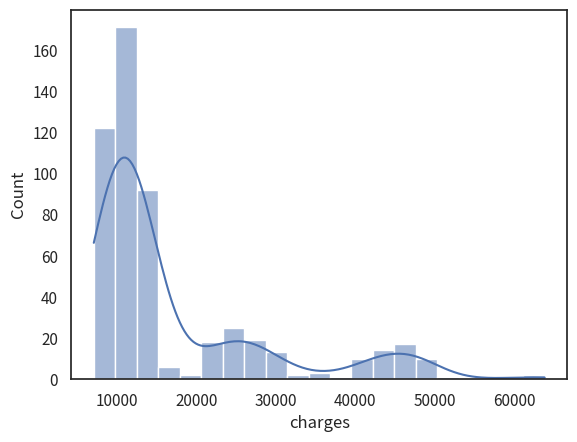

In [ ]:
sb.histplot(ydf45['charges'], kde=True)

2. 링크 함수 적합성 : 
smoker 계수 > 0 인가? 만족
age, bmi 계수 방향이 상식적인가? 만족

In [ ]:
ydf45[['bmi', 'age']].describe()

,bmi,age
count,529.000000,529.000000
mean,31.428166,53.984877
std,5.979496,5.693876
min,18.050000,45.000000
25%,26.980000,49.000000
50%,31.350000,54.000000
75%,35.910000,59.000000
max,49.060000,64.000000


3. GLM 잔차 확인 :
편차잔차 vs 예측값
낮은 예측값 구간에서 잔차 분산 큼
예측값 증가할수록 잔차가 음의 방향으로 쏠림
완전한 적합은 아님, 하지만 ols에서 보이던 깔때기형 이분산보다는 완화됨

편차잔차 히스토그램
우측 꼬리 긴 비대칭 분포, 정상
gamma GLM에서는 정규성 요구 안 함

편차잔차 vs age
부분의 잔차가 -0.5에서 1.0 사이에 분포하고 있음
다만, Age 37 부근에서 1.5를 상회하는 값이나 Age 40, 44 근처의 높은 값들이 눈에 띔

정리 : 잔차 진단 결과 일부 구간 변동성이 있으나 ols보다 구조가 완화된 모양을 보여 본 모형을 채택하였다. 잔차의 패턴이 없으므로 모델의 구조적 설정은 양호

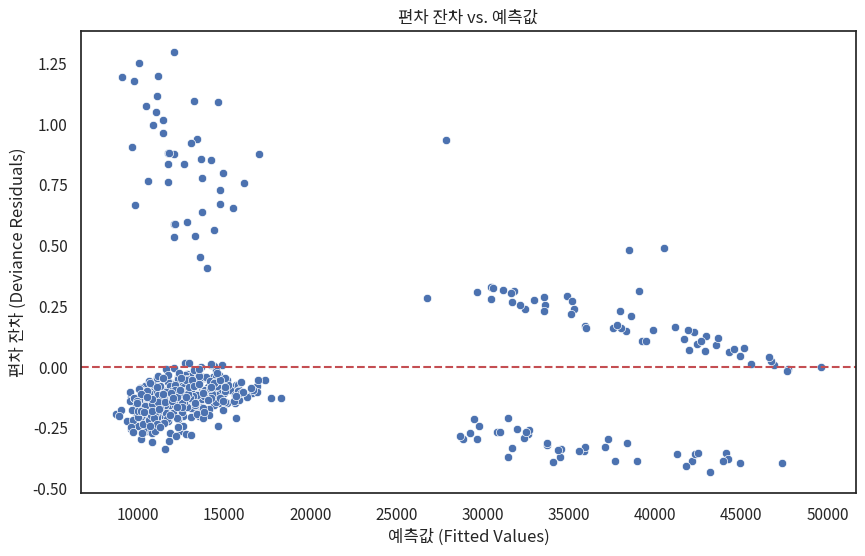

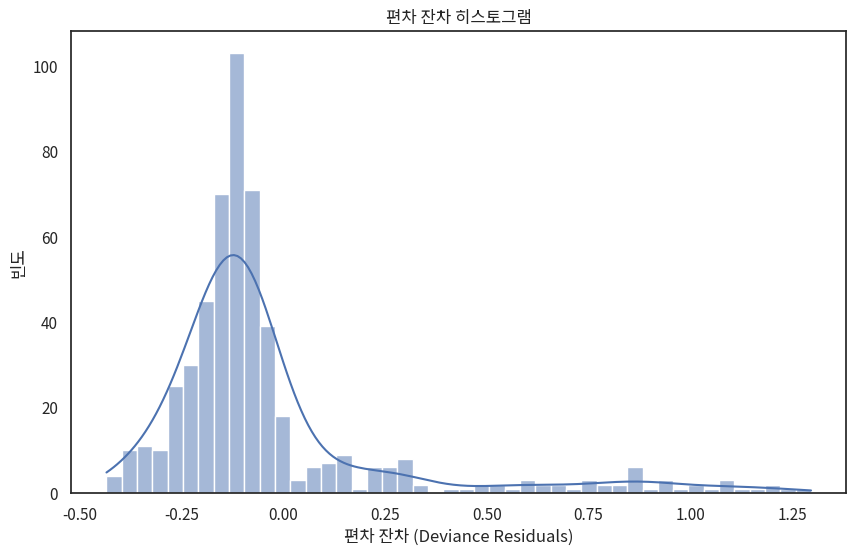

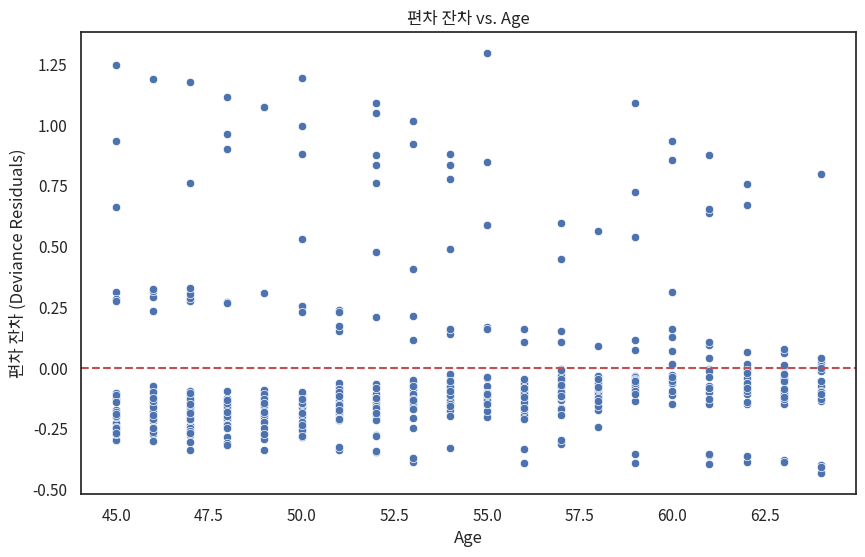

In [ ]:
# 1. 잔차 추출
deviance_residuals = model45_glm.resid_deviance
pearson_residuals = model45_glm.resid_pearson

# 예측값 추출 (잔차 vs 예측값 플롯에 필요)
fitted_values = model45_glm.fittedvalues

# 2. 잔차 vs. 예측값 플롯 (등분산성 및 패턴 확인)
# 이상적으로는 0을 중심으로 무작위로 분포되어야 합니다.
plt.figure(figsize=(10, 6))
sb.scatterplot(x=fitted_values, y=deviance_residuals) # 또는 pearson_residuals
plt.axhline(y=0, color='r', linestyle='--')
plt.title('편차 잔차 vs. 예측값')
plt.xlabel('예측값 (Fitted Values)')
plt.ylabel('편차 잔차 (Deviance Residuals)')
plt.show()

# 3. 잔차 히스토그램 (잔차 분포의 대략적인 형태 확인)
# 0을 중심으로 대략적으로 대칭적인 분포를 보이는 것이 좋습니다.
plt.figure(figsize=(10, 6))
sb.histplot(deviance_residuals, kde=True) # 또는 pearson_residuals
plt.title('편차 잔차 히스토그램')
plt.xlabel('편차 잔차 (Deviance Residuals)')
plt.ylabel('빈도')
plt.show()

# 4. 잔차 vs. 각 독립 변수 (선형성 가정 위반 여부 확인)
# 각 독립 변수와 잔차 사이에 패턴이 없어야 합니다.
# 예시: 'age' 변수에 대해
# 만약 model_glm을 만들 때 사용한 데이터프레임이 df_encoded라면
# df_encoded['age']를 사용합니다.
plt.figure(figsize=(10, 6))
sb.scatterplot(x=model45_glm.model.exog[:, model45_glm.model.exog_names.index('age')], y=deviance_residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('편차 잔차 vs. Age')
plt.xlabel('Age')
plt.ylabel('편차 잔차 (Deviance Residuals)')
plt.show()

In [ ]:
model45_glm.params[:]

Intercept                 7.908799
C(sex)[T.male]           -0.037860
C(smoker)[T.yes]          1.087155
C(region)[T.northwest]   -0.001879
C(region)[T.southeast]   -0.014322
C(region)[T.southwest]   -0.050590
age                       0.023836
bmi                       0.007194
children                  0.038276
dtype: float64

회귀식 : 7.908799 -0.037860 * C(sex)[T.male]  + 1.087155 * C(smoker)[T.yes] -0.001879 * C(region)[T.northwest] -0.014322 * C(region)[T.southeast] -0.050590 * C(region)[T.southwest] + 0.023836 * age + 0.007194 * bmi + 0.038276 * children

<45-64>

Gamma GLM(log link) 분석 결과, 흡연 여부는 의료비에 가장 큰 영향을 미치는 요인으로 나타났다.
흡연자의 평균 의료비는 비흡연자 대비 약 3배 높았으며(p < 0.001),
이는 본 표본에서도 일관되게 유지되는 결과이다.
나이, BMI, 자녀 수는 의료비와 유의한 양의 관계를 보였으나,
그 효과 크기는 상대적으로 제한적인 수준이었다.
반면 성별과 지역 변수는 통계적으로 유의한 영향을 미치지 않았다.

- 모형: Generalized Linear Model (Gamma)
- 링크 함수: log
- 종속변수: charges
- 관측치 수: 529
- Pseudo R² (Cox–Snell): 0.8123
- Scale: 0.1421


| 변수 | 계수 (β) | exp(β) | p-value | 해석 |
|---|---:|---:|---:|---|
| Intercept | 7.9088 | 2,724 | <0.001 | 기준 집단의 평균 의료비 |
| Male (vs Female) | -0.0379 | 0.96 | 0.252 | 성별에 따른 의료비 차이 없음 |
| Smoker (Yes vs No) | 1.0872 | 2.97 | <0.001 | 흡연자는 비흡연자 대비 의료비 약 3배 증가 |
| Region: Northwest | -0.0019 | 1.00 | 0.968 | 지역 효과 없음 |
| Region: Southeast | -0.0143 | 0.99 | 0.761 | 지역 효과 없음 |
| Region: Southwest | -0.0506 | 0.95 | 0.280 | 지역 효과 없음 |
| Age (1세 증가) | 0.0238 | 1.02 | <0.001 | 나이 1세 증가 시 의료비 약 2.4% 증가 |
| BMI (1 증가) | 0.0072 | 1.01 | 0.012 | BMI 1 증가 시 의료비 약 0.7% 증가 |
| Children (1명 증가) | 0.0383 | 1.04 | 0.008 | 자녀 수 1명 증가 시 의료비 약 3.9% 증가 |


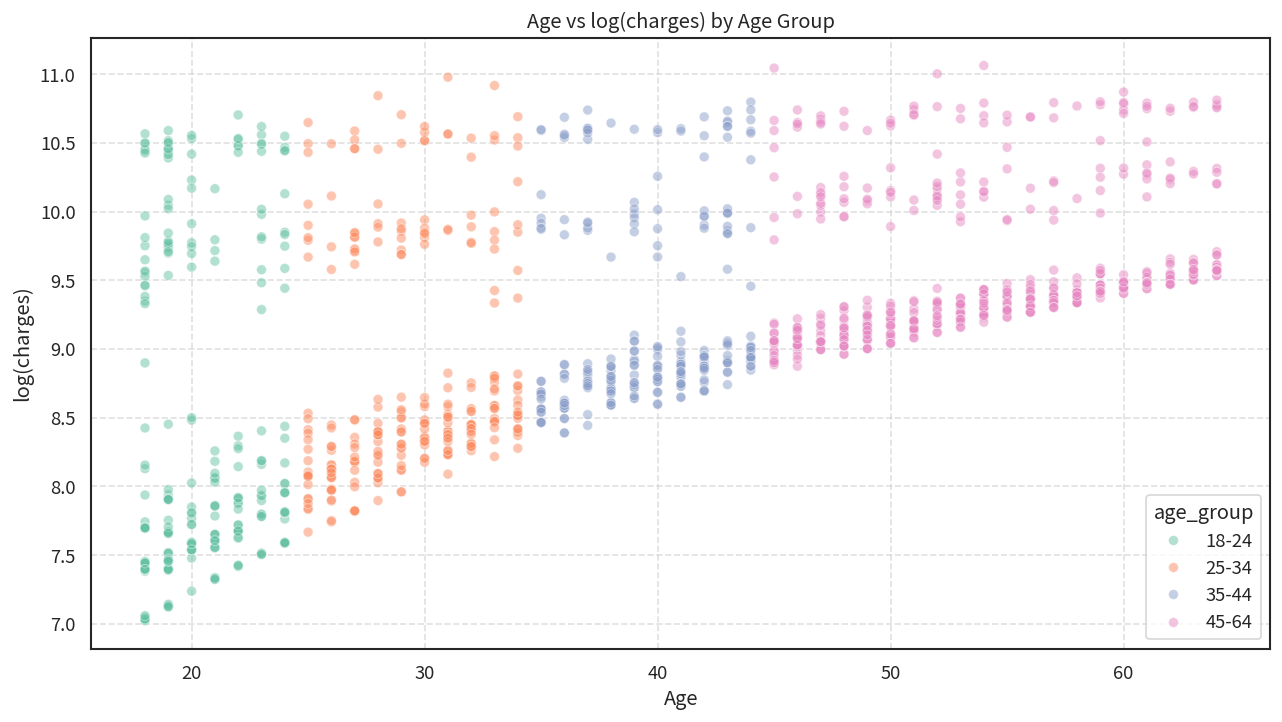

In [ ]:
# 각 연령 그룹별 산점도 비교
import matplotlib.pyplot as plt
import seaborn as sb

width_px, height_px = 1280, 720
figsize = (width_px / my_dpi, height_px / my_dpi)

plt.figure(figsize=figsize, dpi=my_dpi)

sb.scatterplot(
    data=df_plot2,
    x="age",
    y="log_charges",
    hue="age_group",        # 🔑 연령대별 색상 구분
    palette="Set2",
    alpha=0.5,
    s=35
)

plt.title("Age vs log(charges) by Age Group")
plt.xlabel("Age")
plt.ylabel("log(charges)")
plt.grid(True, linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()
plt.close()

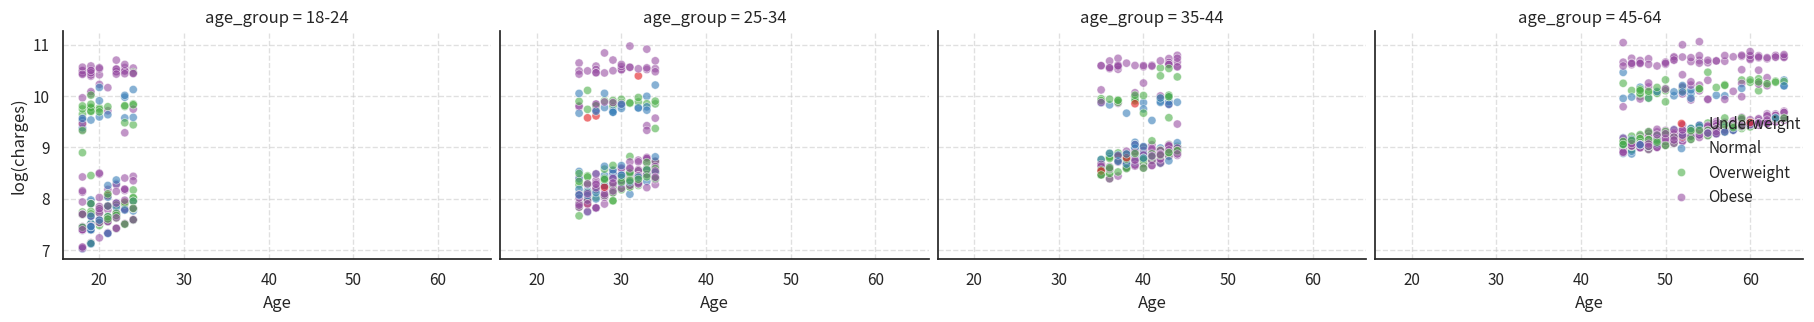

In [ ]:
# 
g = sb.FacetGrid(df_plot2, col="age_group", height=3.2, aspect=1.3)

g.map_dataframe(
    sb.scatterplot,
    x="age",
    y="log_charges",
    hue="bmi_group",
    palette="Set1",
    alpha=0.6,
    s=35
)

g.add_legend()
g.set_axis_labels("Age", "log(charges)")

for ax in g.axes.flatten():
    ax.grid(True, linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()
plt.close()

## 미션 6. 상호작용항 확인
- bmi , age 범주형으로 확인

In [ ]:
df_plot2

,age,sex,bmi,children,smoker,region,charges,charges_robust,age_robust,bmi_robust,log_charges
0,19,female,27.900,0,yes,southwest,16884.92400,0.630515,-0.833333,-0.297708,9.734176
1,18,male,33.770,1,no,southeast,1725.55230,-0.643422,-0.875000,0.401310,7.453302
2,28,male,33.000,3,no,southeast,4449.46200,-0.414515,-0.458333,0.309616,8.400538
3,33,male,22.705,0,no,northwest,21984.47061,1.059062,-0.250000,-0.916344,9.998092
4,32,male,28.880,0,no,northwest,3866.85520,-0.463475,-0.291667,-0.181006,8.260197
...,...,...,...,...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830,0.102399,0.458333,0.067877,9.268661
1334,18,female,31.920,0,no,northeast,2205.98080,-0.603049,-0.875000,0.181006,7.698927
1335,18,female,36.850,0,no,southeast,1629.83350,-0.651466,-0.875000,0.768086,7.396233
1336,21,female,25.800,0,no,southwest,2007.94500,-0.619691,-0.750000,-0.547782,7.604867


In [ ]:
df_interaction_df_analysis = df_plot2.copy()

In [ ]:
df_interaction_df_analysis.head()

,age,sex,bmi,children,smoker,region,charges,charges_robust,age_robust,bmi_robust,log_charges
0,19,female,27.900,0,yes,southwest,16884.92400,0.630515,-0.833333,-0.297708,9.734176
1,18,male,33.770,1,no,southeast,1725.55230,-0.643422,-0.875000,0.401310,7.453302
2,28,male,33.000,3,no,southeast,4449.46200,-0.414515,-0.458333,0.309616,8.400538
3,33,male,22.705,0,no,northwest,21984.47061,1.059062,-0.250000,-0.916344,9.998092
4,32,male,28.880,0,no,northwest,3866.85520,-0.463475,-0.291667,-0.181006,8.260197


In [ ]:
# 범주형으로 타입 변환
df_analysis_dummy_origin = df_interaction_df_analysis.astype({
    'sex': 'category',
    'smoker': 'category',
    'region': 'category'
})

df_analysis_dummy_origin.info()
